# Galassify

## Aplicación de Deep autoencoder para segmentación con dataset v3-3k3


En este notebook buscaremos la mejor configuración de las siguientes variables:

* dim_latente, el número de variables en el espacio latente. Suponiendo que la arquitectura actual es válida, y que dejaremos fija, buscaremos con distintos valores de dim_latente la mejor puntución posible de Silhouette coefficient tras pasar por GMM. El paso por GMM se realizará varias veces y tomando las medias de todos los intentos, para así disminuir el efecto de la aleatoriedad del proceso.

* Número de clusters. Aunque Silhouette nos de un número, la aleatoriedad que ocurre cada vez que pasamos por GMM altera considerablemente los resultados. Probaremos de nuevo con Silhouette, pero ejecutando el proceso varias veces y tomando los mejores resultados.

Probaremos la segmentación con DBSCAN y con GMM, aplicando en este último lo relacionado con el número de clusters que podamos sacar.


### Importación de librerías y carga de datos

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import distance
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.externals import joblib

#import hdbscan

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten
from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from IPython.display import Image
from IPython.core.display import HTML 

Si tenemos grabado el modelo del autoencoder, poner esta variable a False (y guardar el archivo h5 con el modelo en la misma carpeta que el notebook).

En caso contrario, poner a True.

In [4]:
# variable para entrenar todo el modelo o cargarlo por estar hecho en otro notebook
entrenar = False

In [5]:
data_origen = pd.read_csv("./data/datasetV3_3KRandom.csv", sep=";")
data_origen.head()

PLATE    MJD  FIBER         Z  3868.645565753641  3869.535542582065  \
0   2099  53469    148  0.077807           0.636552           0.367806   
1   1815  53884      1  0.091045           0.924821           0.955832   
2    699  52202     92  0.043789           1.258258           1.268783   
3   1924  53330    267  0.212605           1.080315           1.054255   
4   5440  55983    132  0.237888           0.307411           0.328071   

   3870.4278489317717  3871.318235772099  3872.2109532069176  \
0            0.278396           0.285307            0.183786   
1            0.954143           0.935017            0.832751   
2            1.352357           1.341881            1.336860   
3            1.186841           1.184086            1.049520   
4            0.401123           0.345888            0.322805   

   3873.1017502480395  3873.992752215851  3874.8860863882537  \
0            0.328635           0.450617            0.433929   
1            0.854249           0.846123            0.740990   
2            1.250001           0.957059            0.828157   
3            1.030066           1.138974            1.196202   
4            0.394305           0.399146            0.415215   

   3875.777498840249  3876.671244571283  3877.563067696571  3878.45722517584  \
0           0.899009           0.643836           0.475315          0.438675   
1           0.776660           0.833628           0.880842          0.866295   
2           1.033551           1.245475           1.137744          0.829527   
3           0.992778           0.916529           1.080038          1.004420   
4           0.443113           0.387901           0.374096          0.360839   

   3879.3494591636186  3880.2440285808143  3881.136673620369  \
0            0.467904            0.417998           0.323266   
1            0.799464            0.879522           0.877655   
2            0.732822            0.620484           0.690629   
3            0.986589            1.058829           0.970565   
4            0.337764            0.323667           0.340958   

   3882.029524011743  3882.924711445972  3883.8179731730975  \
0           0.554133           0.877506            0.547206   
1           0.809836           0.658508            0.459713   
2           0.910615           0.772459            0.725904   
3           0.952958           0.982420            0.909557   
4           0.349667           0.310963            0.329052   

   3884.713573019754  3885.6072462721336  3886.503258721214  \
0           0.296718            0.674742           0.606375   
1           0.461437            0.597803           0.624169   
2           0.839652            0.876705           0.870031   
3           0.850695            0.847845           0.961395   
4           0.302891            0.341012           0.470976   

   3887.3973436884376  3888.291634338733  3889.188265801773  \
0            0.222630           0.451282           0.314469   
1            0.539646           0.642504           0.783469   
2            0.748934           0.776170           0.772296   
3            0.866690           0.829688           1.085925   
4            0.446120           0.350933           0.320861   

   3890.082968451347  3890.980012992077  3891.8751278307373  \
0           0.190128           0.553508            0.495501   
1           0.816040           0.770628            0.738639   
2           0.753819           0.862681            0.692442   
3           1.097143           0.914356            0.840732   
4           0.319385           0.400757            0.484627   

   3892.772585639461  3893.668112857104  3894.5638460896052  \
0           0.428374           1.490322            0.988478   
1           0.680130           0.671148            0.666353   
2           0.552839           0.605622            0.583866   
3           0.813613           0.687617            0.757528   
4           0.434063           0.405239            0.473895   

   3895.461923910823  3896.

¡Ojo! Para el entrenamiento, no necesitamos trazabilidad de los espectros (y estos campos nos estorban para meterlos en la red neuronal), pero después habrá que recuperar los valores de plate, MJD, Fiber y Z para poder saber de qué galaxia estamos hablando.

In [6]:
data = data_origen[data_origen.columns[4:]]
data.head()

3868.645565753641  3869.535542582065  3870.4278489317717  \
0           0.636552           0.367806            0.278396   
1           0.924821           0.955832            0.954143   
2           1.258258           1.268783            1.352357   
3           1.080315           1.054255            1.186841   
4           0.307411           0.328071            0.401123   

   3871.318235772099  3872.2109532069176  3873.1017502480395  \
0           0.285307            0.183786            0.328635   
1           0.935017            0.832751            0.854249   
2           1.341881            1.336860            1.250001   
3           1.184086            1.049520            1.030066   
4           0.345888            0.322805            0.394305   

   3873.992752215851  3874.8860863882537  3875.777498840249  \
0           0.450617            0.433929           0.899009   
1           0.846123            0.740990           0.776660   
2           0.957059            0.828157           1.033551   
3           1.138974            1.196202           0.992778   
4           0.399146            0.415215           0.443113   

   3876.671244571283  3877.563067696571  3878.45722517584  3879.3494591636186  \
0           0.643836           0.475315          0.438675            0.467904   
1           0.833628           0.880842          0.866295            0.799464   
2           1.245475           1.137744          0.829527            0.732822   
3           0.916529           1.080038          1.004420            0.986589   
4           0.387901           0.374096          0.360839            0.337764   

   3880.2440285808143  3881.136673620369  3882.029524011743  \
0            0.417998           0.323266           0.554133   
1            0.879522           0.877655           0.809836   
2            0.620484           0.690629           0.910615   
3            1.058829           0.970565           0.952958   
4            0.323667           0.340958           0.349667   

   3882.924711445972  3883.8179731730975  3884.713573019754  \
0           0.877506            0.547206           0.296718   
1           0.658508            0.459713           0.461437   
2           0.772459            0.725904           0.839652   
3           0.982420            0.909557           0.850695   
4           0.310963            0.329052           0.302891   

   3885.6072462721336  3886.503258721214  3887.3973436884376  \
0            0.674742           0.606375            0.222630   
1            0.597803           0.624169            0.539646   
2            0.876705           0.870031            0.748934   
3            0.847845           0.961395            0.866690   
4            0.341012           0.470976            0.446120   

   3888.291634338733  3889.188265801773  3890.082968451347  3890.980012992077  \
0           0.451282           0.314469           0.190128           0.553508   
1           0.642504           0.783469           0.816040           0.770628   
2           0.776170           0.772296           0.753819           0.862681   
3           0.829688           1.085925           1.097143           0.914356   
4           0.350933           0.320861           0.319385           0.400757   

   3891.8751278307373  3892.772585639461  3893.668112857104  \
0            0.495501           0.428374           1.490322   
1            0.738639           0.680130           0.671148   
2            0.692442           0.552839           0.605622   
3            0.840732           0.813613           0.687617   
4            0.484627           0.434063           0.405239   

   3894.5638460896052  3895.461923910823  3896.3580698071996  \
0            0.988478           0.554287            0.655043   
1            0.666353           0.646091            0.744776   
2            0.583866           0.573163            0.866969   
3            0.757528           0.818865            0.826454   
4            0.473895           0.560074    

Se detecta que existen espectros donde el valor del flux es negativo, lo que no es posible. Se debe a un error en la lectura. Vamos a ver el tamaño de este problema.

In [7]:
# Vamos a detectar espectros en los que uno o más valores son negativos (no podemos asegurar que habrá un único
# valor negativo)

negativos = []
for i in range(len(data)):
    if any(data.iloc[i] < 0):
        negativos.append((i, sum(n < 0 for n in data.iloc[i])))
        
len(negativos)

664

In [6]:
sum([negativos[i][1] for i in range(len(negativos))])

12862

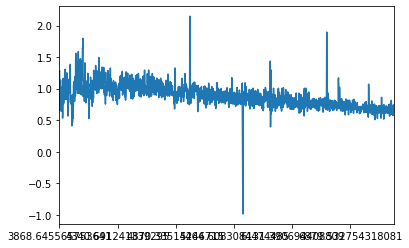

In [7]:
data.iloc[46].plot();

In [8]:
data.shape

(2920, 2877)

In [9]:
16030*100/(data.shape[0]*data.shape[1])

0.19081425190814252

Un 0,28% de todos los valores de frecuencias son negativos, es decir, erróneos (no puede haber cantidades de flux negativas, es decir "luz" negativa). Esto podría disminuir la confianza en la fiabilidad de los datos del dataset.

Además de haber bastantes valores erróneos, disminuyen mucho el valor mínimo de muchos espectros, haciendo que la estandarización que vamos a hacer después comprima demasiado los valores correctos (lo que hace que casi todos los espectros estandarizados "parezcan iguales".

Por esto, vamos a corregir la situación con la siguiente estrategia:

* Se eliminarán aquellos espectros que tengan dos o más valores negativos (se considerará que ha existido algún error de lectura que puede comprometer la fiabilidad de todo el espectro).
* En los restantes, se cambiará el único valor negativo por el valor correspondiente al continuum, tomando como tal el valor de la media móvil de 20 periodos en ese punto.

In [8]:
# Eliminamos los espectros con dos o más valores negativos
# Hay que eliminarlos también del dataset de origen, para así mantener el índice igual
for i in negativos:
    if i[1]>1:
        data.drop(i[0], axis=0, inplace=True)
        data_origen.drop(i[0], axis=0, inplace=True)
data.shape       

/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(2529, 2877)

In [9]:
data_origen.shape

(2529, 2881)

In [10]:
# Y ahora tratamos los espectros con un solo valor negativo. En estos casos, esa frecuencia tendrá el valor de
# flux mínimo del espectro

# Función recogida en StackOverFlow. Devuelve el valor de posición en el array más cercano al "target"
# Entradas: A, el array a considerar, y el target o valor a buscar.
# En este caso, hay que tener en cuenta que la frecuencia a buscar es el índice en el dataset
def find_closest(A, target): 
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx


# En esta función se calcula la media móvil con un número variable de peridos. Los parámetros de entrada son:
# - espectro, la pd.Serie con el espectro completo a corregir. Tiene como índice la frecuencia.
# - frecuencia, el valor de la frecucncia cuyo flux es negativo. Se corresponde con el mínimo de la "función
#   espectro". Debe llegar como float.
# - periodo, el de la media móvila considerar. Se tiene 20 por defecto (se ajusta bien al espectro medio)
def media_movil(espectro, frecuencia, periodo = 20):
    sma = espectro.rolling(periodo).mean() # sma es la media móvil de todo el espectro
    # Calculamos el valor de sma en la frecuencia dada
    if frecuencia < float(sma.index[periodo]):   # La Serie de sma no tiene valores para los primeros 20 valores
        frecuencia = float(sma.index[periodo])
    indice_sma = pd.to_numeric(sma.index)
    
    # Por alguna razón al tratar los índices y convertirlos de str a float, se producen errores al reconocer valores
    # en casos contados. Para evitarlo, tomamos el valor de frecuencia más cercano
    if frecuencia in indice_sma:
        # Tomamos como valor del flux el de la media móvil en la frecuencia problemática 
        return sma[indice_sma==frecuencia]
    else:
        # Es en estos casos cuando surge el error: tomamos el valor de la siguiente frecuencia a la problemática
        print("¡No esta!")
        frecuencia = float(sma.index[find_closest(indice_sma, frecuencia)+1])
        print(frecuencia)
        return sma[indice_sma==frecuencia]
    

In [11]:
# Aquí corregimos los valores de flux negativos por los de la media móvil, con la ayuda de la función definida
# Nos ayudamos del hecho de que, habiendo un solo negativo, éste será el valor mínimo
for i in range(len(data)):
    if any(data.iloc[i] < 0):
        data.iloc[i][data.iloc[i].index==data.iloc[i].idxmin()] = media_movil(data.iloc[i], float(data.iloc[i].idxmin()))[0]

¡No esta!
7330.9286507567385
¡No esta!
5316.904399416307
¡No esta!
5316.904399416307
¡No esta!
4905.225803249057
¡No esta!
7374.9477420074345
¡No esta!
5054.2767184851255


In [13]:
data.to_csv("./espectros_3k_sin_negativos.csv", columns=data.columns, index=False, header=True)

Para luego entrenar los modelos y tener un set de test para las medidas de accuracy, dividimos el dataset en train y test (nos vale un 15% para el test). Recordemos que estamos usando un aprendizaje no supervisado y no tenemos etiquetas.

In [12]:
espectros_train, espectros_test, _, _ = train_test_split(data, data, test_size=0.15, random_state=21)

Ahora podemos seguir con el proceso, primero estandarizando el dataset

In [13]:
scaler = MinMaxScaler() # = np.array(data.apply(lambda x: (x-x.min()) / (x.max()-x.min())))
scaler.fit(espectros_train)

# Grabamos el modelo de escalado para predicciones posteriores
joblib.dump(scaler, "./scaler.save") 

espectros_train_scaled = pd.DataFrame(scaler.transform(espectros_train), 
                               columns=espectros_train.columns,
                               index=espectros_train.index)
espectros_test_scaled = pd.DataFrame(scaler.transform(espectros_test),
                             columns=espectros_test.columns,
                             index=espectros_test.index)

# Esta es la versiós estandarizada de todo el dataset para comparaciones posteriores
espectros_scaled = pd.DataFrame(scaler.transform(data), 
                               columns=data.columns,
                               index=data.index)
espectros_train_scaled.head()

3868.645565753641  3869.535542582065  3870.4278489317717  \
1707           0.046789           0.053604            0.055648   
334            0.042870           0.043194            0.040441   
2775           0.064810           0.064128            0.061764   
844            0.009145           0.015278            0.016434   
2649           0.050363           0.050137            0.040907   

      3871.318235772099  3872.2109532069176  3873.1017502480395  \
1707           0.080071            0.121130            0.216539   
334            0.070471            0.121483            0.204035   
2775           0.088989            0.159838            0.342942   
844            0.039559            0.057916            0.073092   
2649           0.044138            0.068921            0.126393   

      3873.992752215851  3874.8860863882537  3875.777498840249  \
1707           0.318437            0.284345           0.345497   
334            0.310615            0.360696           0.359998   
2775           0.580944            0.519090           0.484695   
844            0.128701            0.150657           0.146439   
2649           0.269662            0.217585           0.251948   

      3876.671244571283  3877.563067696571  3878.45722517584  \
1707           0.396465           0.344769          0.438116   
334            0.363964           0.362744          0.308321   
2775           0.488673           0.531886          0.571345   
844            0.180500           0.144970          0.126449   
2649           0.372568           0.323101          0.263774   

      3879.3494591636186  3880.2440285808143  3881.136673620369  \
1707            0.598727            0.403784           0.356447   
334             0.308385            0.295374           0.328696   
2775            0.621236            0.540134           0.448696   
844             0.203931            0.159645           0.136049   
2649            0.303072            0.267825           0.261165   

      3882.029524011743  3882.924711445972  3883.8179731730975  \
1707           0.459577           0.469086            0.557151   
334            0.321506           0.312175            0.329325   
2775           0.386385           0.462894            0.529105   
844            0.191233           0.199765            0.212583   
2649           0.254204           0.209448            0.249550   

      3884.713573019754  3885.6072462721336  3886.503258721214  \
1707           0.471794            0.226492           0.392723   
334            0.342449            0.218515           0.236047   
2775           0.515576            0.330347           0.293290   
844            0.269124            0.208570           0.238112   
2649           0.302697            0.230748           0.157467   

      3887.3973436884376  3888.291634338733  3889.188265801773  \
1707            0.250423           0.113744           0.076077   
334             0.167798           0.105088           0.082040   
2775            0.200233           0.132326           0.109068   
844             0.123743           0.041154           0.033190   
2649            0.068220           0.034812           0.029188   

      3890.082968451347  3890.980012992077  3891.8751278307373  \
1707           0.080701           0.084587            0.117633   
334            0.072186           0.069745            0.133349   
2775           0.106123           0.102665            0.153158   
844            0.048609           0.051517            0.102152   
2649           0.041867           0.019875            0.040462   

      3892.772585639461  3893.668112857104  3894.5638460896052  \
1707           0.182735           0.287744            0.458418   
334            0.249583           0.357011            0.382920   
2775           0.278523           0.444874            0.611983   
844            0.179355           0.229873            0.297632   
2649           0.144059           0.169221            0.305624   

      3895.461923910823  3896.358069

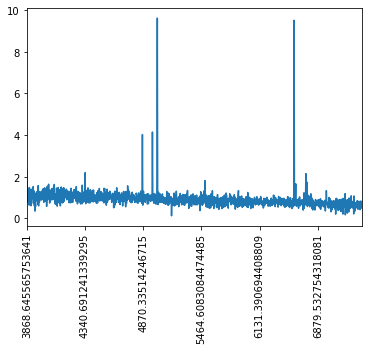

In [16]:
# Un espectro original cualquiera (el de índice 16 en este caso)
espectros_train.iloc[16].plot();
plt.xticks(rotation=90);

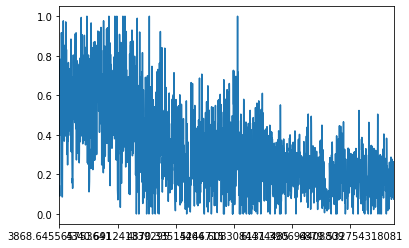

In [17]:
# El mismo espectro, pero con valores estandarizados
espectros_train_scaled.iloc[16].plot();

Después vamos a definir distintas posibilidades a probar con dim_latente y ver cual es la que da mejores resultados posteriormente al pasar por DBSCAN y sacar Silhouette coefficient. Sin embargo, primero vamos a hacer algo extremo y es definir n_latente como 2. Con ello, podremos representar bidimensionalmente la nube de espectros.

In [19]:
dim_latente = 2

In [20]:
espectros_train_scaled.shape

(2149, 2877)

In [53]:
dim_input = espectros_train_scaled.shape[1]
dim_input

2877

In [54]:
# Función para mostrar la gráfica de evolución de train loss y val loss en cada epoch durante el entrenamiento 
def grafica_loss(modelo, n_epochs):
    loss = modelo.history.history['loss']
    val_loss = modelo.history.history['val_loss']
    epochs = range(n_epochs)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Test loss')
    plt.title('Error de Training y Test')
    plt.legend()

### Autoencoder deep

Se han hecho pruebas con distintos tipos de autoencoder, siendo este modelo el que mejores resultados ha dado hasta el momento.

La idea es utilizar un autoencoder para reducir la dimensionalidad de los espectros y mejorar el rendimiento del posterior algoritmo de clustering.

Para este modelo de autoencoder, se ha probado com 'mse', pero parece que los mejores resultados siguen dándose con un error de tipo 'binary_crossentropy'. La optimización sigue siendo "adadelta" ("ada" da resultados mucho peores). En la capa de salida, la activación debe ser con sigmoid (otras provocan desestabilización de la red).

En cuanto al número de epochs, se pone 20, dado que la mejora en la parte final empieza ya a degradarse (ver gráfica de loss). Además, si nos pasamos en número de epochs, la red se desestabiliza en muchas ocasiones.

En cuanto a la arquitectura de capas ocultas, no parece que el rendimiento varíe mucho al disminuirlo considerablemente, incluso quitando una capa en el encoder y su simétrica en el decoder. Con esta arquitectura final se logra una muy ligera mejoría con respecto a una arquitectura mucho más sencilla.

En esta primera aproximación, vamos a utilizar dos variables en el espacio latente y así poder graficar el resultado. Posiblemente sea una reducción no válida, pero si útil para ver una primera representación y cómo puede resultar el clustering posterior.

In [215]:
epochs = 20

if entrenar:
    input = Input(shape=((dim_input, )))
    encoded = Dense(2000, activation='relu')(input)
    encoded = Dense(1000, activation='relu')(encoded)
    encoded = Dense(dim_latente, activation='relu')(encoded)
    decoded = Dense(1000, activation='relu')(encoded)
    decoded = Dense(2000, activation='relu')(decoded)
    decoded = Dense(dim_input, activation='sigmoid')(decoded)

    # Modelo para obtener el autoencoder completo
    autoencoder_deep = Model(input, decoded)
    
    # Modelo para obtener el espacio latente
    encoder = Model(input, encoded)
    
    autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])
    autoencoder_deep.fit(espectros_train_scaled, espectros_train_scaled,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(espectros_test_scaled, espectros_test_scaled))  
    grafica_loss(autoencoder_deep, epochs)
    autoencoder_deep.save('model_deep3k_lat_2.h5')
    encoder.save("model_encoder_deep3k_lat_2.h5")
    

else:
    autoencoder_deep = load_model('model_deep3k_lat_2.h5')
    encoder = load_model("model_encoder_deep3k_lat_2.h5")
    
autoencoder_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2877)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2000)              5756000   
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 2002      
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              3000      
_________________________________________________________________
dense_17 (Dense)             (None, 2000)              2002000   
_________________________________________________________________
dense_18 (Dense)             (None, 2877)              5756877   
Total para

/home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [36]:
# Este es el modelo con el que obtenemos la representación latente de los espectros del test_set
espectro_encoded = encoder.predict(espectros_test_scaled) 

# Esta es la salida del autoencoder, para comprobar si se parece a la entrada
espectro_decoded = autoencoder_deep.predict(espectros_test_scaled) 

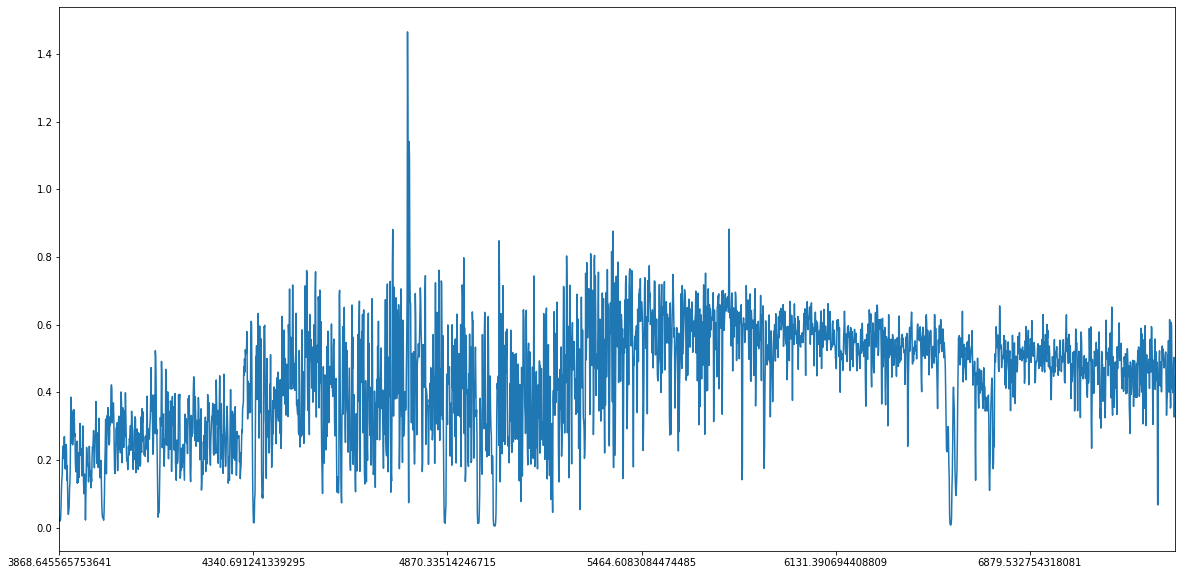

In [37]:
# Un espectro de entrada cualquier (en esta ocasión el de índice 100). recordemos que está estandarizado
plt.figure(figsize=(20, 10))
espectros_test_scaled.iloc[100].plot();

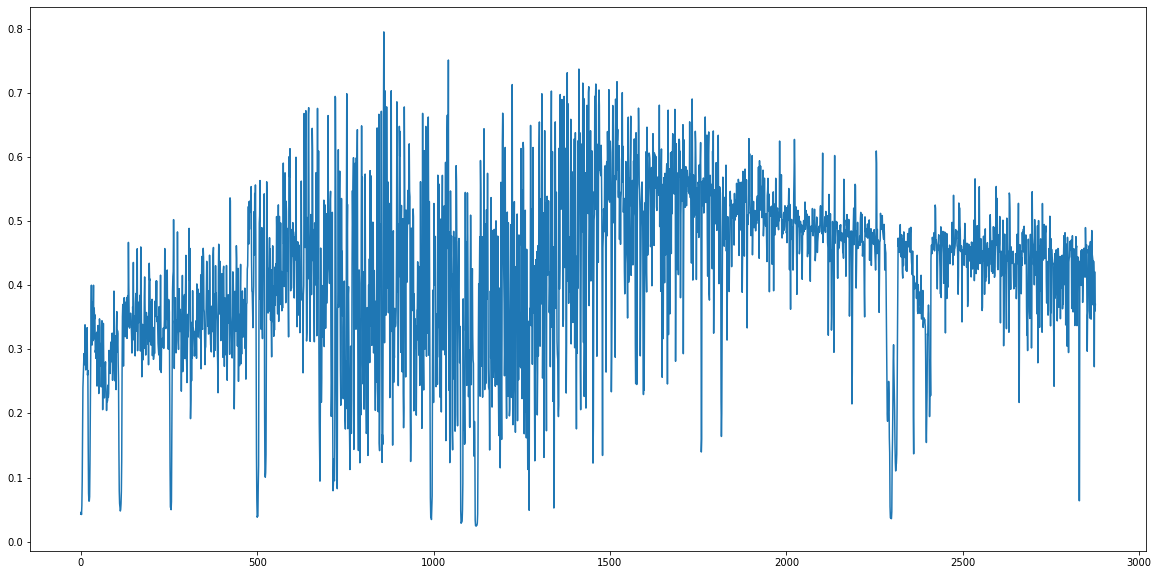

In [38]:
# Su reproducción por el decoder
plt.figure(figsize=(20, 10))
plt.plot(espectro_decoded[100]);

Hay que tener en cuenta que el autoencoder solo va a dar valores entre 0 y 1 y que en algunos casos la imagen de entrada tiene valores por encima de 1 (es decir, las escalas de las dos gráficas de arriba son diferentes, pero podemos fijarnos en que, aparte de los picos por encima de 1, el resto es muy parecido).

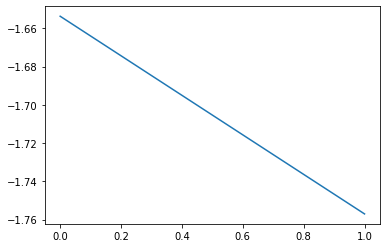

In [39]:
# La representación latente del mismo espectro
plt.plot(espectro_encoded[100]);

Por tanto vamos a usar el modelo anterior sobre todos los espectros de que disponemos (partiendo de todo el dataset estandarizado) y recoger la representanción latente de los mismos.

In [40]:
espectros_latentes = encoder.predict(espectros_scaled)

In [41]:
espectros_latentes

array([[-1.0332493, -1.7543956],
       [-0.9270865, -1.7526308],
       [-1.1855992, -1.7546307],
       ...,
       [-1.6745434, -1.7569027],
       [-1.3981637, -1.7554551],
       [-1.1409141, -1.7552946]], dtype=float32)

Visualizamos el resultado del espacio latente

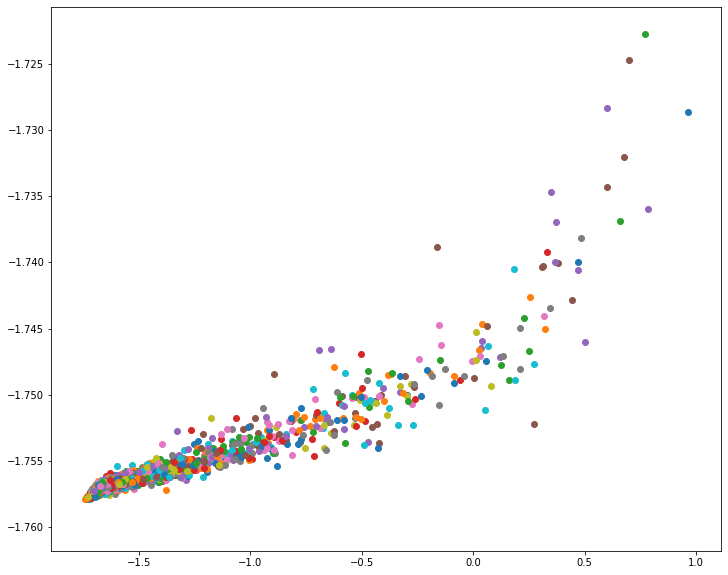

In [42]:
#from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for i in range(len(espectros_latentes)):
    ys = espectros_latentes[i][0]
    zs = espectros_latentes[i][1]
    ax.scatter(ys, zs)


Con más dimensiones pasará algo parecido. Tenemos una nube de la que es difícil sacar clusters, pero si podemos sacar outliers.

Ahora vamos a volver a entrenar el modelo del autoencoder, pero esta vez creando un pipeline con que probemos con distintos valores de dim_latente (al estilo de GridSearchCV en sklearn). Después, con el espacio latente resultante, aplicamos Silhouette para un rango de número de clusters y qué puntuación sale. Repetimos esta segmentación varias veces para cada vez y finalmente cogemos la media de estas repeticiones (así podremos combatir la aleatoriedad del proceso).

Con ello, podremos escoger mejor el dim_latentes óptimo (donde el valor de Silhouette sea máximo).

In [18]:
grid_dim_latente = [3, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 500]
epochs = 30
historial = []
num_max_clusters = 10 
intentos_clustering = 40

In [146]:
for dim_latente in grid_dim_latente:
    print("\n")
    print("****** Dimensión del espacio latente:", dim_latente)
    
    input = Input(shape=((dim_input, )))
    encoded = Dense(2000, activation='relu')(input)
    encoded = Dense(1000, activation='relu')(encoded)
    encoded = Dense(dim_latente, activation='relu')(encoded)
    decoded = Dense(1000, activation='relu')(encoded)
    decoded = Dense(2000, activation='relu')(decoded)
    decoded = Dense(dim_input, activation='sigmoid')(decoded)

    # Modelo para obtener el autoencoder completo
    autoencoder_deep = Model(input, decoded)
    
    # Modelo para obtener el espacio latente
    encoder = Model(input, encoded)
    
    autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])
    autoencoder_deep.fit(espectros_train_scaled, espectros_train_scaled,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(espectros_test_scaled, espectros_test_scaled))  
  
    espectros_latentes = encoder.predict(espectros_train_scaled)
    
    # Calculamos Silhouette    
    print("Calculando índices Silhouette para " + str(dim_latente) + " variables")

    coefs_para_dim_n = np.zeros((num_max_clusters, intentos_clustering, 3))
    for k in range(2, num_max_clusters, 1):
        print ("Probando GMM para " + str(k) + " clusters")
        # Repetimos el entrenamiento de clustering varias veces por la naturaleza aleatoria del proceso.
        # Luego cogemos la media de todos los intentos
        for intento in range(intentos_clustering): 
            clustering = GaussianMixture(n_components=k)
            cluster_labels = clustering.fit_predict(espectros_latentes)

            silhouette_avg = silhouette_score(espectros_latentes, cluster_labels)
            coefs_para_dim_n[k][intento] = (dim_latente, k, silhouette_avg)

    # Con este formato podremos recuperar el top 3 para todos los valores de las dimensiones que probemos
    historial.append(sorted(coefs_para_dim_n.mean(axis=1), key=lambda x: x[2], reverse= True)[:1]) 
    
print ("¡Terminado!")
    
   



****** Dimensión del espacio latente: 3
Train on 2149 samples, validate on 380 samples
Epoch 1/30


KeyboardInterrupt: 

In [20]:
historial

[[array([3.        , 3.        , 0.49199636])],
 [array([5.        , 3.        , 0.26633786])],
 [array([10.       ,  2.       ,  0.6430071])],
 [array([20.        ,  2.        ,  0.54638249])],
 [array([50.        ,  2.        ,  0.61914492])],
 [array([100.        ,   2.        ,   0.59031713])],
 [array([150.        ,   2.        ,   0.60250175])],
 [array([200.        ,   2.        ,   0.63020366])],
 [array([250.        ,   2.        ,   0.65427697])],
 [array([300.        ,   2.        ,   0.64574945])],
 [array([350.        ,   2.        ,   0.65357196])],
 [array([400.       ,   2.       ,   0.6463002])],
 [array([500.        ,   2.        ,   0.65110236])]]

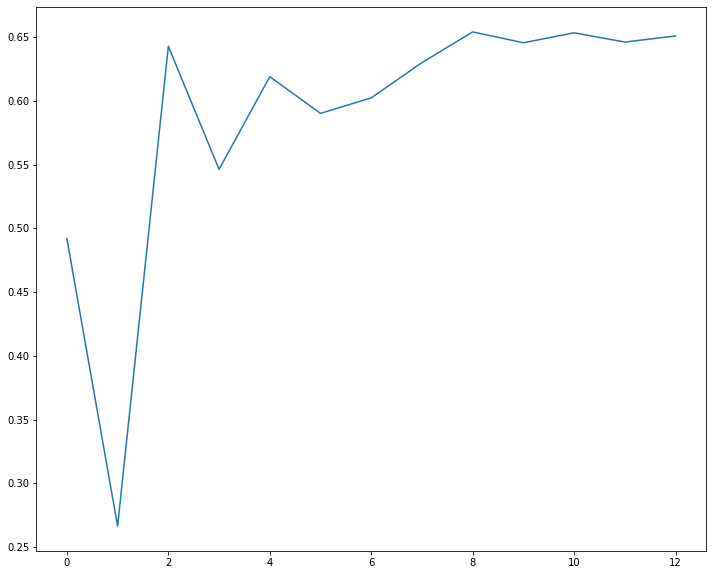

In [36]:
fig = plt.figure(figsize=(12,10))
plt.plot([historial[i][0][2] for i in range(len(historial))]) 

Con estos resultados, lo primero que vemos es que el número óptimo de clusters es 2 en todos los casos (y porque es el valor mínimo de clusters que hemos impuesto).

Después, resulta sorprendente la alta puntuación para valores muy altos de dimensión latente. De todas formas, las diferencias entre los distintos valores son mínimas, con lo que, en realidad, cualquier valor sería válido.

El valor óptimo según este análisis es 250 variables y por tanto será este el valor que utilizaremos después con los algoritmos de clustering (se ha repetido este análisis múltiples ocasiones, con resultados distintos, pero donde el máximo del coeficiente silhouette siempre está entre las 150 y las 300 dimensiones).

Volvemos a entrenar la red, esta vez con nuestro valor óptimo de variables en el espacio latente.

In [14]:
if entrenar:

    dim_latente = 250
    dim_input = espectros_train_scaled.shape[1]
    epochs = 30

    input = Input(shape=((dim_input, )))
    encoded = Dense(1000, activation='relu')(input)
    encoded = Dense(500, activation='relu')(encoded)
    encoded = Dense(dim_latente, activation='relu')(encoded)
    decoded = Dense(500, activation='relu')(encoded)
    decoded = Dense(1000, activation='relu')(decoded)
    decoded = Dense(dim_input, activation='sigmoid')(decoded)

    autoencoder_deep = Model(input, decoded)
    encoder = Model(input, encoded)
    
    autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])
    autoencoder_deep.fit(espectros_train_scaled, espectros_train_scaled,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(espectros_test_scaled, espectros_test_scaled))  

    autoencoder_deep.save('model_deep3k_lat_250.h5')
    encoder.save("model_encoder_deep3k_lat_250.h5")
else:
    encoder = load_model("model_encoder_deep3k_lat_250.h5")
    
espectros_latentes = encoder.predict(espectros_scaled)

W0825 13:40:53.908375 139659545720640 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 13:40:53.941922 139659545720640 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 13:40:54.058124 139659545720640 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0825 13:40:54.059504 139659545720640 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigPr

## Aplicación de algoritmos de clustering

## 1.- DBSCAN

DBSCAN tiene dos parámetros:

* eps, que es la distancia mínima para considerar a dos muestras como del mismo cluster
* min_samples, que es el número de muestras mínimo que debe contener un cluster.

Cuando una muestra no llegue al número mínimo del clusters, se considerará outlier y DBSCAN la etiquetará como -1.

Para ajustar mejor el parámetro eps, vamos a ir probando con un bucle que recorra eps desde 0,1 a 5 y visualizar los resultados. Intentamos maximizar el número de clusters sin que se dispare el número de outliers.

In [17]:
num_clusters = []
num_outliers = []
rango = np.arange (0.1, 5, 0.01)
for eps in rango:
    clustering = DBSCAN(eps=eps, min_samples=2, n_jobs=-1).fit(espectros_latentes)
    labels = np.unique(clustering.labels_, return_counts=True)
    num_clusters.append(len(labels[0]))
    num_outliers.append(labels[1][0])              

KeyboardInterrupt: 

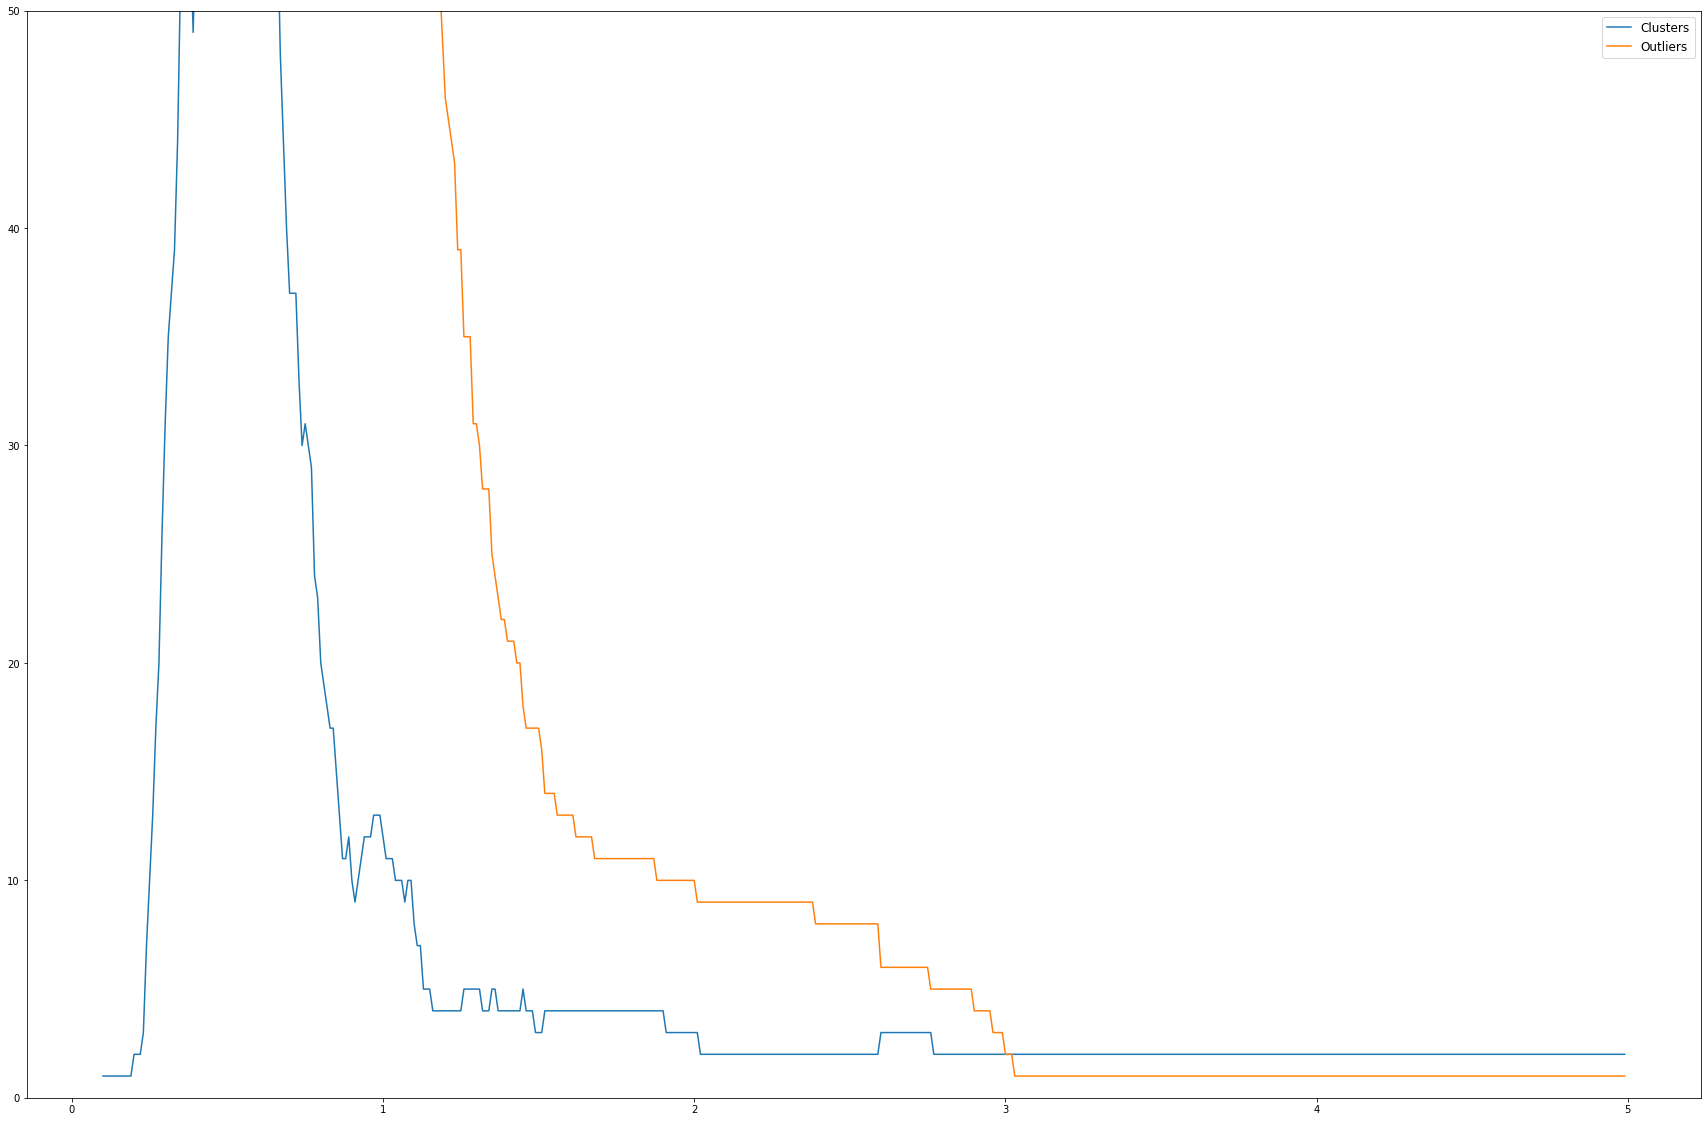

In [241]:
plt.figure(figsize=(30, 20));
plt.plot(rango, num_clusters, label="Clusters");
plt.plot(rango, num_outliers, label="Outliers");
plt.ylim(top=50, bottom=0);
plt.legend(prop={'size': 12});

In [15]:
clustering = DBSCAN(eps=1.8, min_samples=2, n_jobs=-1).fit(espectros_latentes)
labels_DBSCAN = np.unique(clustering.labels_, return_counts=True)
labels_DBSCAN

(array([-1,  0,  1,  2]), array([  11, 2514,    2,    2]))

Como ocurre en varios experimentos con DBSCAN (o GMM), y como avanzaba la representación gráfica realizada con el modelo de 2 variables en el espacio latente, sale un número bajo de clusters (sin permitir que se dispare el número de outliers), y todas las muestras caen en uno solo de los clusters, excepto 2 o 3 que caen en los otros.

Es decir, no vamos a obtener clusters significativos, pero podemos sacar outliers con cierta facilidad (en este caso salen 11, aunque podríamos ajustar el valor de eps para obtener el número que consideremos más adecuado). Otra cosa es que estos outliers sean interesantes, lo  que deberemos exponer al juicio del IAC.

#### Visualización de clusters resultantes

Vamos a dibujar los 10 primeros ejemplos dentro de cada cluster, representado primero los espectros latentes, luego los estandarizados y por último los originales sin estandarizar.

Lo haremos igual para cada cluster.

In [16]:
clusters_DBSCAN = []
for i in range(-1,len(labels_DBSCAN[0]), 1): # Empezamos en -1 para coger también los outliers, en el índice 0 del array labels
    clusters_DBSCAN.append(np.where(clustering.labels_==i))

In [17]:
clusters_DBSCAN

[(array([  37,  274,  279,  360,  432, 1202, 1401, 1713, 1979, 2451, 2525]),),
 (array([   0,    1,    2, ..., 2526, 2527, 2528]),),
 (array([1115, 1126]),),
 (array([1365, 2520]),),
 (array([], dtype=int64),)]

In [45]:
# Función para representar las tres gráficas de varios elementos de un cluster (stack vertical)

def grafica_cluster(cluster, num_graf=10):
    print("Cluster: ", cluster)
    
    plt.figure(figsize=(20, 50))

    # Si el cluster tiene menos de 10 unidades, dará error al intentar representarlo. Corregimos esto.
    if len(clusters[cluster][0]) < num_graf:
        num_graf2 = len(clusters[cluster][0])
    else:
        num_graf2 = num_graf
    
    for n in range(num_graf2):
        # Gráficas de los espectros latentes
        ax = plt.subplot(num_graf2*3, 1, n+1)
        plt.plot(espectros_latentes[clusters[cluster][0][n-1]])
        plt.title("Latentes")
        # Gráficas de los espectros originales estandarizados
        bx = plt.subplot(num_graf2*3, 1, (n+1+num_graf2))
        espectros_scaled.iloc[clusters[cluster][0][n-1]].plot()
        plt.title("Estandarizados")
        # Gráficas de los espectros originales sin estandarizar
        cx = plt.subplot(num_graf2*3, 1, (n+1+(num_graf2*2)))
        data.iloc[clusters[cluster][0][n-1]].plot()
        plt.title("Sin estandarizar")
        plt.savefig('espectros.png')
    

In [18]:
# Función para representar las tres gráficas de varios elementos de un cluster (stack horizontal)
# Entradas: 

# - cluster, número de cluster a visualizar
# - clusters, array con los clusters definidos
# - num_graf, número de espectros a mostrar dentro del cluster elegido


def grafica_cluster2(cluster, clusters, num_graf=10):
    print("Cluster: ", cluster)
    
    # Si el cluster tiene menos de 10 unidades, dará error al intentar representarlo. Corregimos esto.
    if len(clusters[cluster][0]) < num_graf:
        num_graf2 = len(clusters[cluster][0])
    else:
        num_graf2 = num_graf
    
    for n in range(1, num_graf2+1):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(17, 20)
        # Gráficas de los espectros latentes
        ax1 = plt.subplot(num_graf2, 3, (n*3)-2)
        ax1.plot(espectros_latentes[clusters[cluster][0][n-1]])
        plt.title("Latentes")
        # Gráficas de los espectros originales estandarizados
        ax2 = plt.subplot(num_graf2, 3, (n*3)-1)
        espectros_scaled.iloc[clusters[cluster][0][n-1]].plot()
        plt.title("Estandarizados")
        # Gráficas de los espectros originales sin estandarizar
        ax3 = plt.subplot(num_graf2, 3, (n*3))
        data.iloc[clusters[cluster][0][n-1]].plot()
        plt.title("Originales")
        #plt.savefig('espectros.png')

Cluster:  0


array([  37,  274,  279,  360,  432, 1202, 1401, 1713, 1979, 2451, 2525])

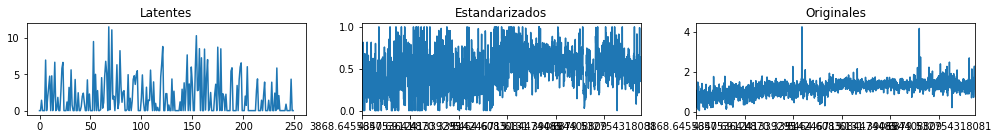

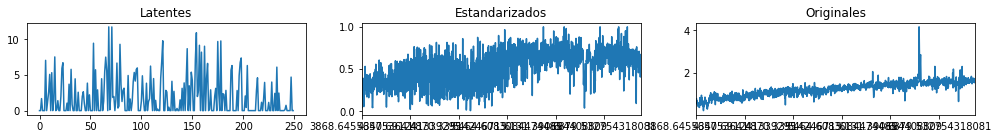

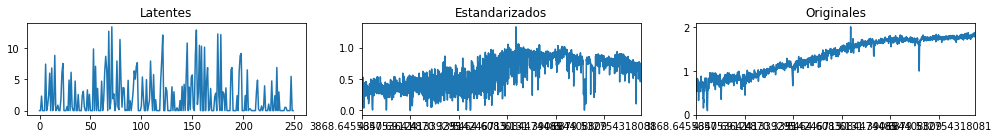

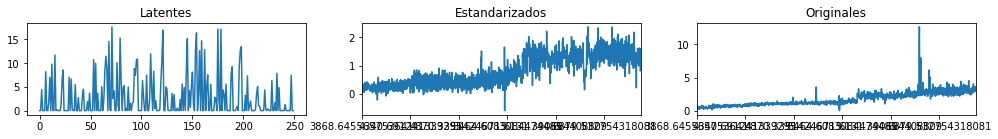

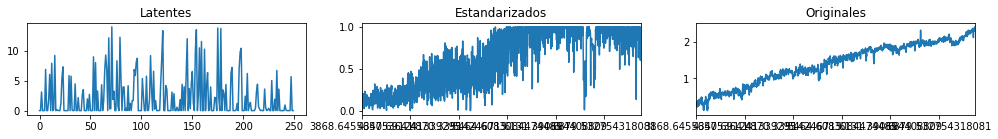

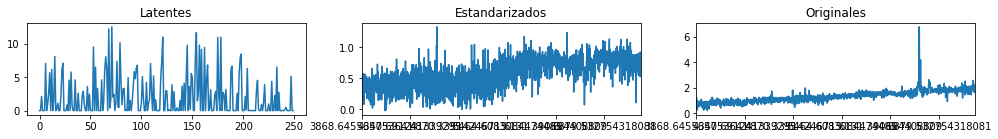

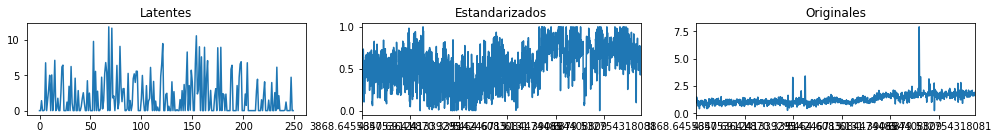

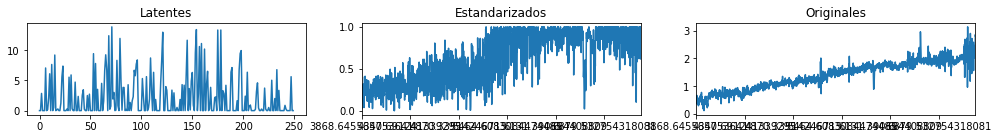

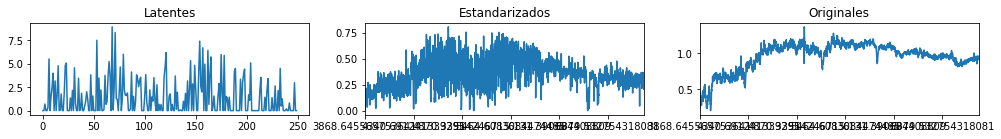

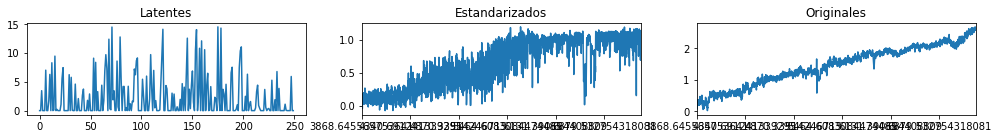

In [246]:
# Outliers (label = -1, index en array "cluster" = 0)
grafica_cluster2(0, clusters_DBSCAN)
clusters_DBSCAN[0][0]

Cluster:  1


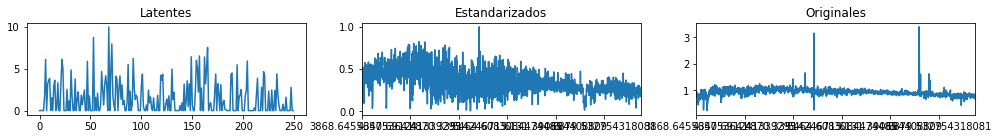

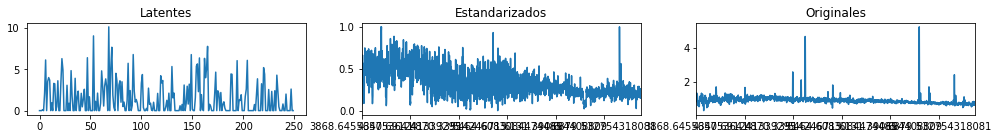

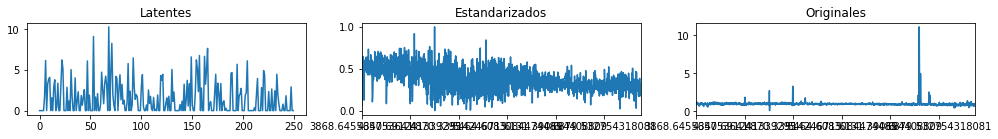

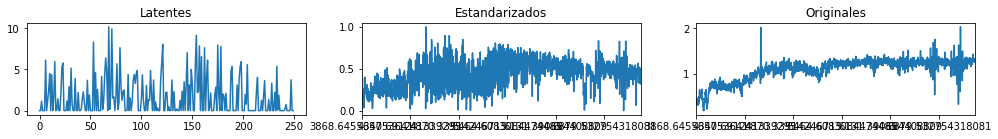

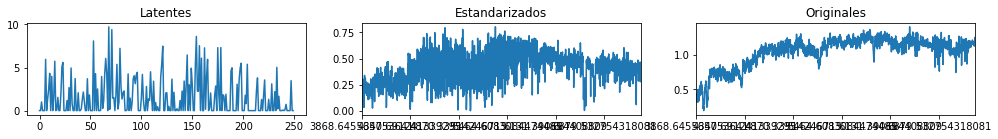

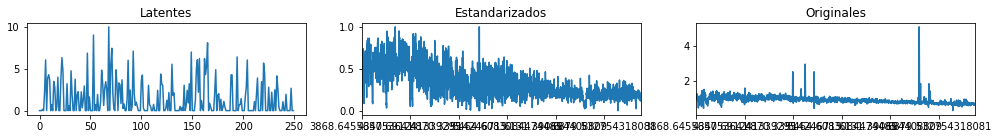

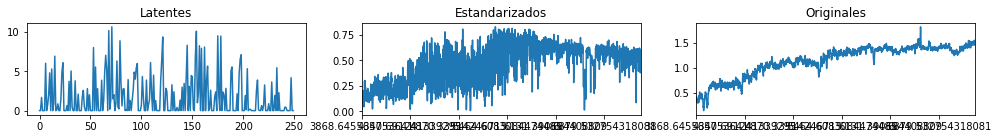

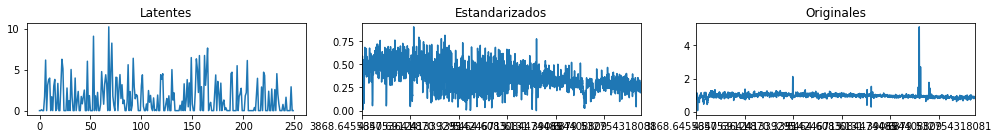

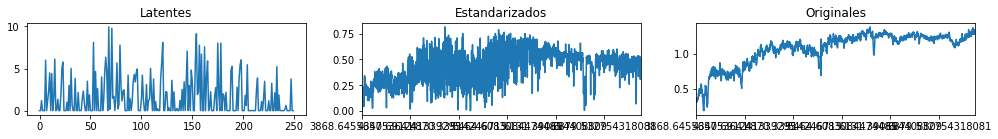

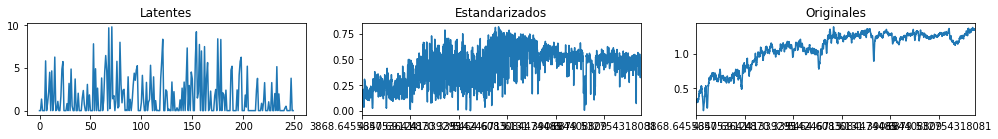

In [49]:
# Grupo label = 0 (index 1)
grafica_cluster2(1, clusters_DBSCAN)

Cluster:  2


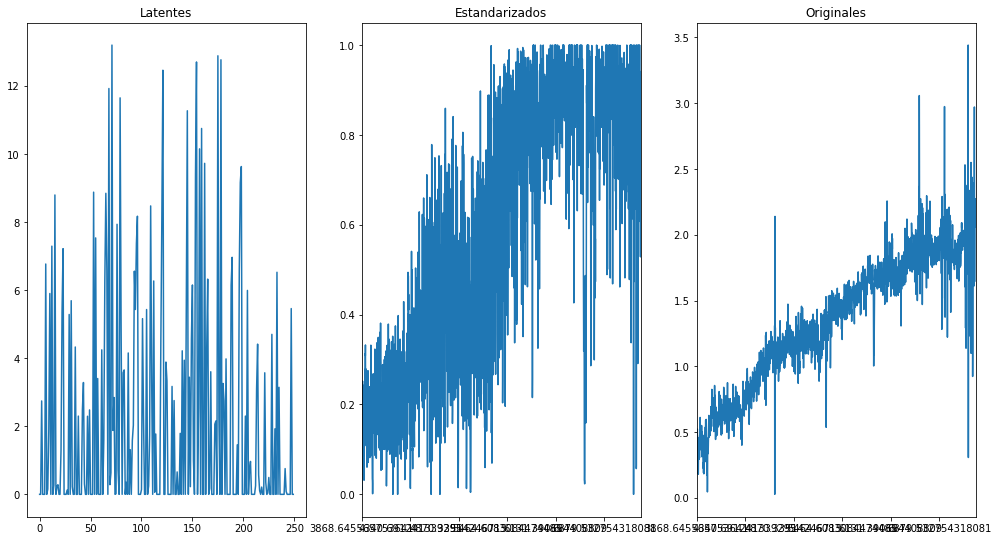

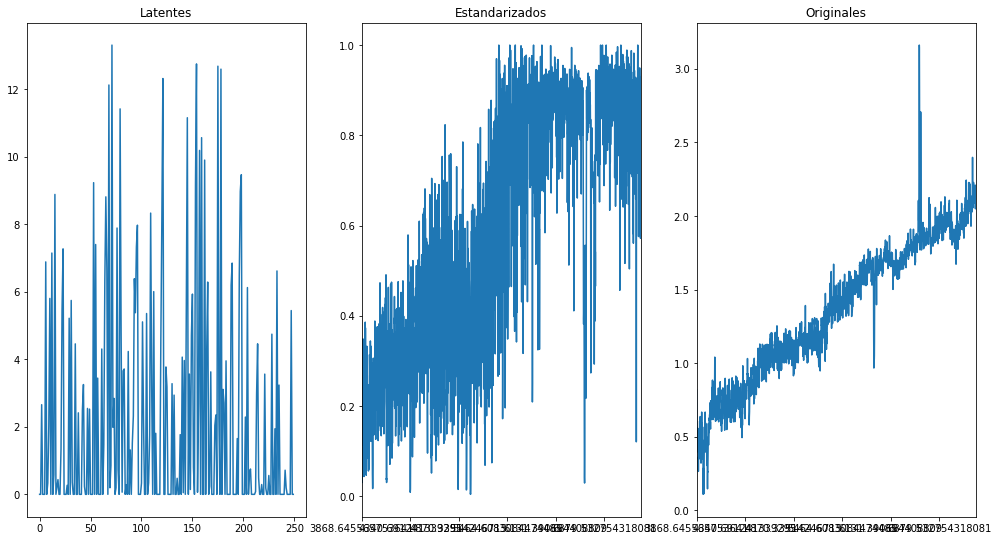

In [50]:
# Grupo label = 1 (index 2)
grafica_cluster2(2, clusters_DBSCAN)

En el uso de DBSCAN, podemos aprovechar la facilidad para la extracción de outliers y sus resultados no dependen en absoluto de la aleatoriedad. Pero no extrae clusters en una nube como la nuestra.

Volvemos a los outliers para analizarlos con más detalle, extrayendo los valores de identificación de los mismos y extrayendo los espectros originales de SDSS.

In [100]:
clusters_DBSCAN[0][0]

array([  37,  274,  279,  360,  432, 1202, 1401, 1713, 1979, 2451, 2525])

In [101]:
for i in clusters_DBSCAN[0][0]:
    print(data_origen.iloc[i][:4])

PLATE     1030.000000
MJD      52914.000000
FIBER      606.000000
Z            0.122876
Name: 48, dtype: float64
PLATE     3862.000000
MJD      55276.000000
FIBER      323.000000
Z            0.232966
Name: 319, dtype: float64
PLATE     1251.000000
MJD      52964.000000
FIBER       85.000000
Z           -0.000093
Name: 326, dtype: float64
PLATE     7261.000000
MJD      56603.000000
FIBER      738.000000
Z            0.086015
Name: 415, dtype: float64
PLATE     1254.000000
MJD      52972.000000
FIBER      226.000000
Z            0.017982
Name: 498, dtype: float64
PLATE     6511.000000
MJD      56540.000000
FIBER      233.000000
Z            0.206336
Name: 1385, dtype: float64
PLATE     6036.000000
MJD      56093.000000
FIBER      523.000000
Z            0.226707
Name: 1614, dtype: float64
PLATE     4376.000000
MJD      55863.000000
FIBER       12.000000
Z            0.133735
Name: 1970, dtype: float64
PLATE     2208.000000
MJD      53880.000000
FIBER      218.000000
Z            0.12544

In [152]:
def grafOutlier(dataset, cluster, orden):
    filtro1 = [x for x in data_origen.columns[4:] if ((float(x) >= 6480) & (float(x) <= 6650))]
    filtro2 = [x for x in data_origen.columns[4:] if ((float(x) >= 4800) & (float(x) <= 5050))]
    filtro3 = [x for x in data_origen.columns[4:] if ((float(x) >= 5150) & (float(x) <= 5200))]
    
    print("----------\n")
    print(data_origen.iloc[cluster[orden]][:4])
    
    plt.figure(figsize=(30, 20));
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    data_origen[data_origen.columns[4:]].iloc[cluster[orden]].plot();
    plt.figure(figsize=(30, 20));
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    data_origen.filter(filtro1, axis=1).iloc[cluster[orden]].plot();
    plt.figure(figsize=(30, 20));
    plt.xticks(fontsize=15, rotation=90)
    plt.yticks(fontsize=20)
    data_origen.filter(filtro2, axis=1).iloc[cluster[orden]].plot();

In [32]:
#Imagen original del espectro desde SDSS
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=1159843528948344832", width=800, height=640)

----------

PLATE     1030.000000
MJD      52914.000000
FIBER      606.000000
Z            0.122876
Name: 48, dtype: float64


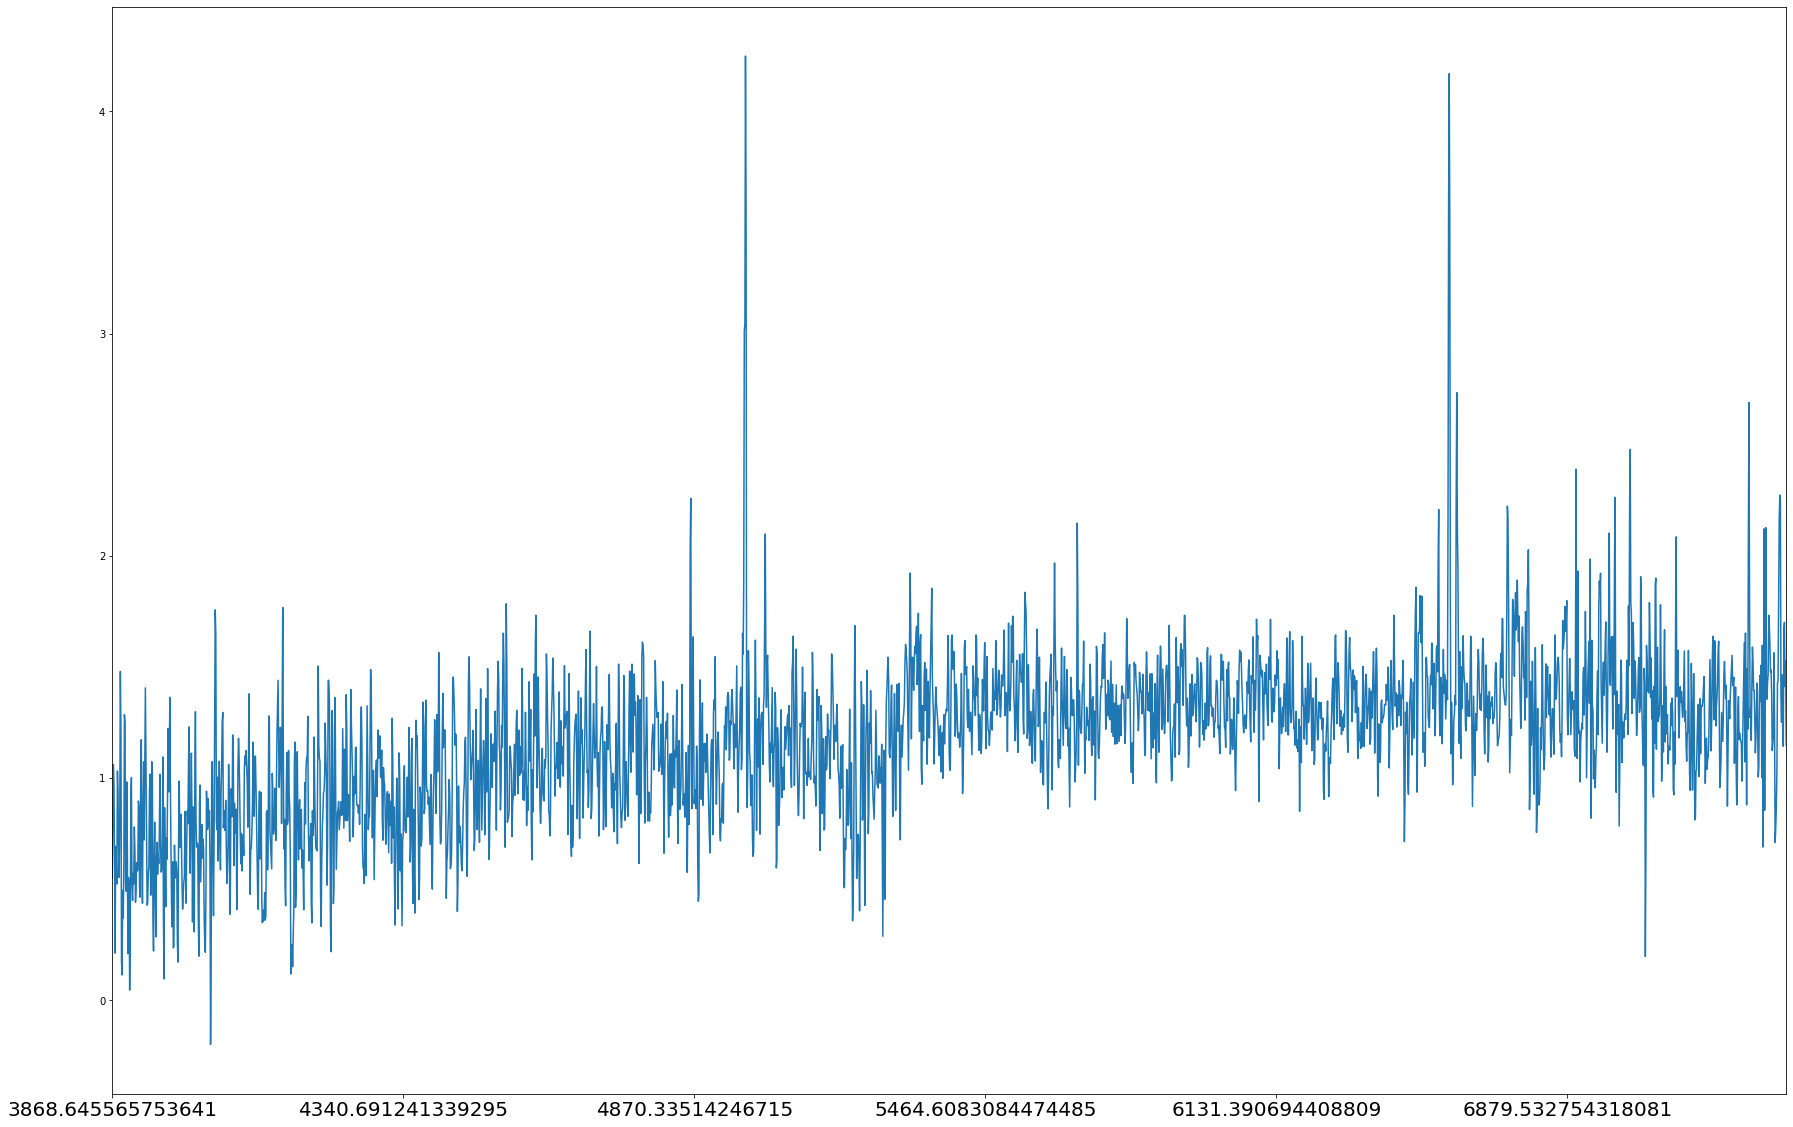

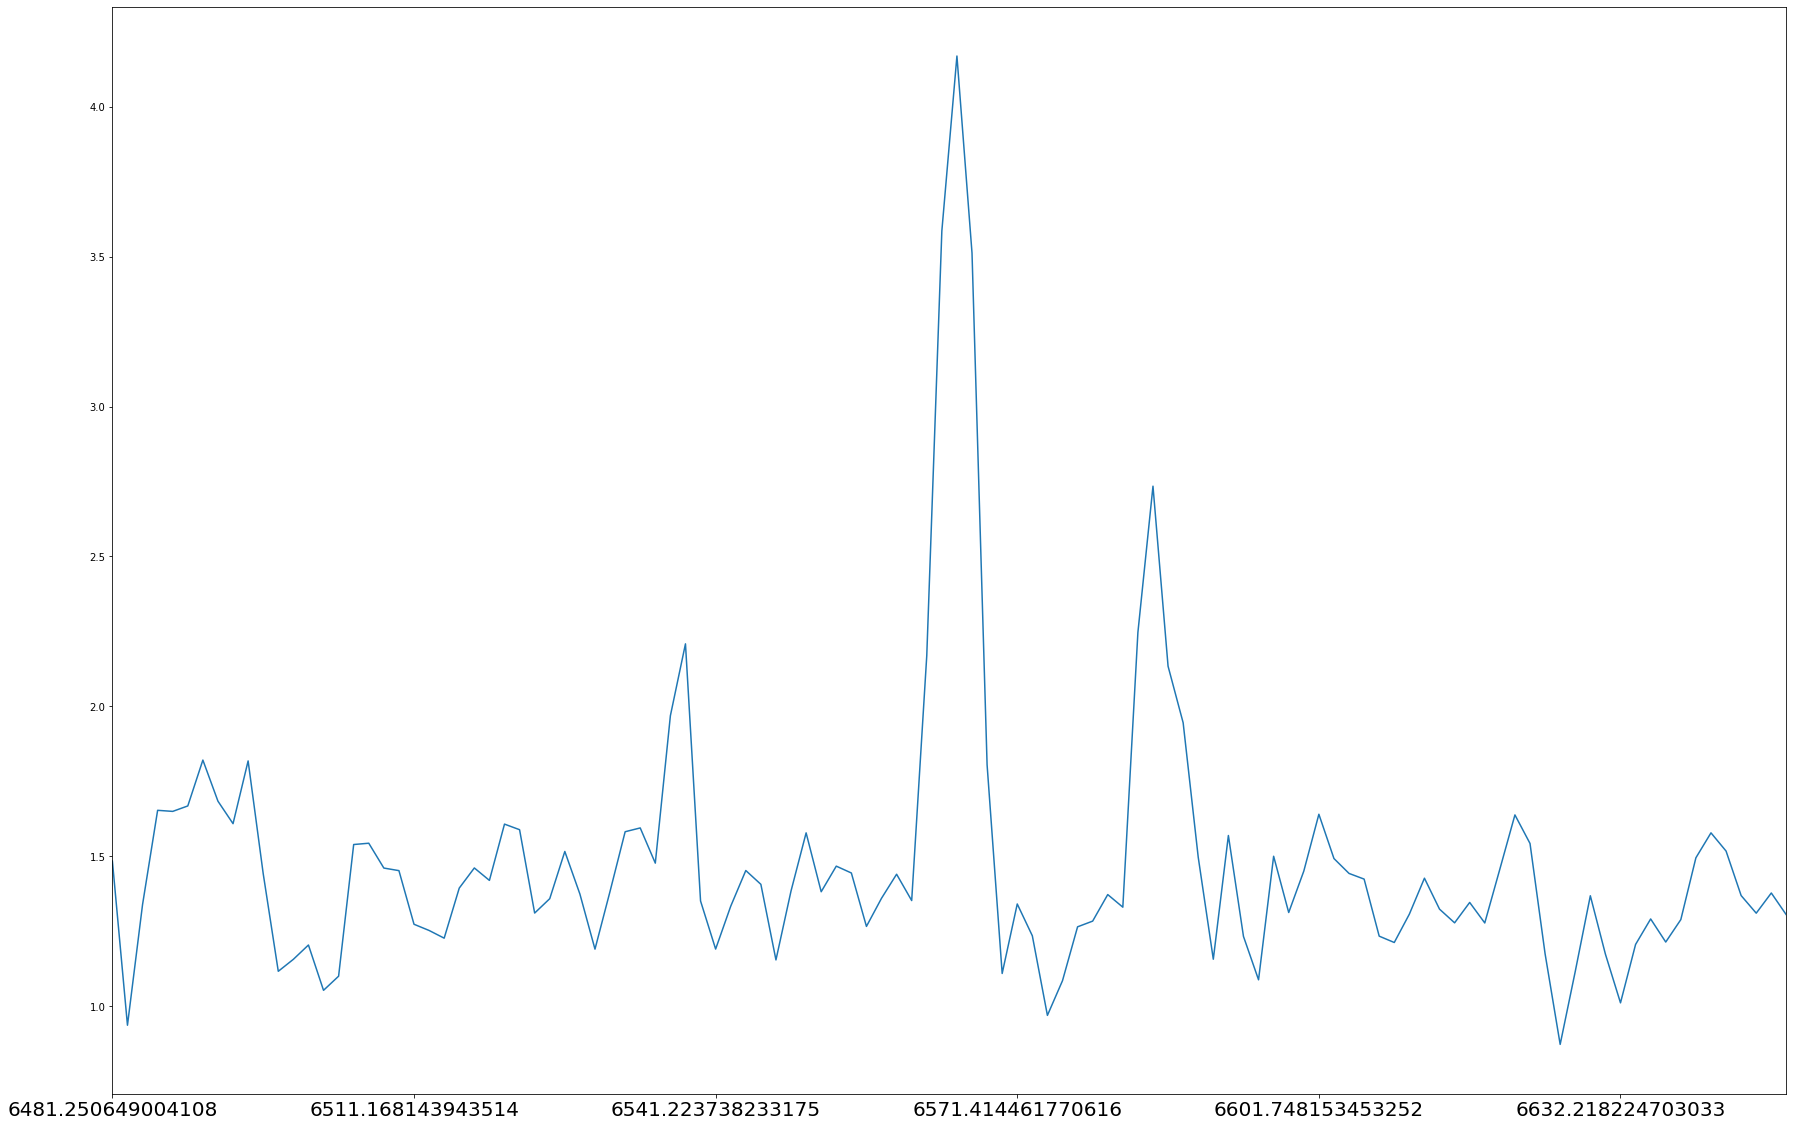

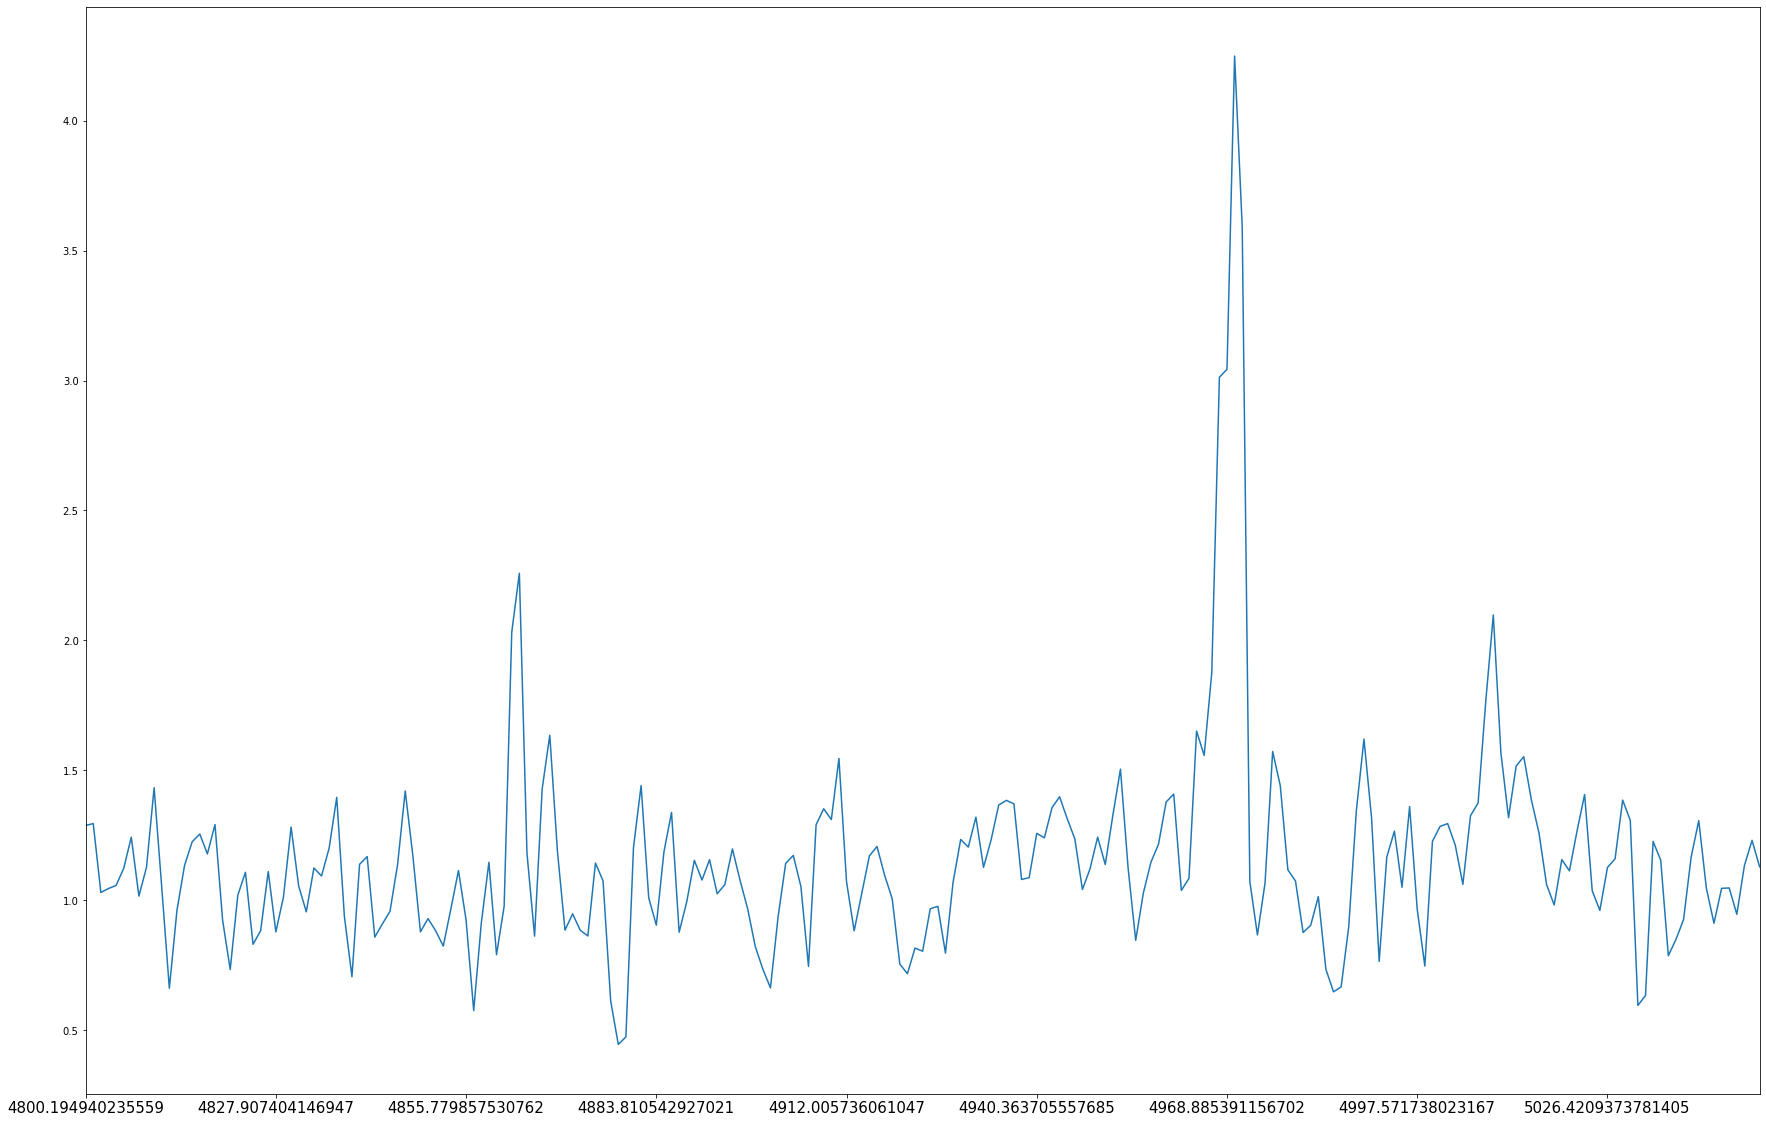

In [146]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 0)

In [33]:
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=4348314314307772416", width=800, height=640)   

----------

PLATE     3862.000000
MJD      55276.000000
FIBER      323.000000
Z            0.232966
Name: 319, dtype: float64


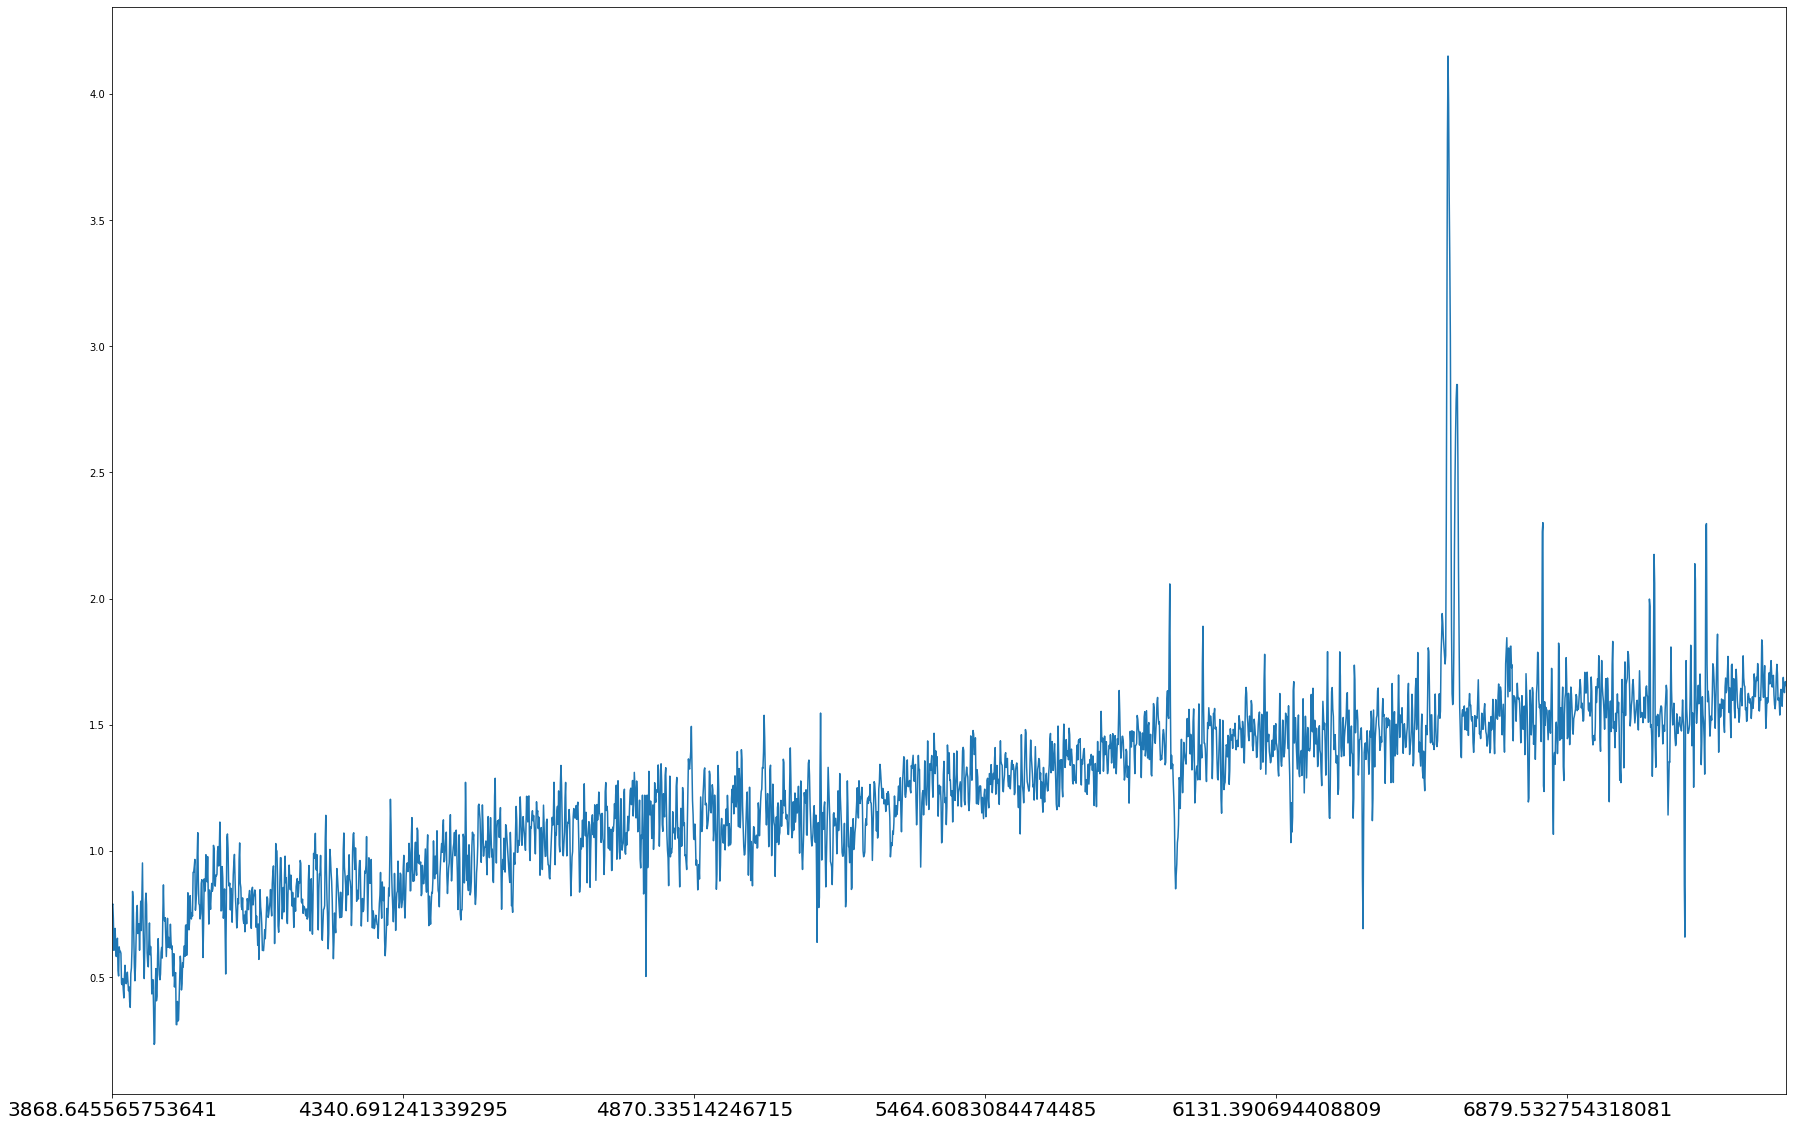

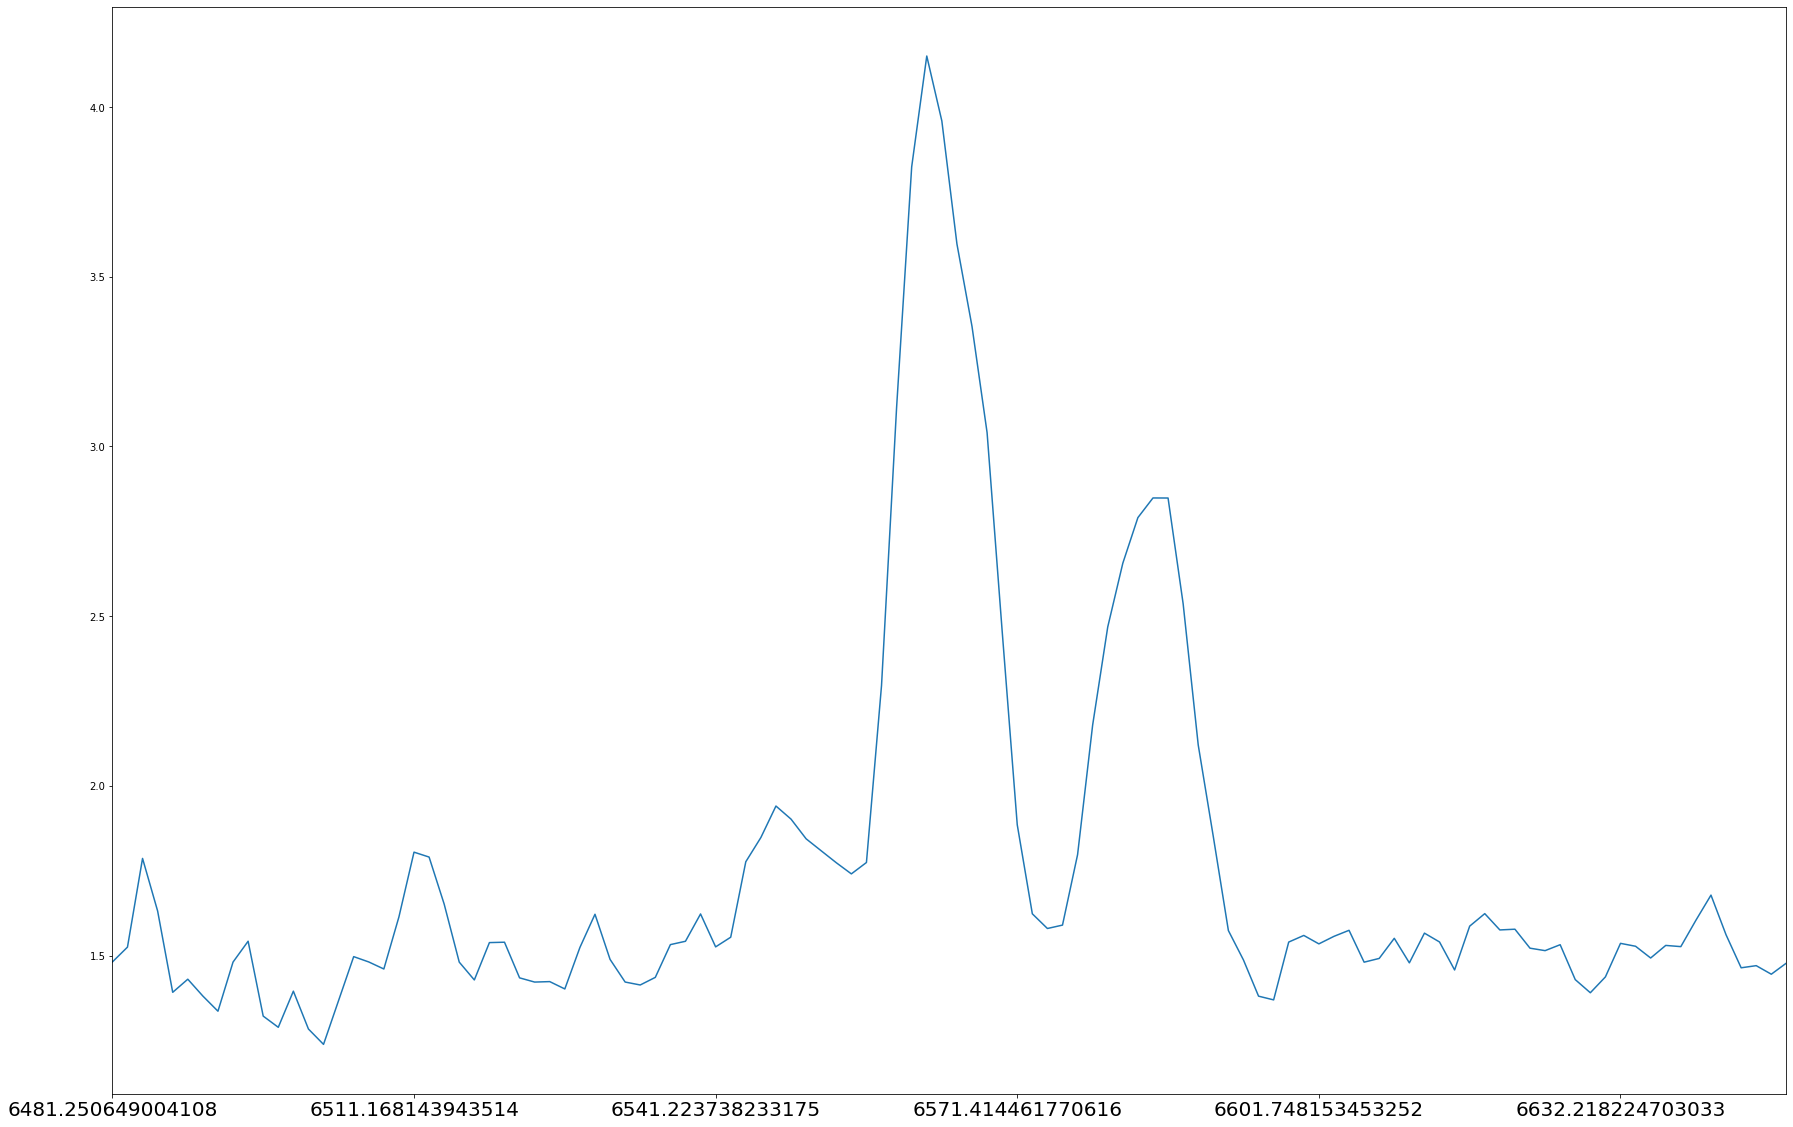

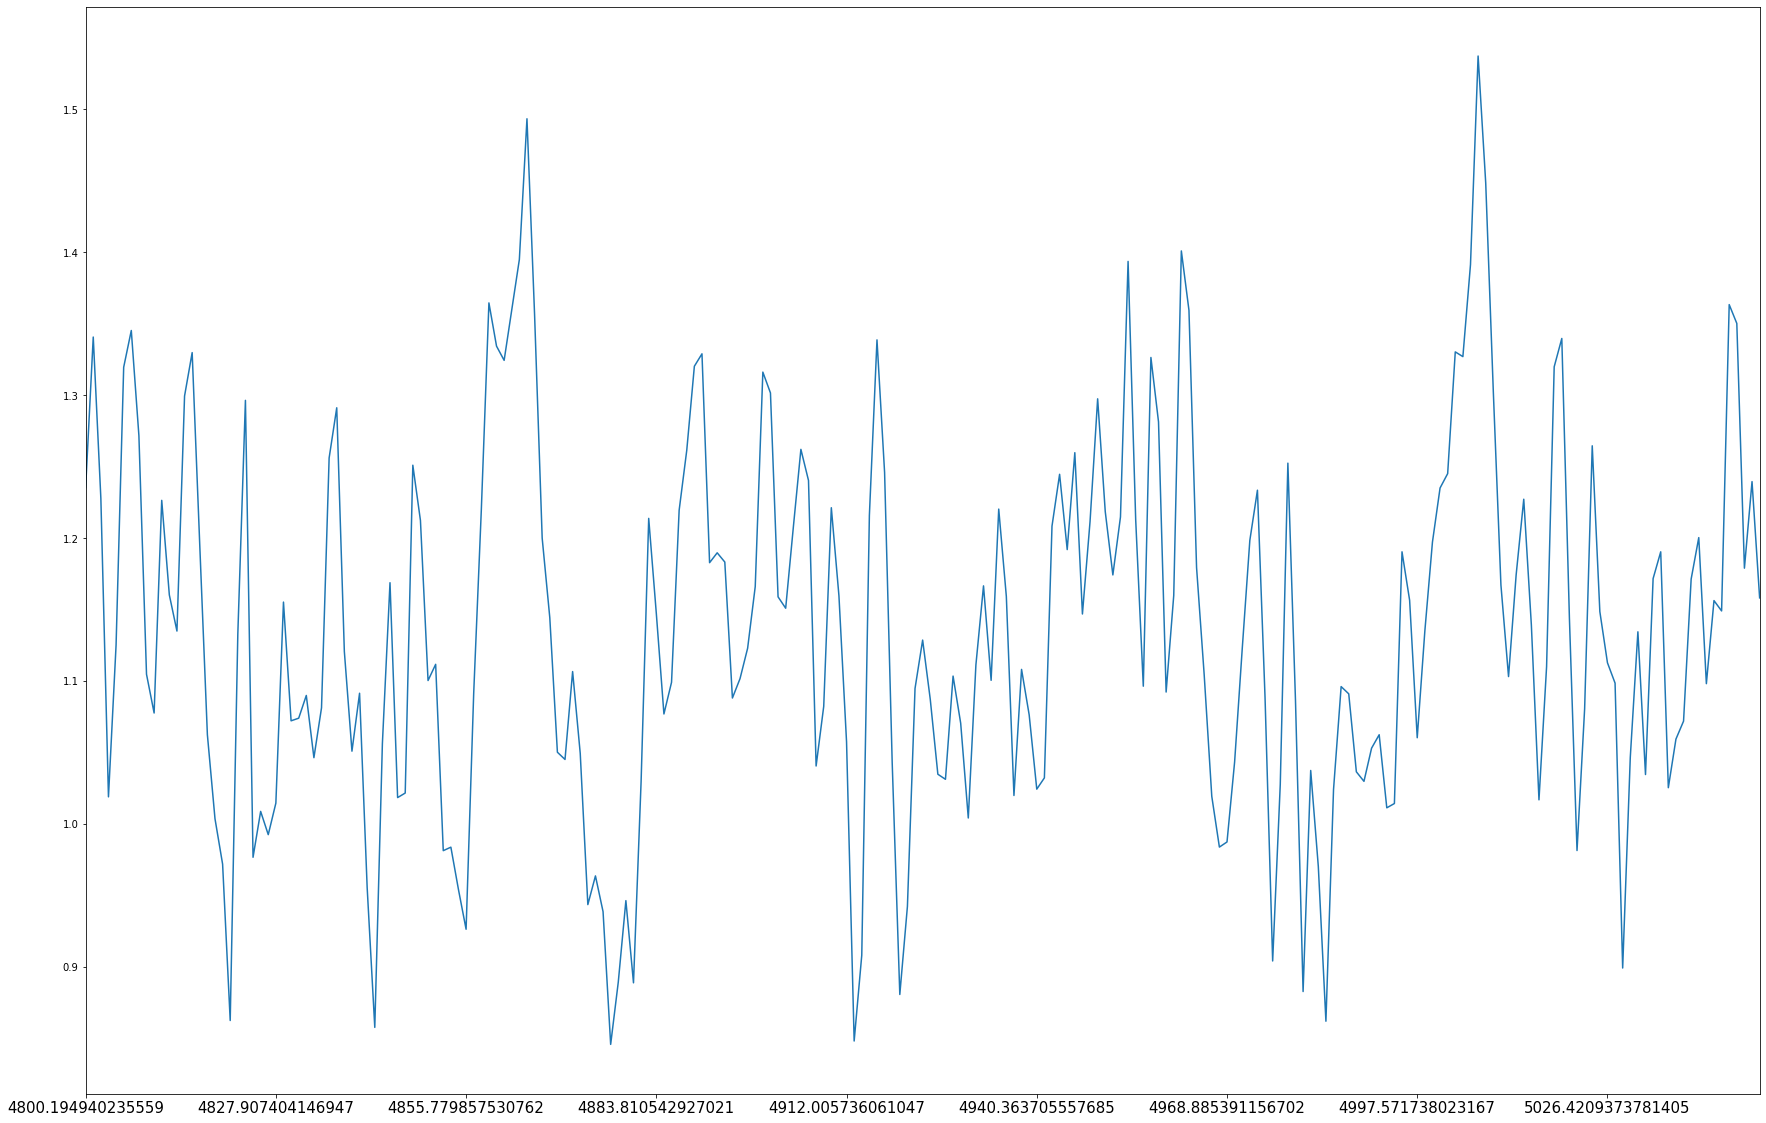

In [147]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 1)

In [34]:
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=1408524197809907712", width=800, height=640)

----------

PLATE     1251.000000
MJD      52964.000000
FIBER       85.000000
Z           -0.000093
Name: 326, dtype: float64


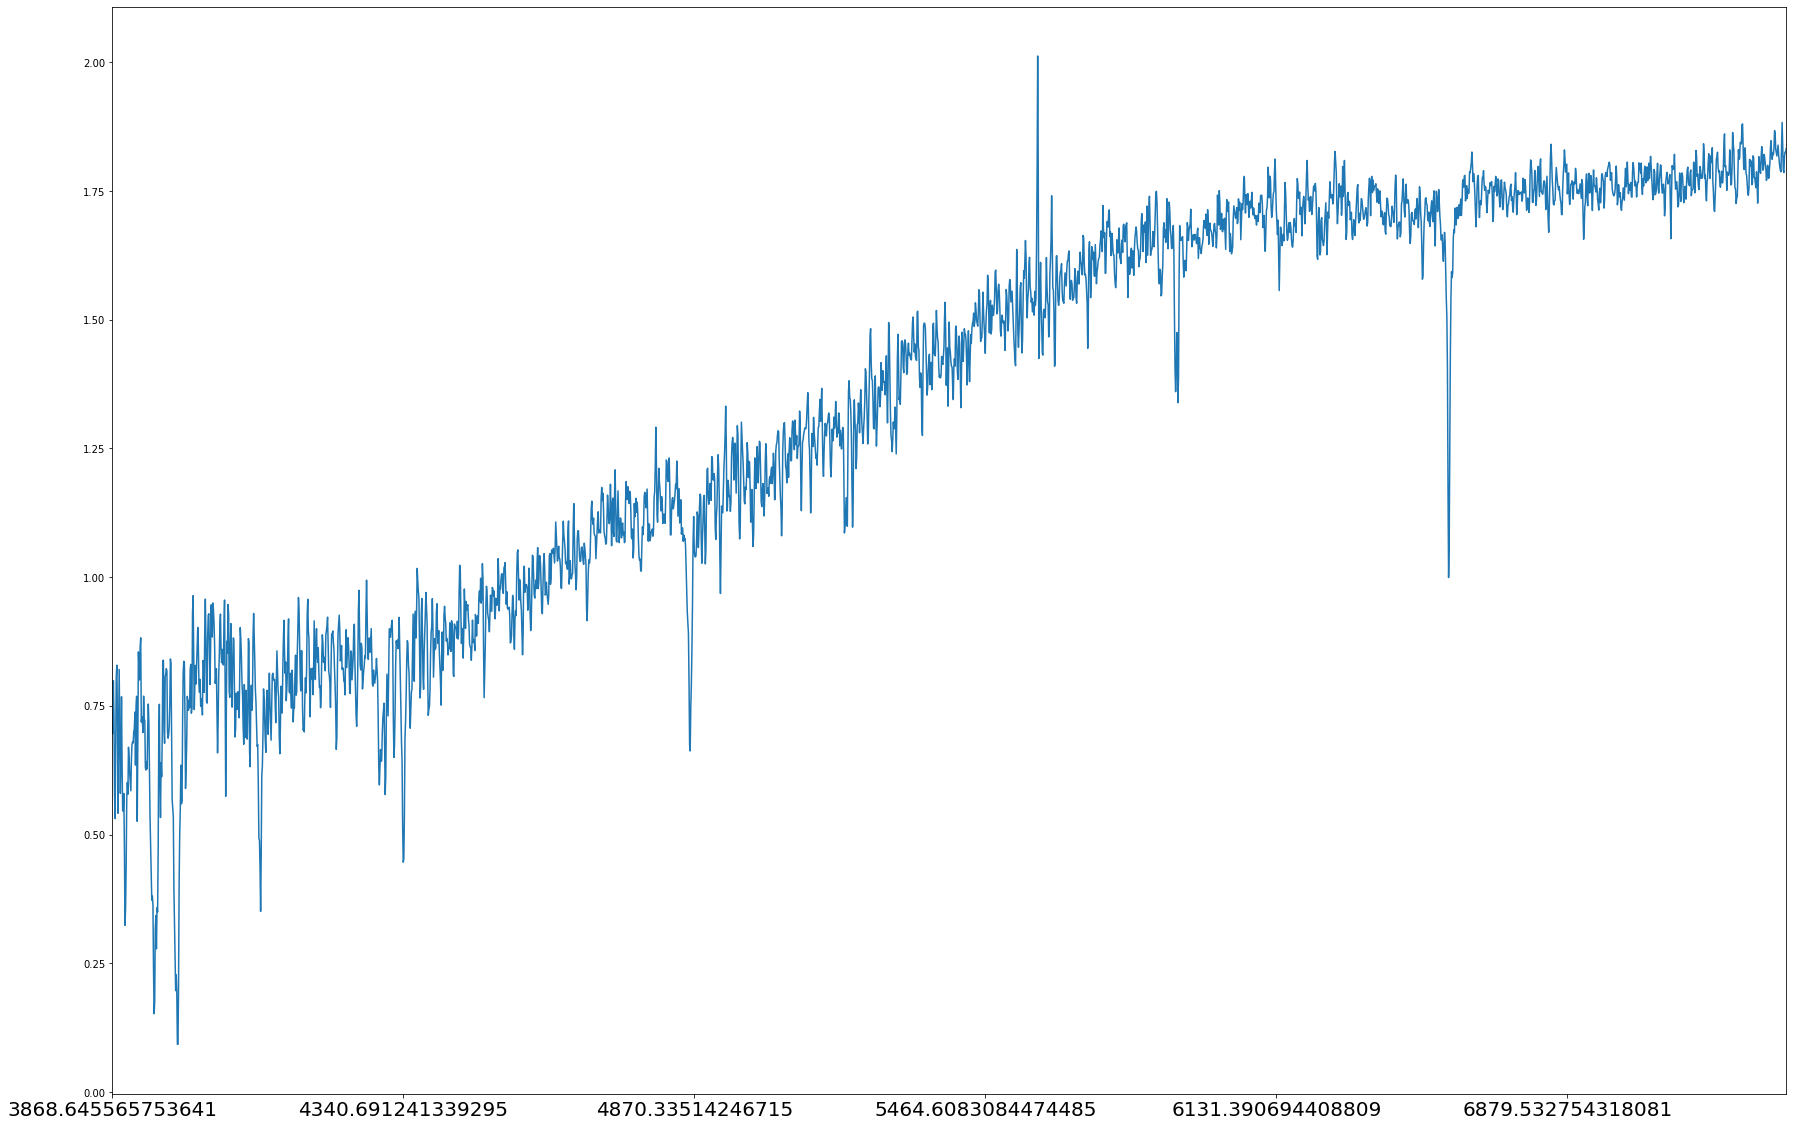

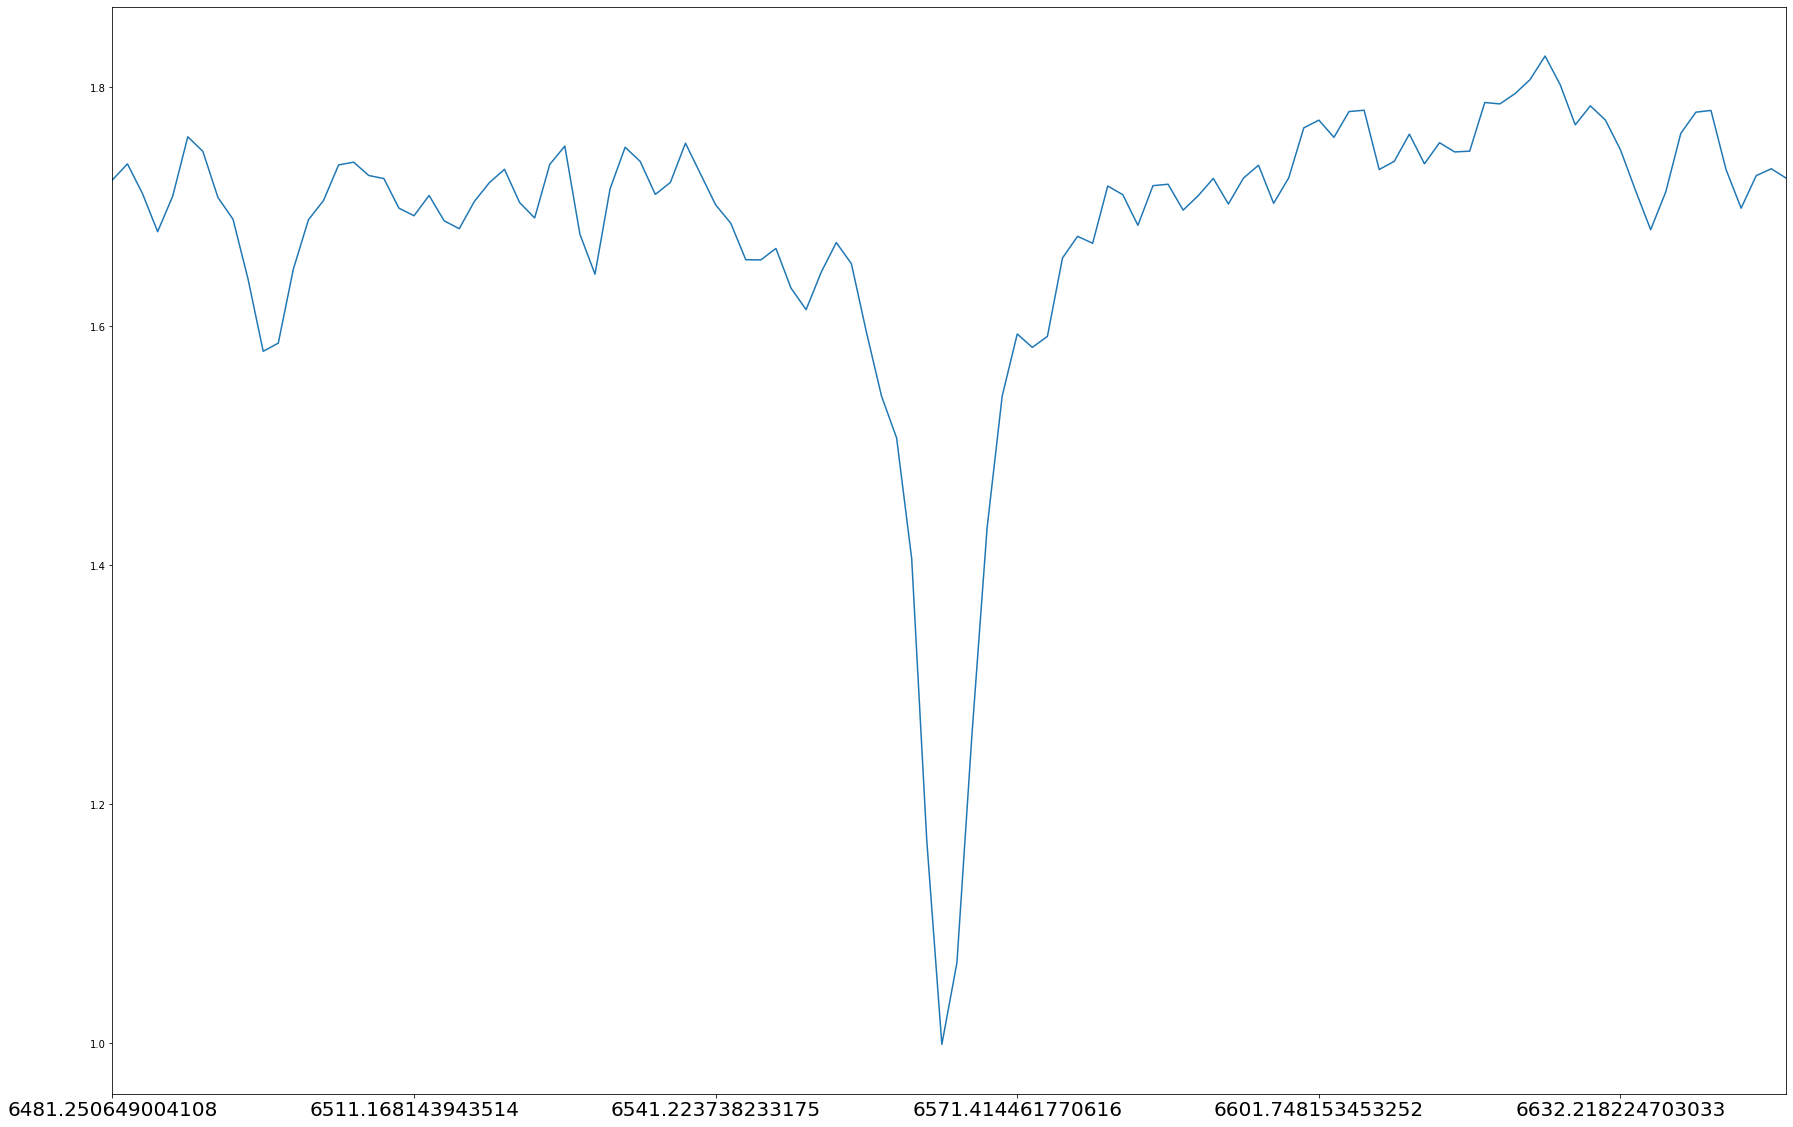

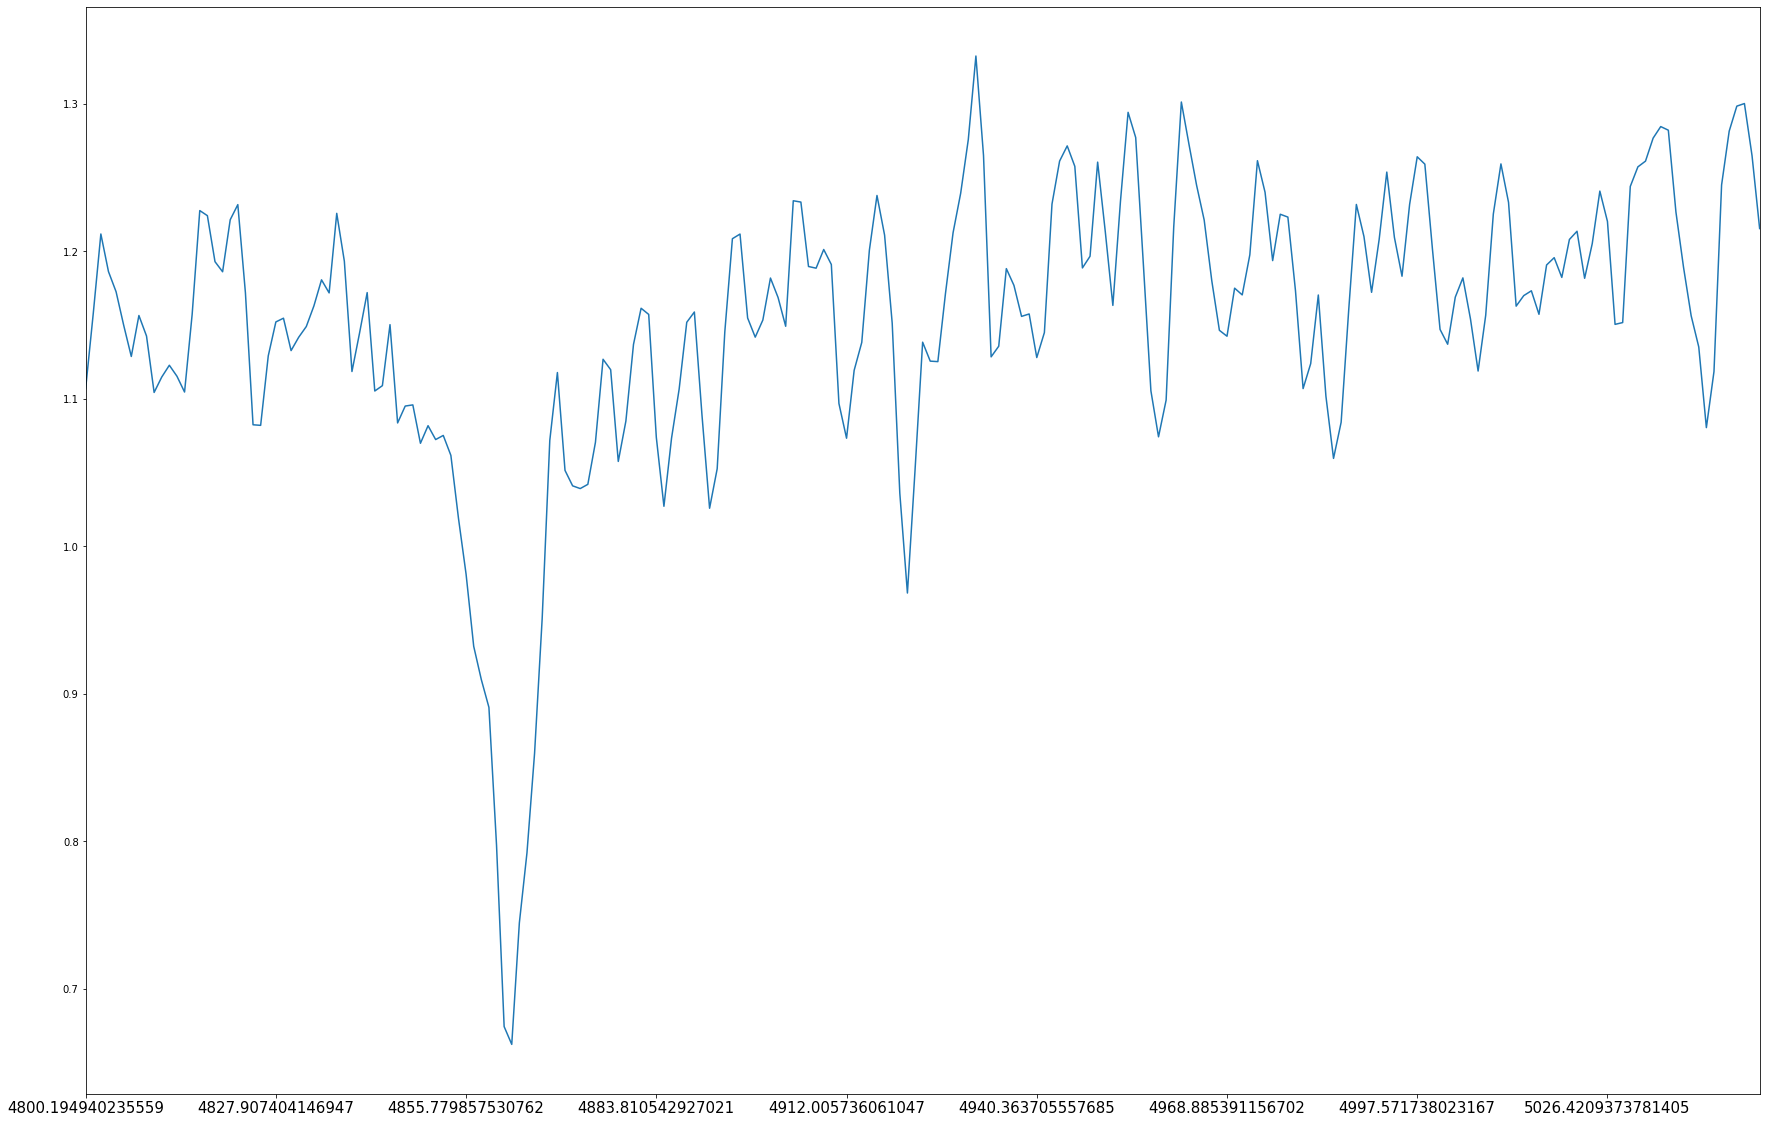

In [149]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 2)

### Gráfica original del SDSS no disponible

* PLATE     7261.000000
* MJD      56603.000000
* FIBER      738.000000

----------

PLATE     7261.000000
MJD      56603.000000
FIBER      738.000000
Z            0.086015
Name: 415, dtype: float64


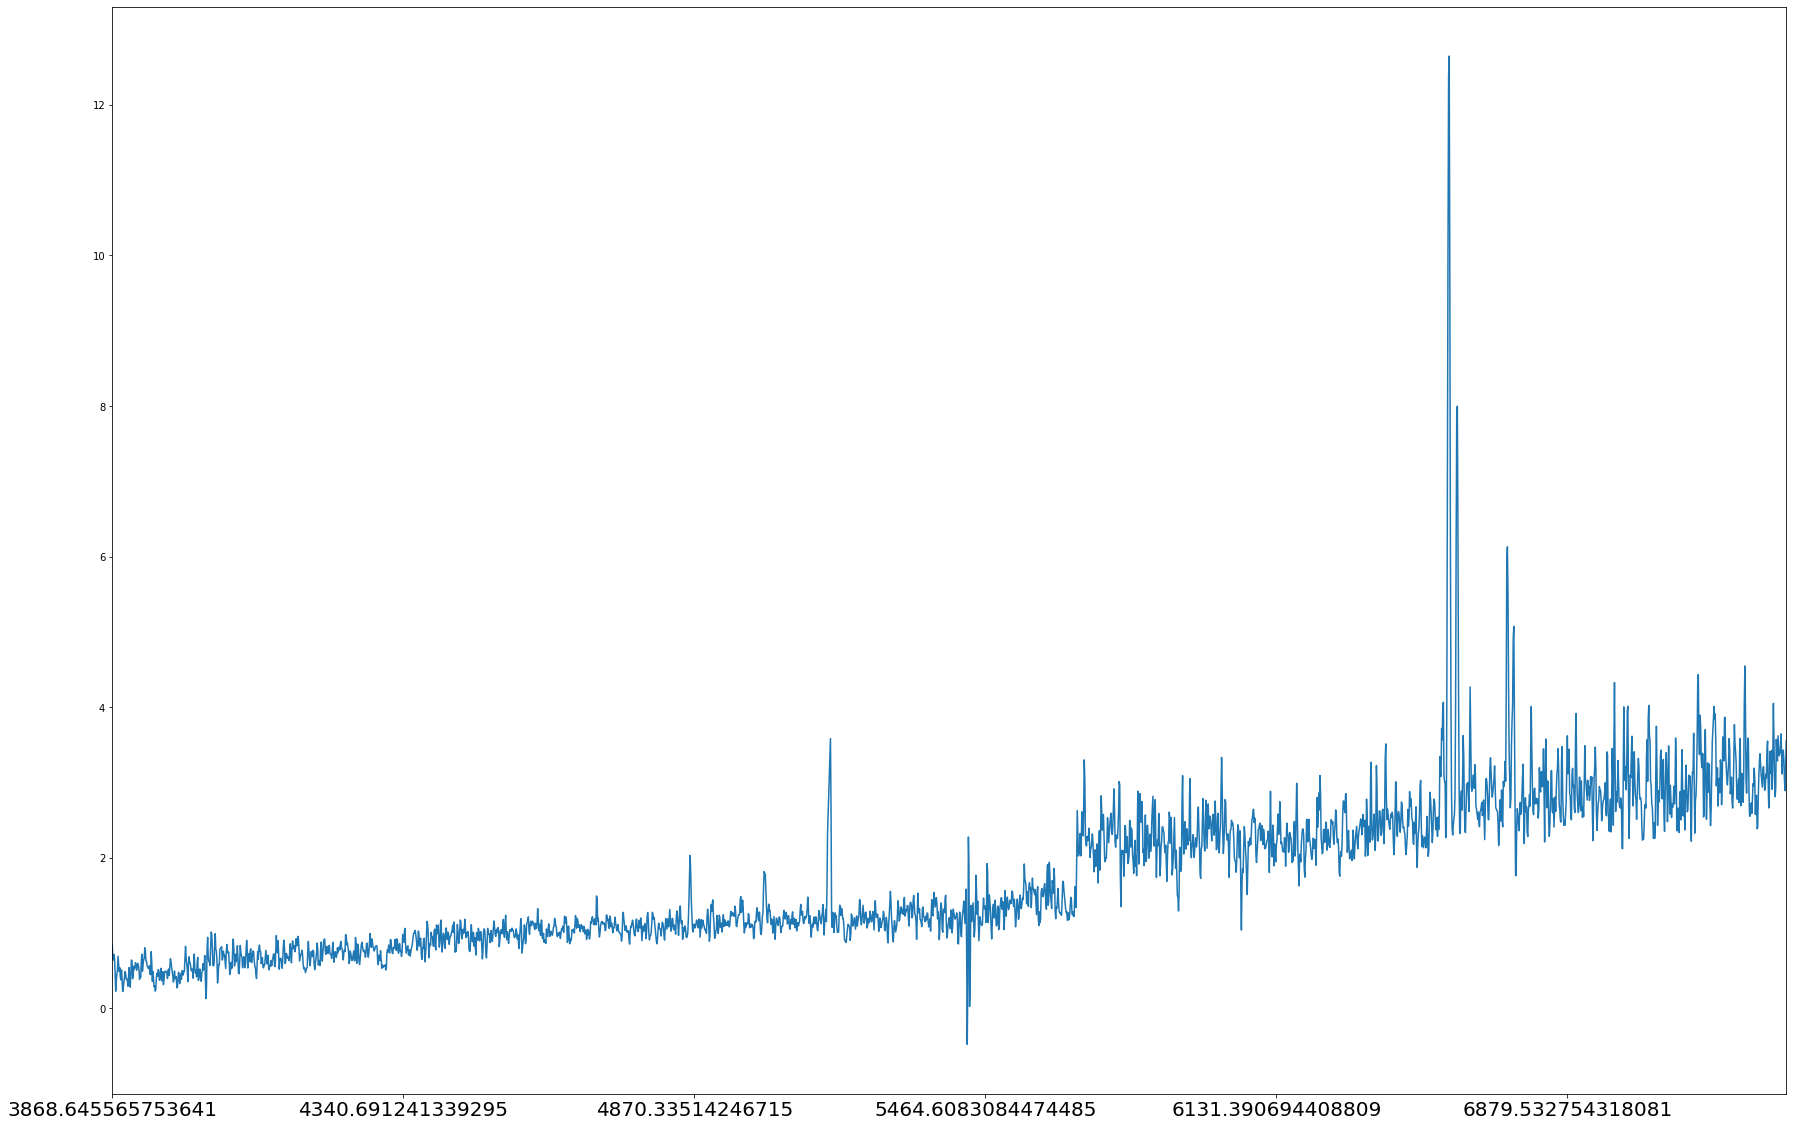

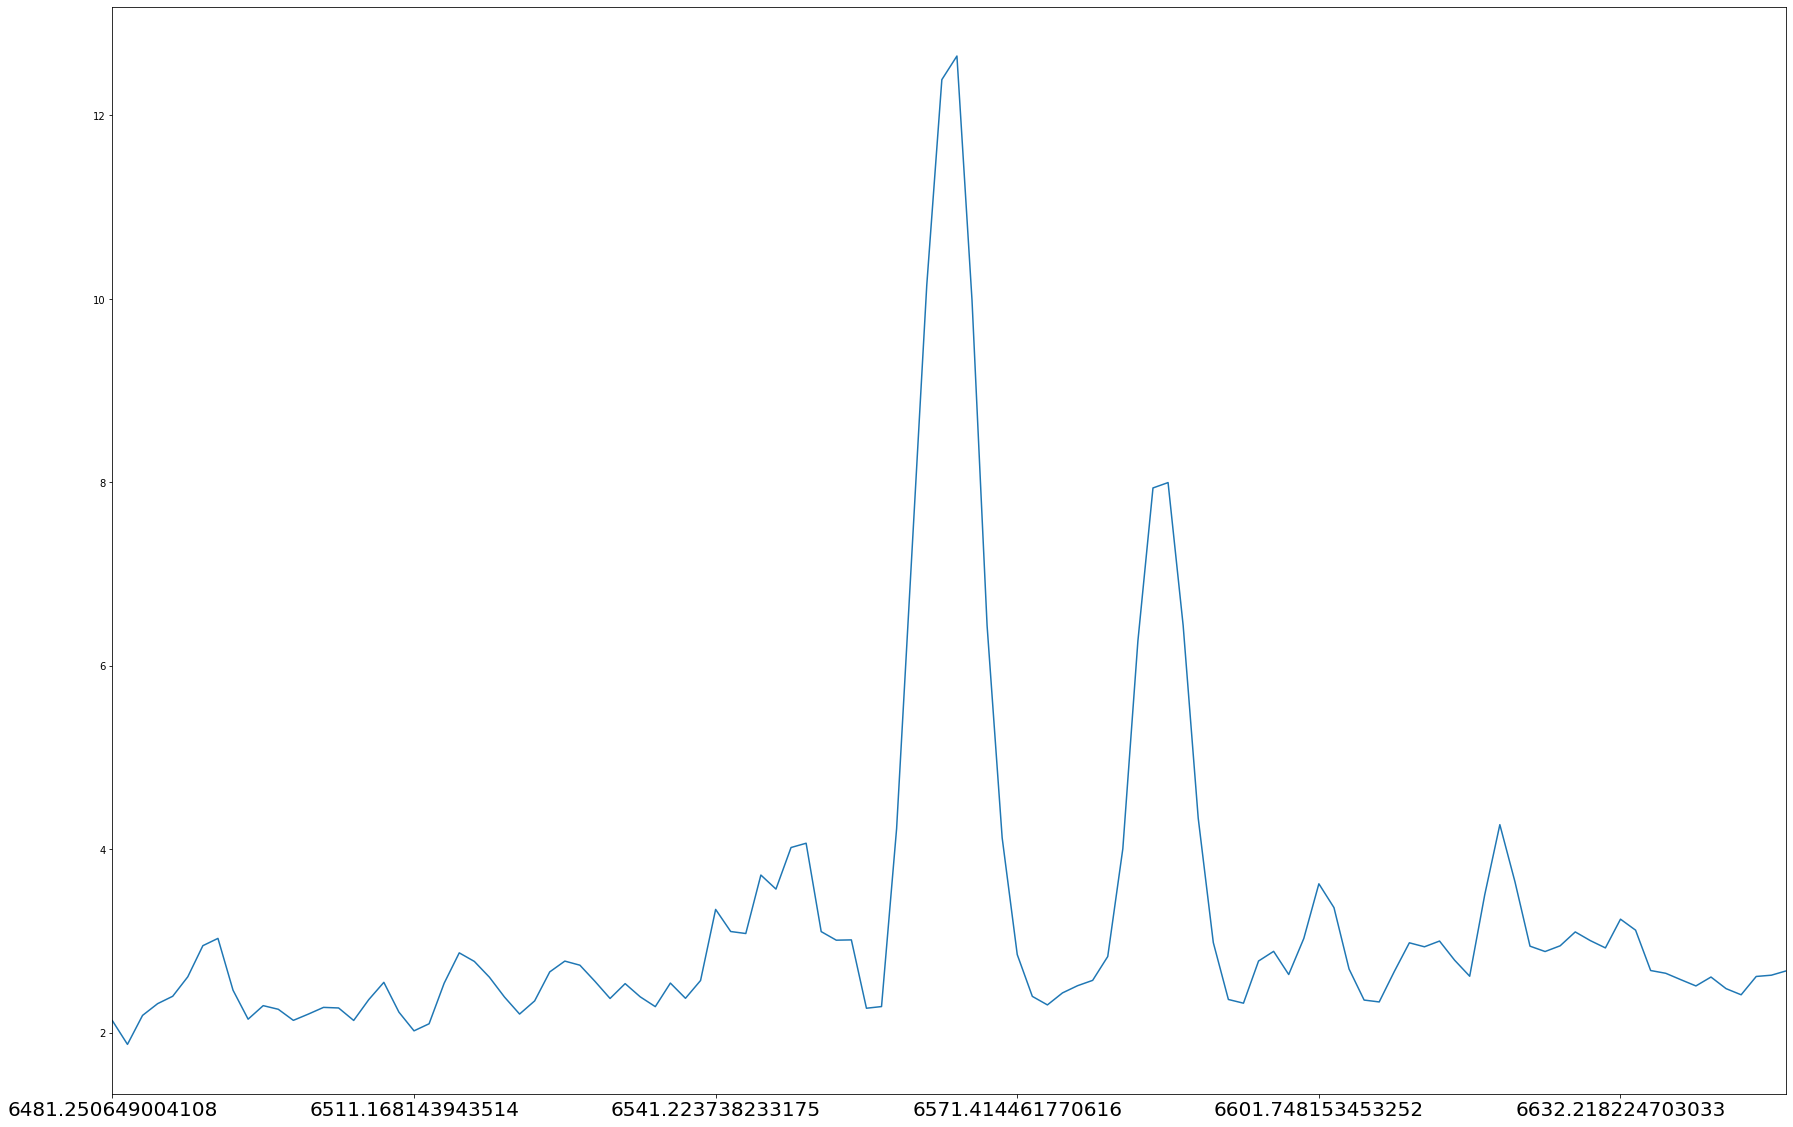

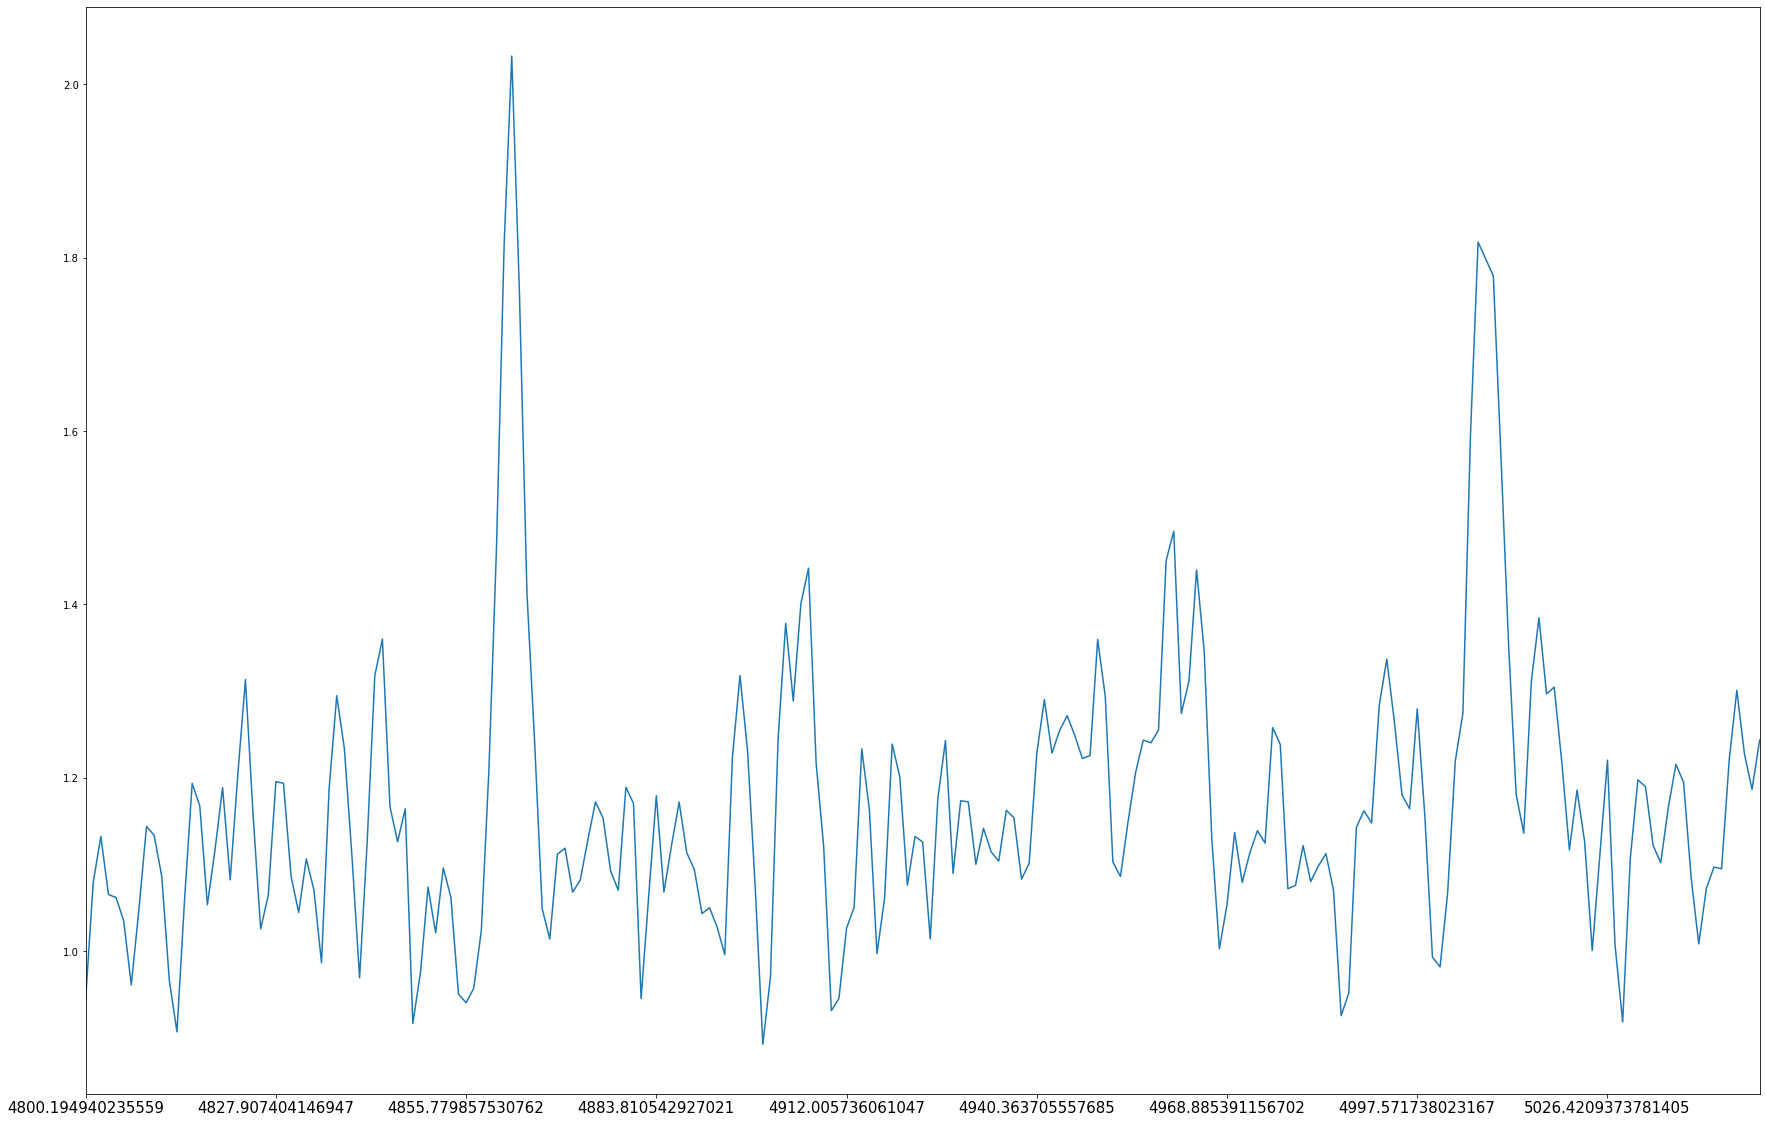

In [150]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 3)

In [37]:
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=1411940655449532416", width=800, height=640)

----------

PLATE     1254.000000
MJD      52972.000000
FIBER      226.000000
Z            0.017982
Name: 498, dtype: float64


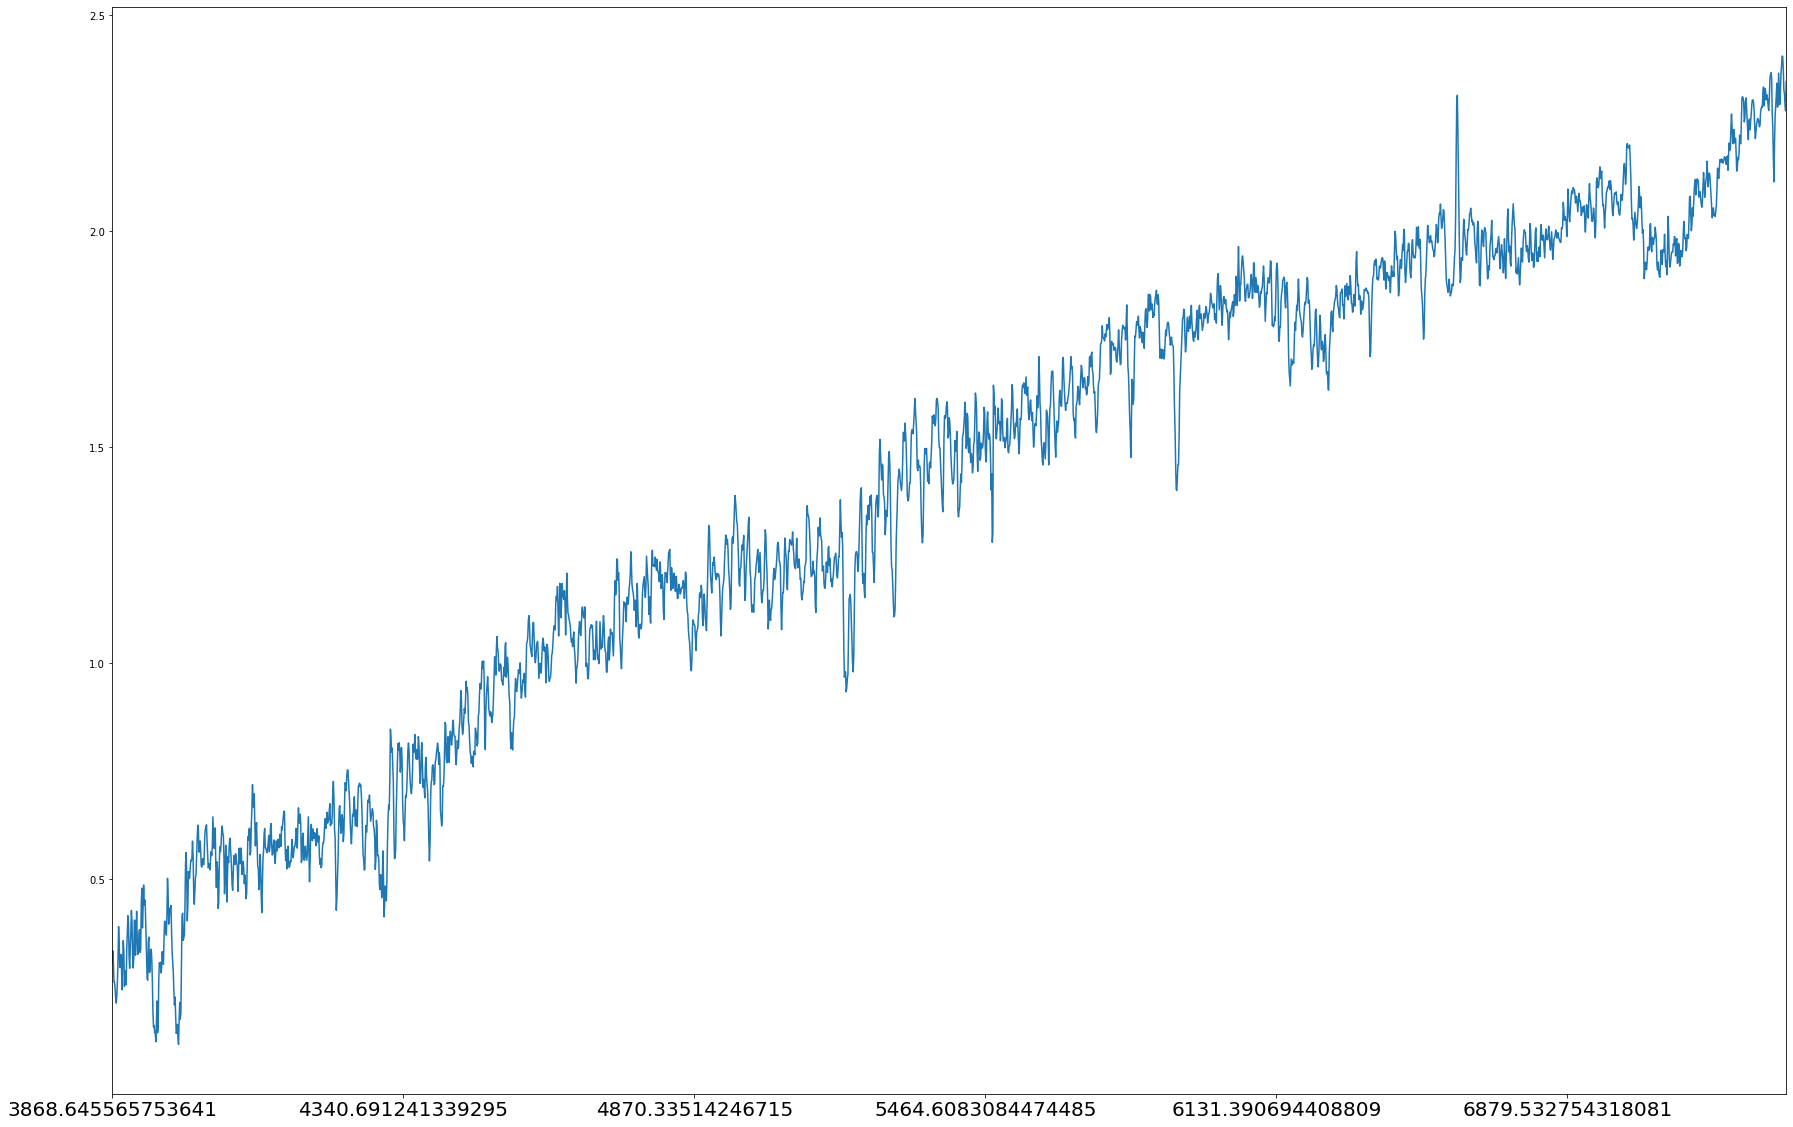

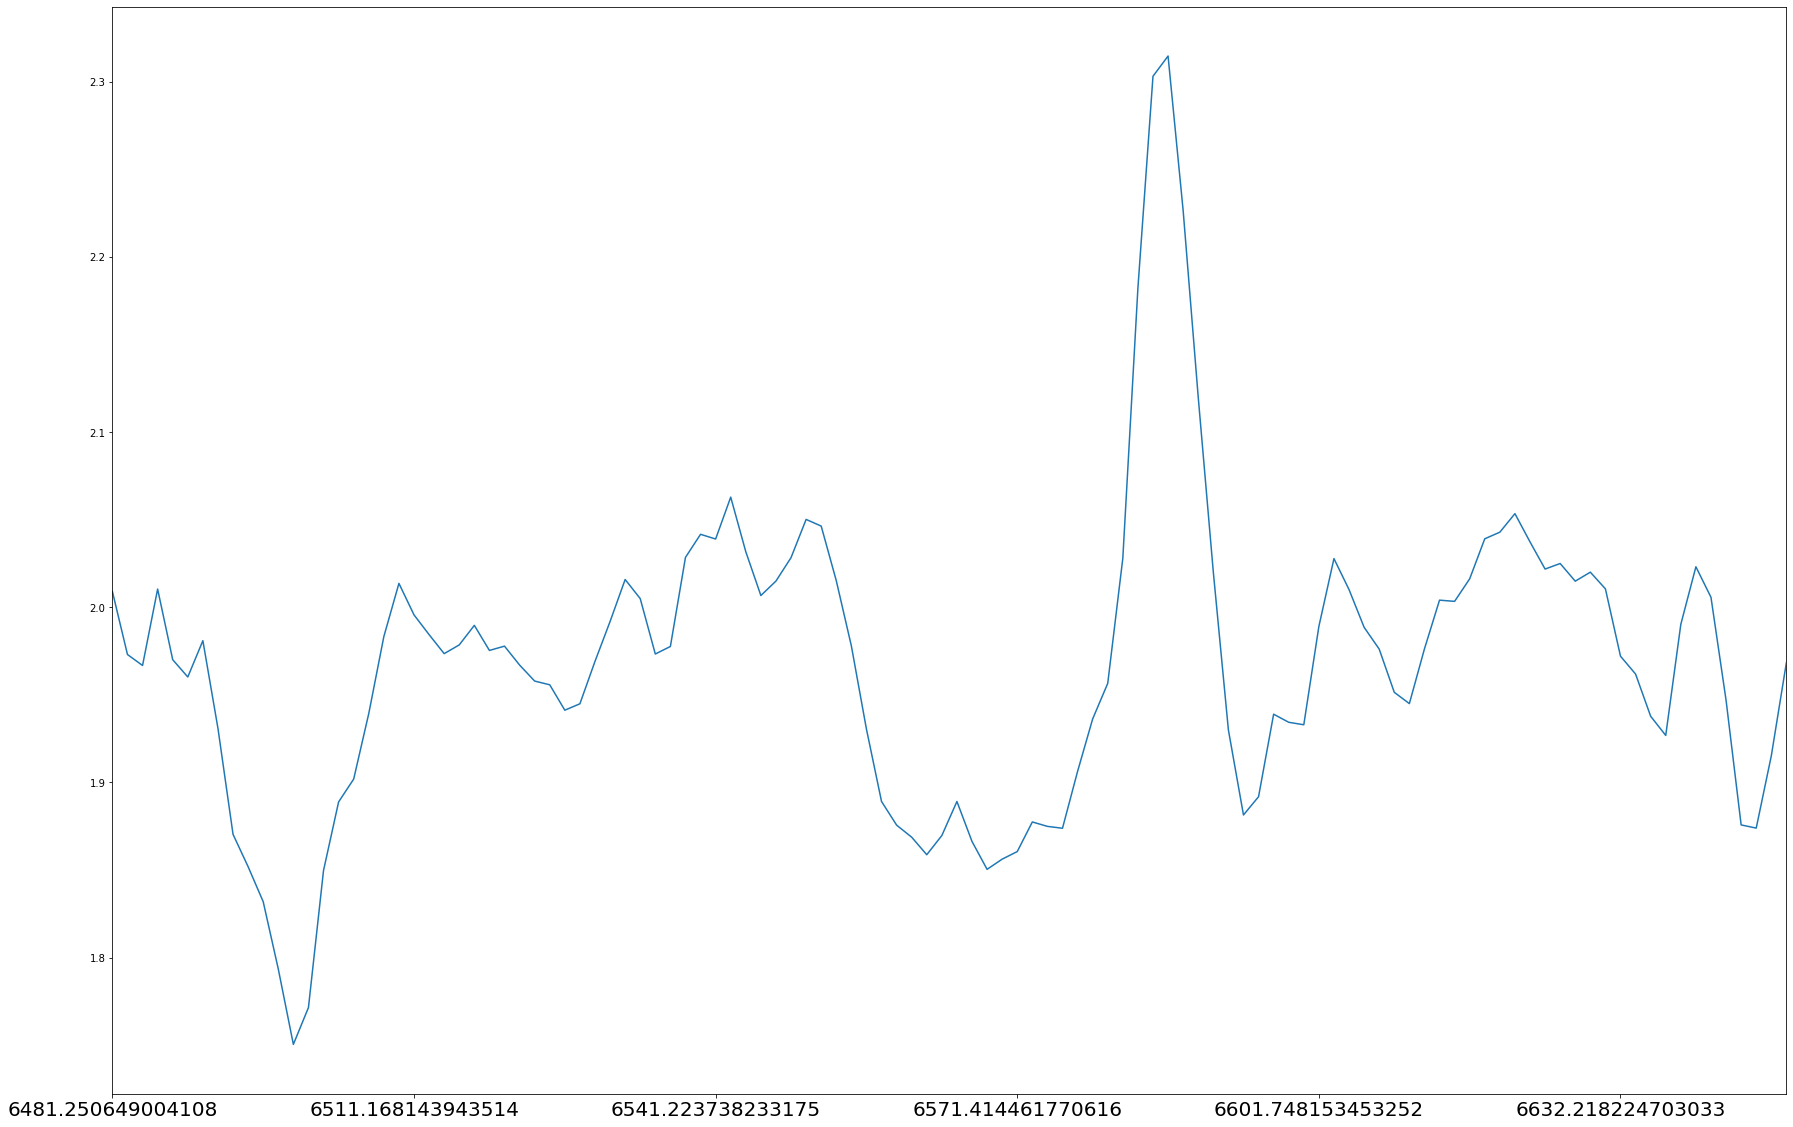

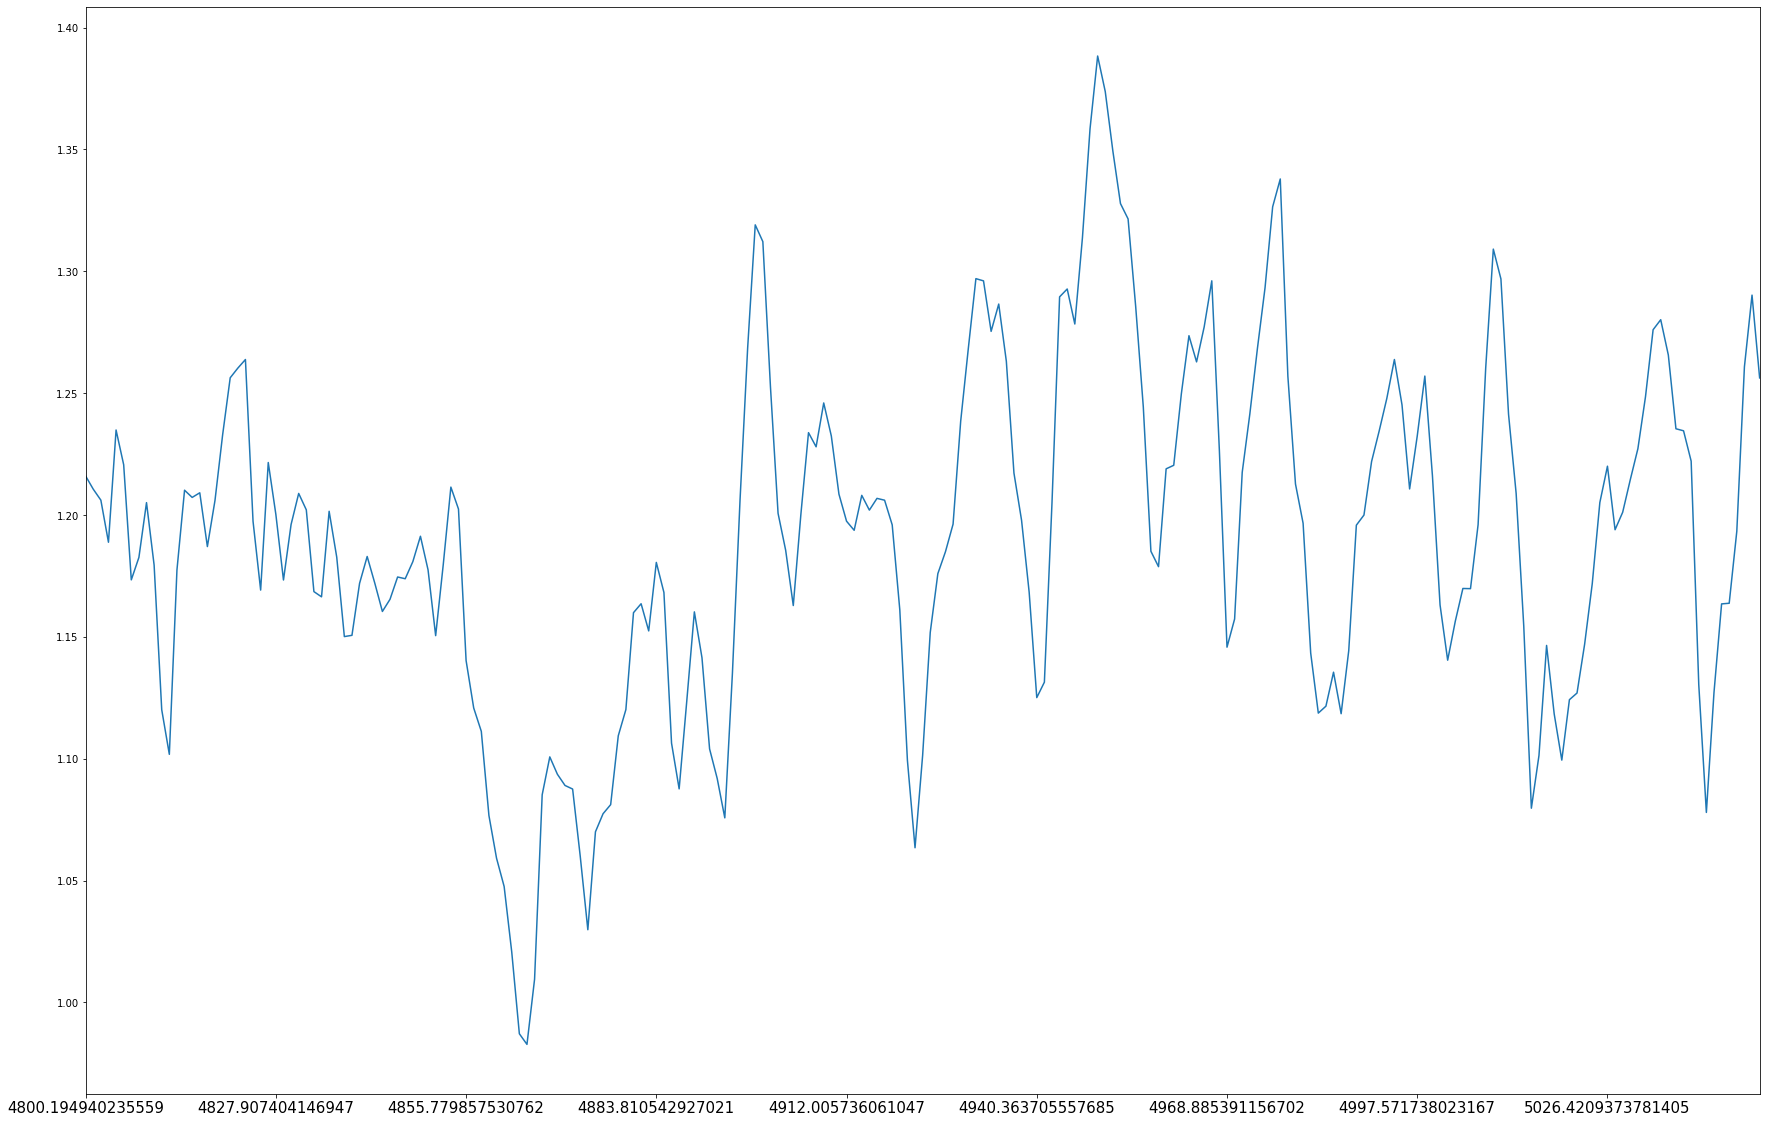

In [151]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 4)

In [38]:
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=7330798449728659456", width=800, height=640)

----------

PLATE     6511.000000
MJD      56540.000000
FIBER      233.000000
Z            0.206336
Name: 1385, dtype: float64


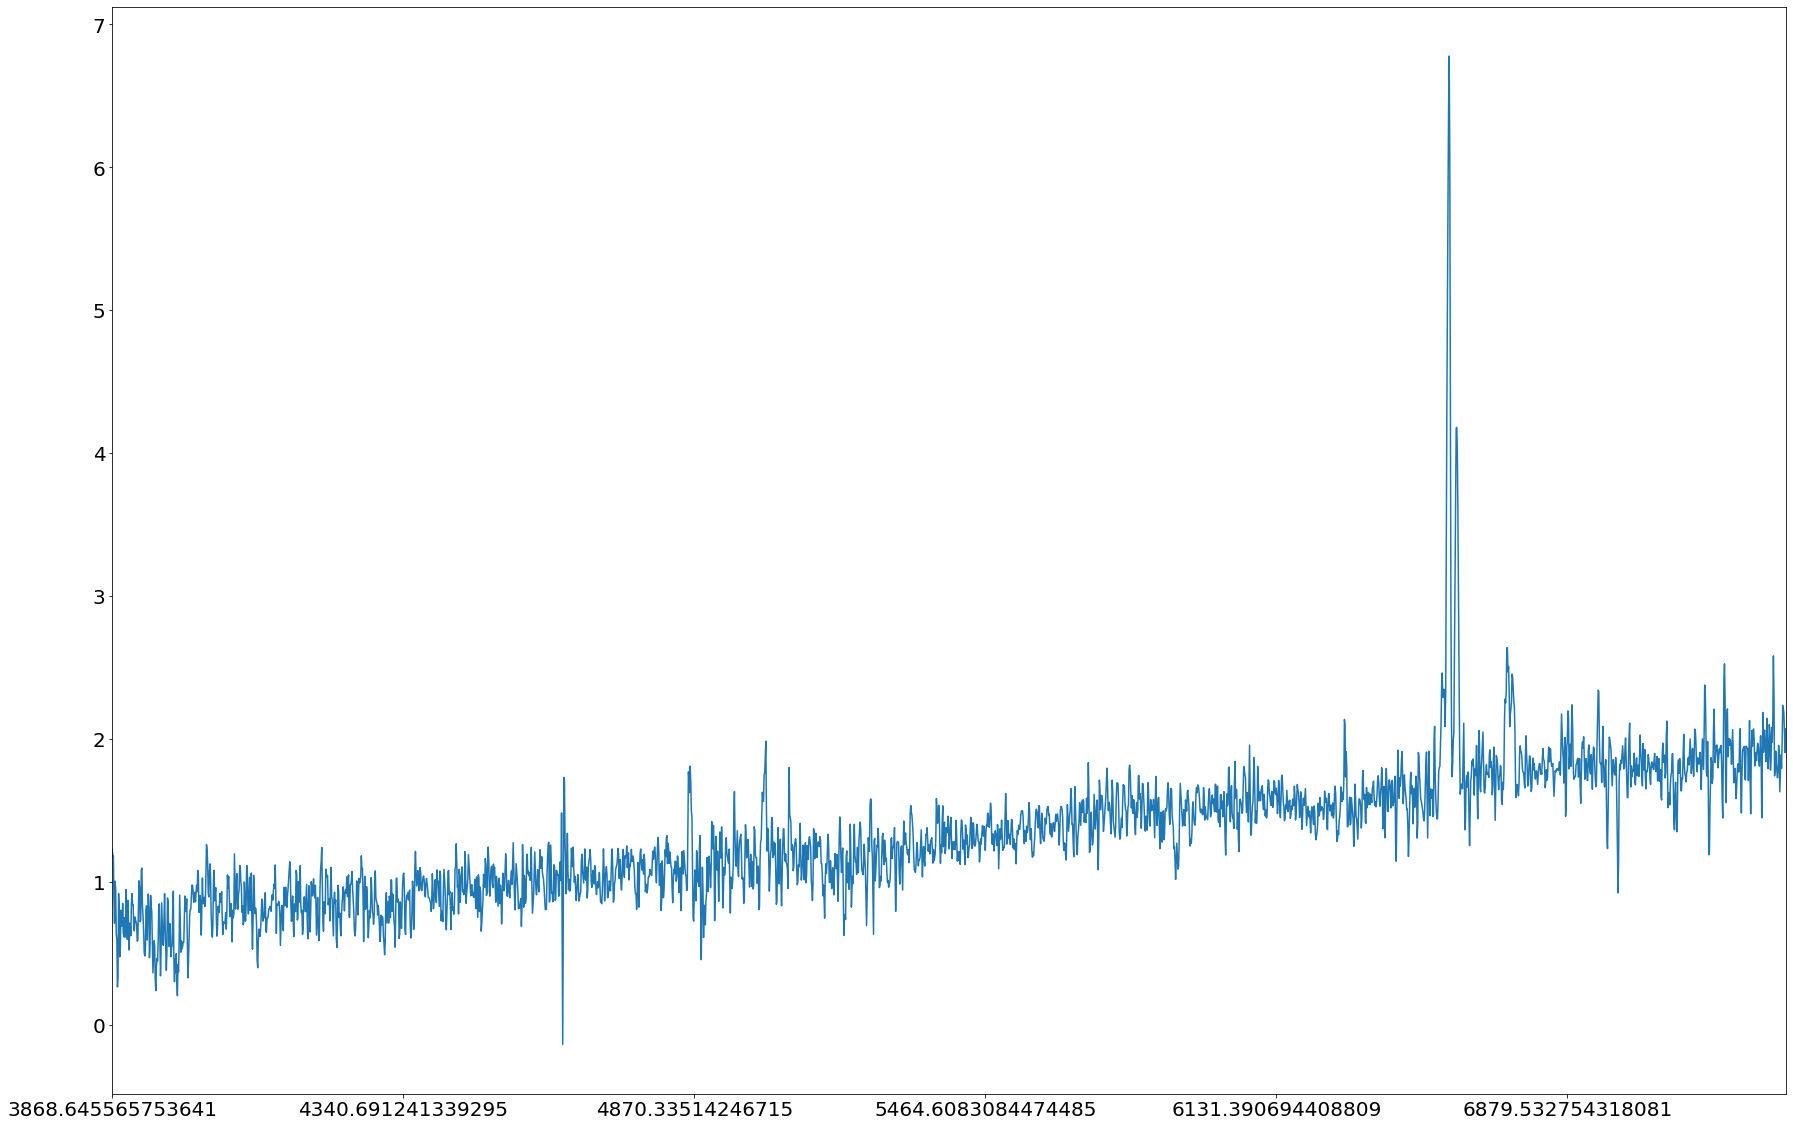

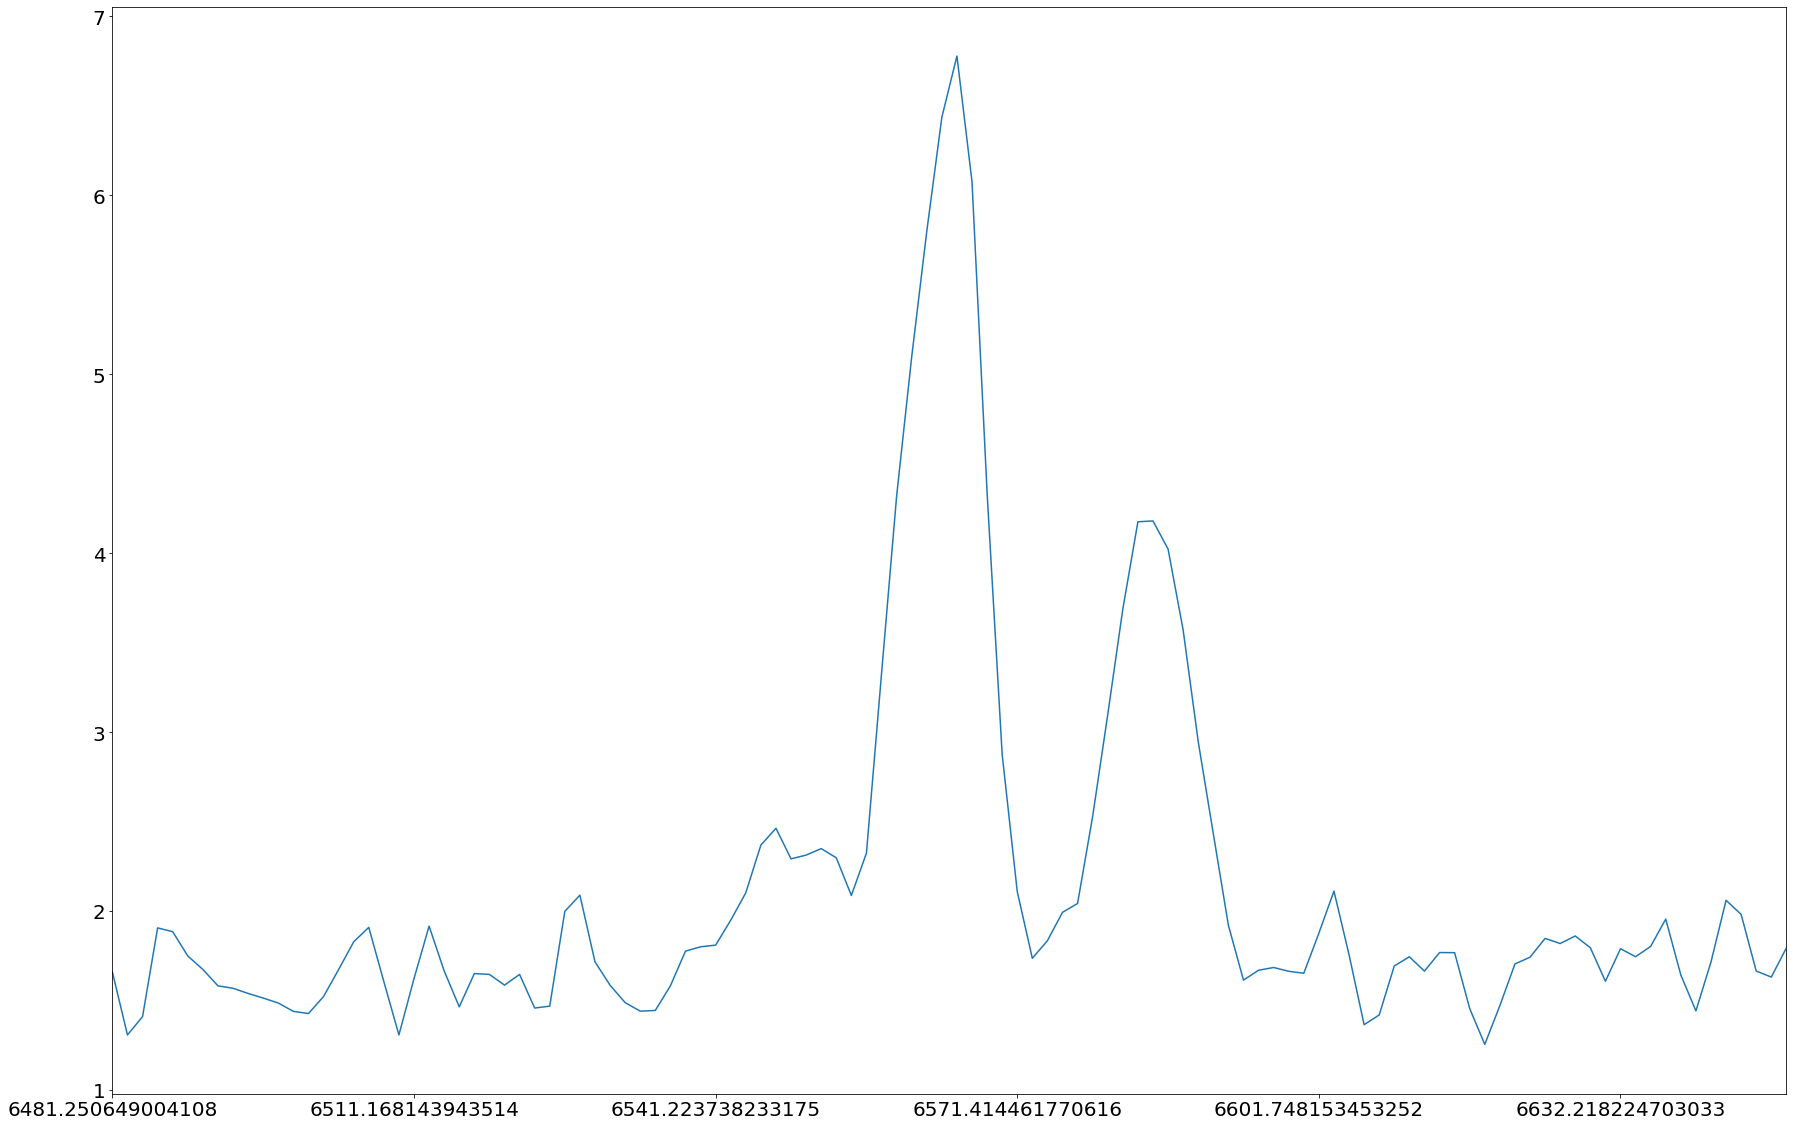

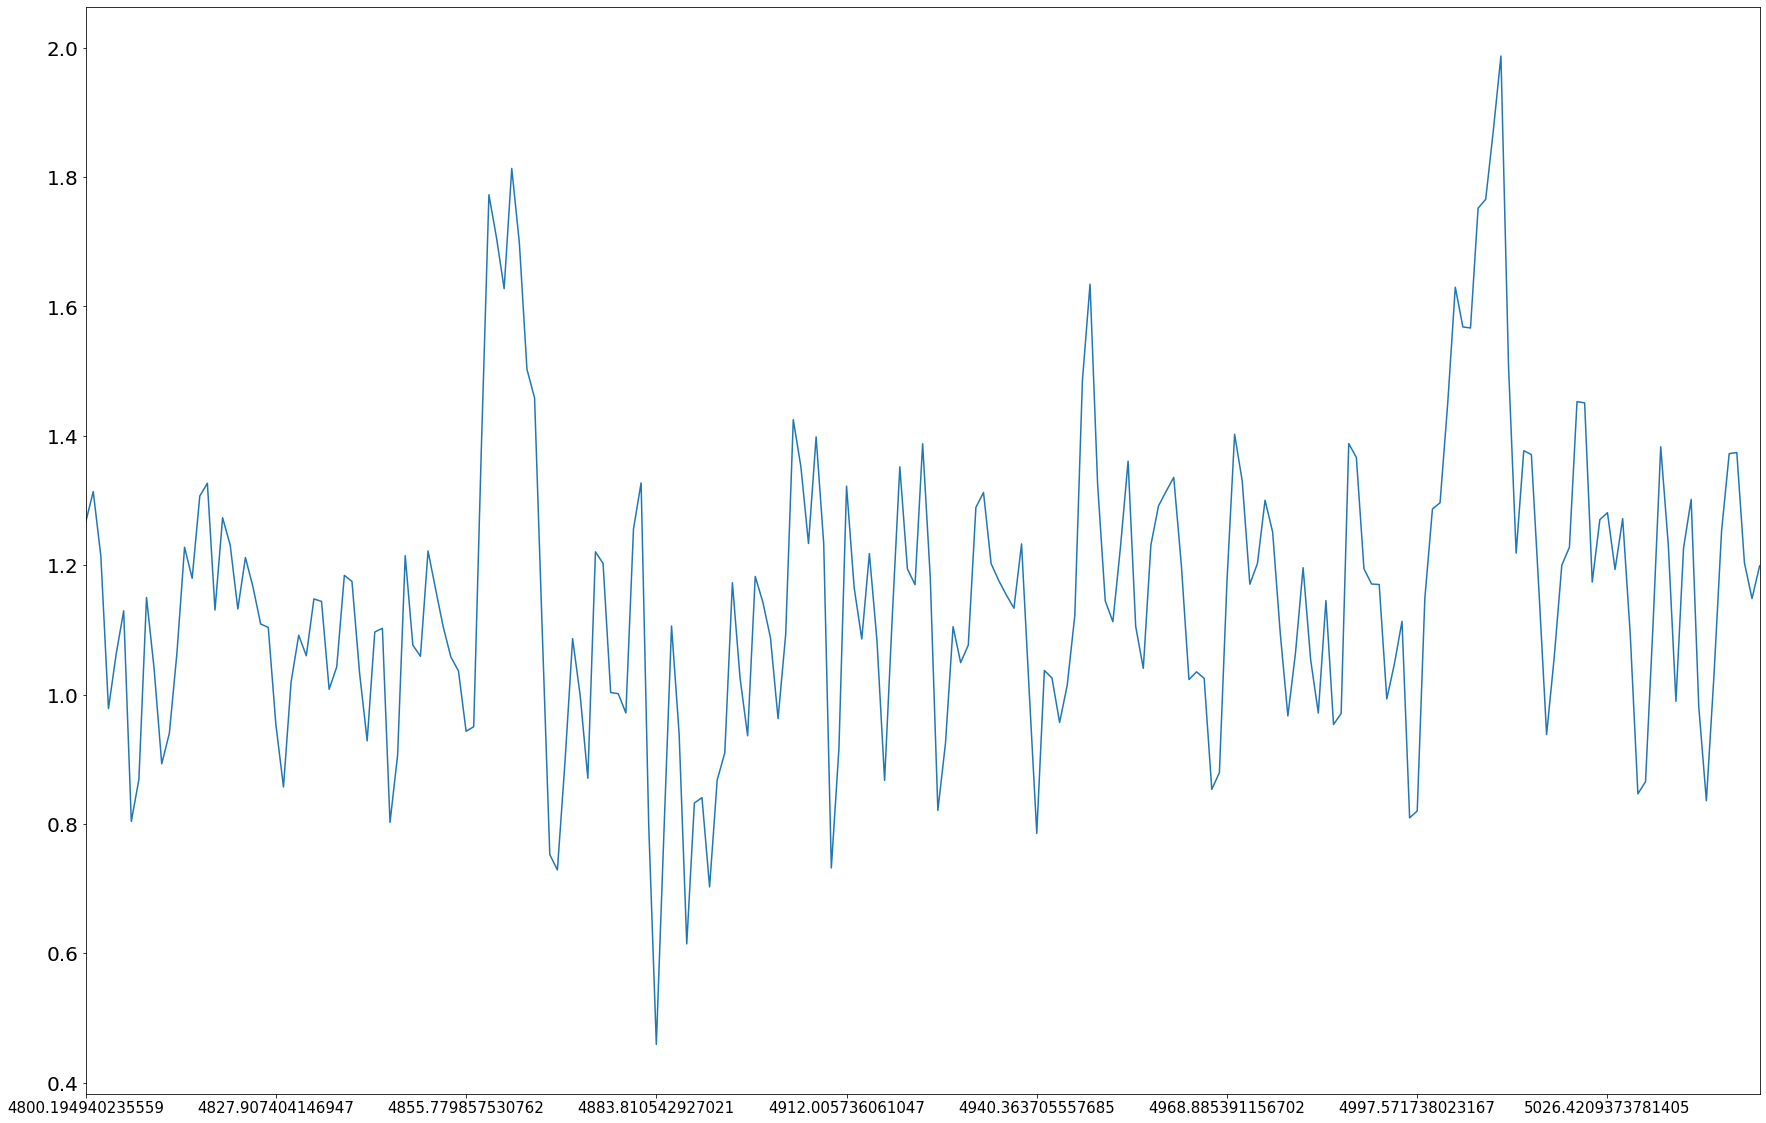

In [153]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 5)

In [39]:
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=6796075701072011264", width=800, height=640)

----------

PLATE     6036.000000
MJD      56093.000000
FIBER      523.000000
Z            0.226707
Name: 1614, dtype: float64


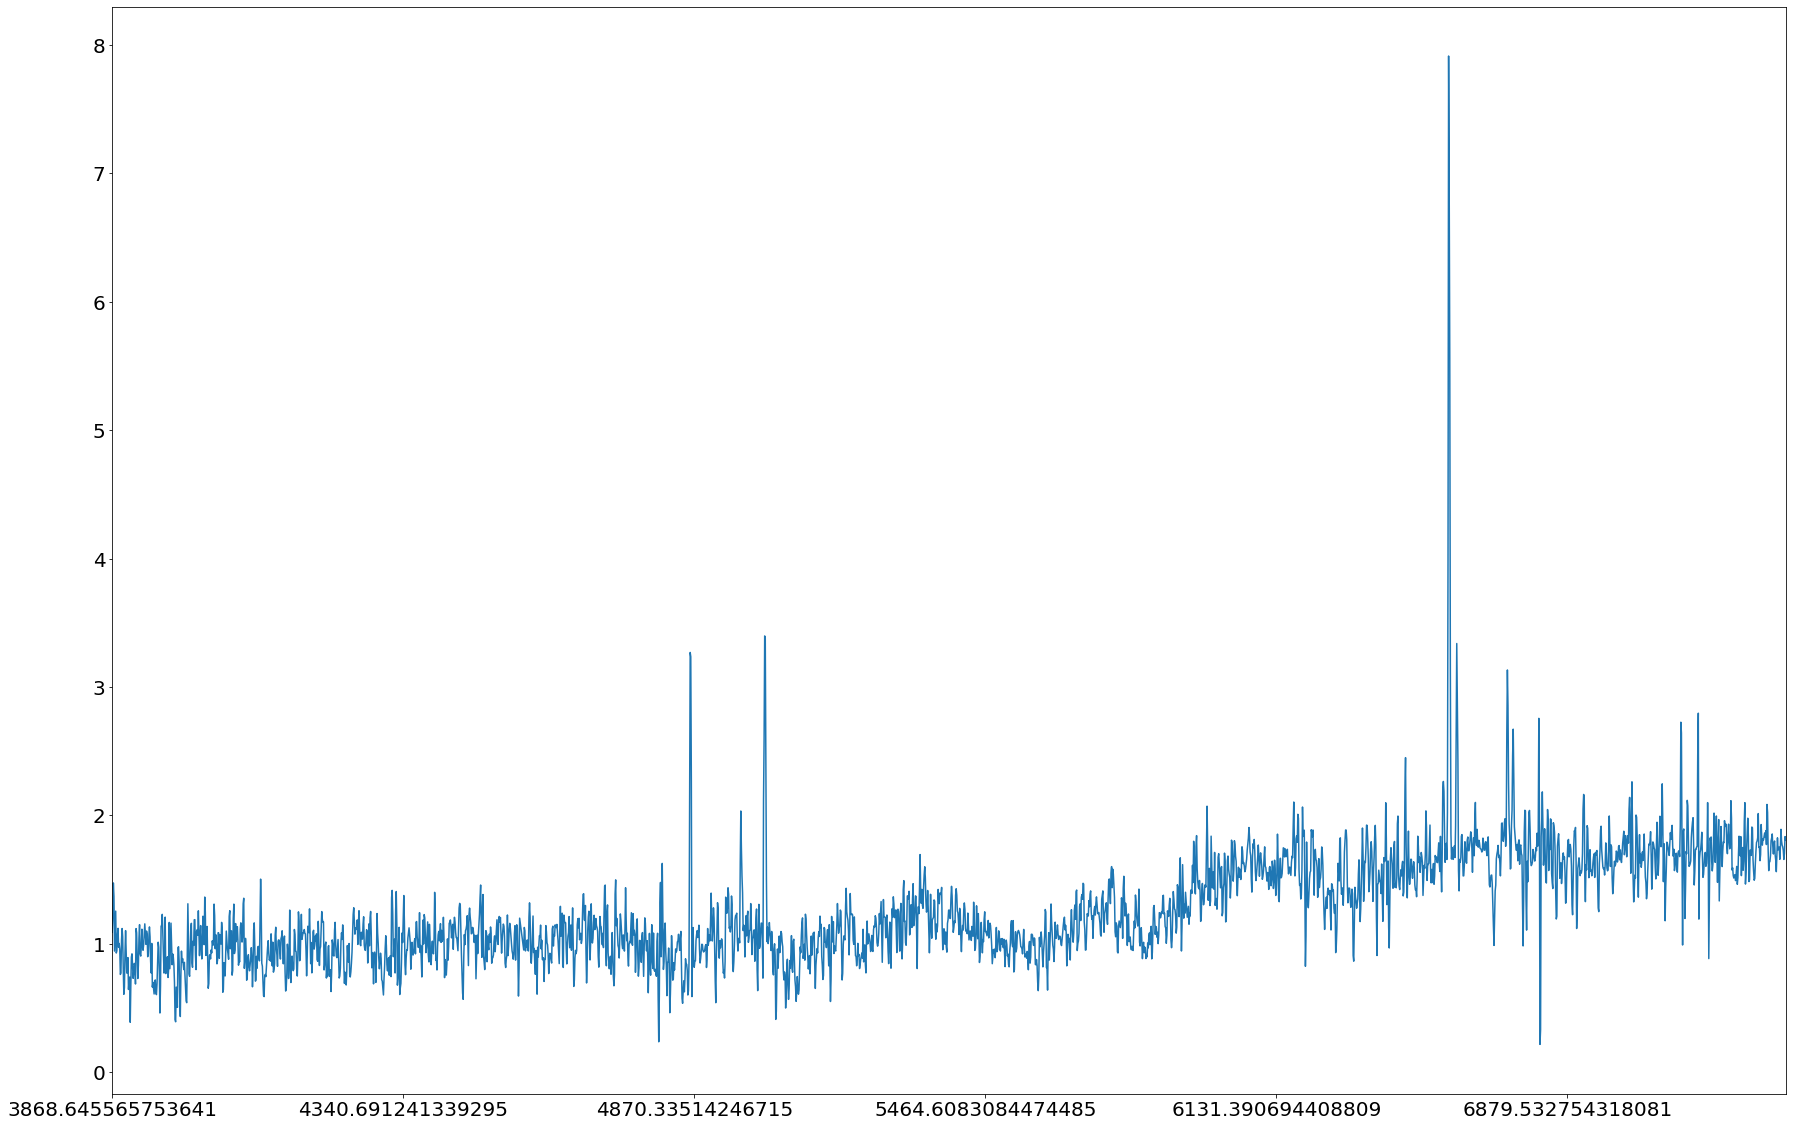

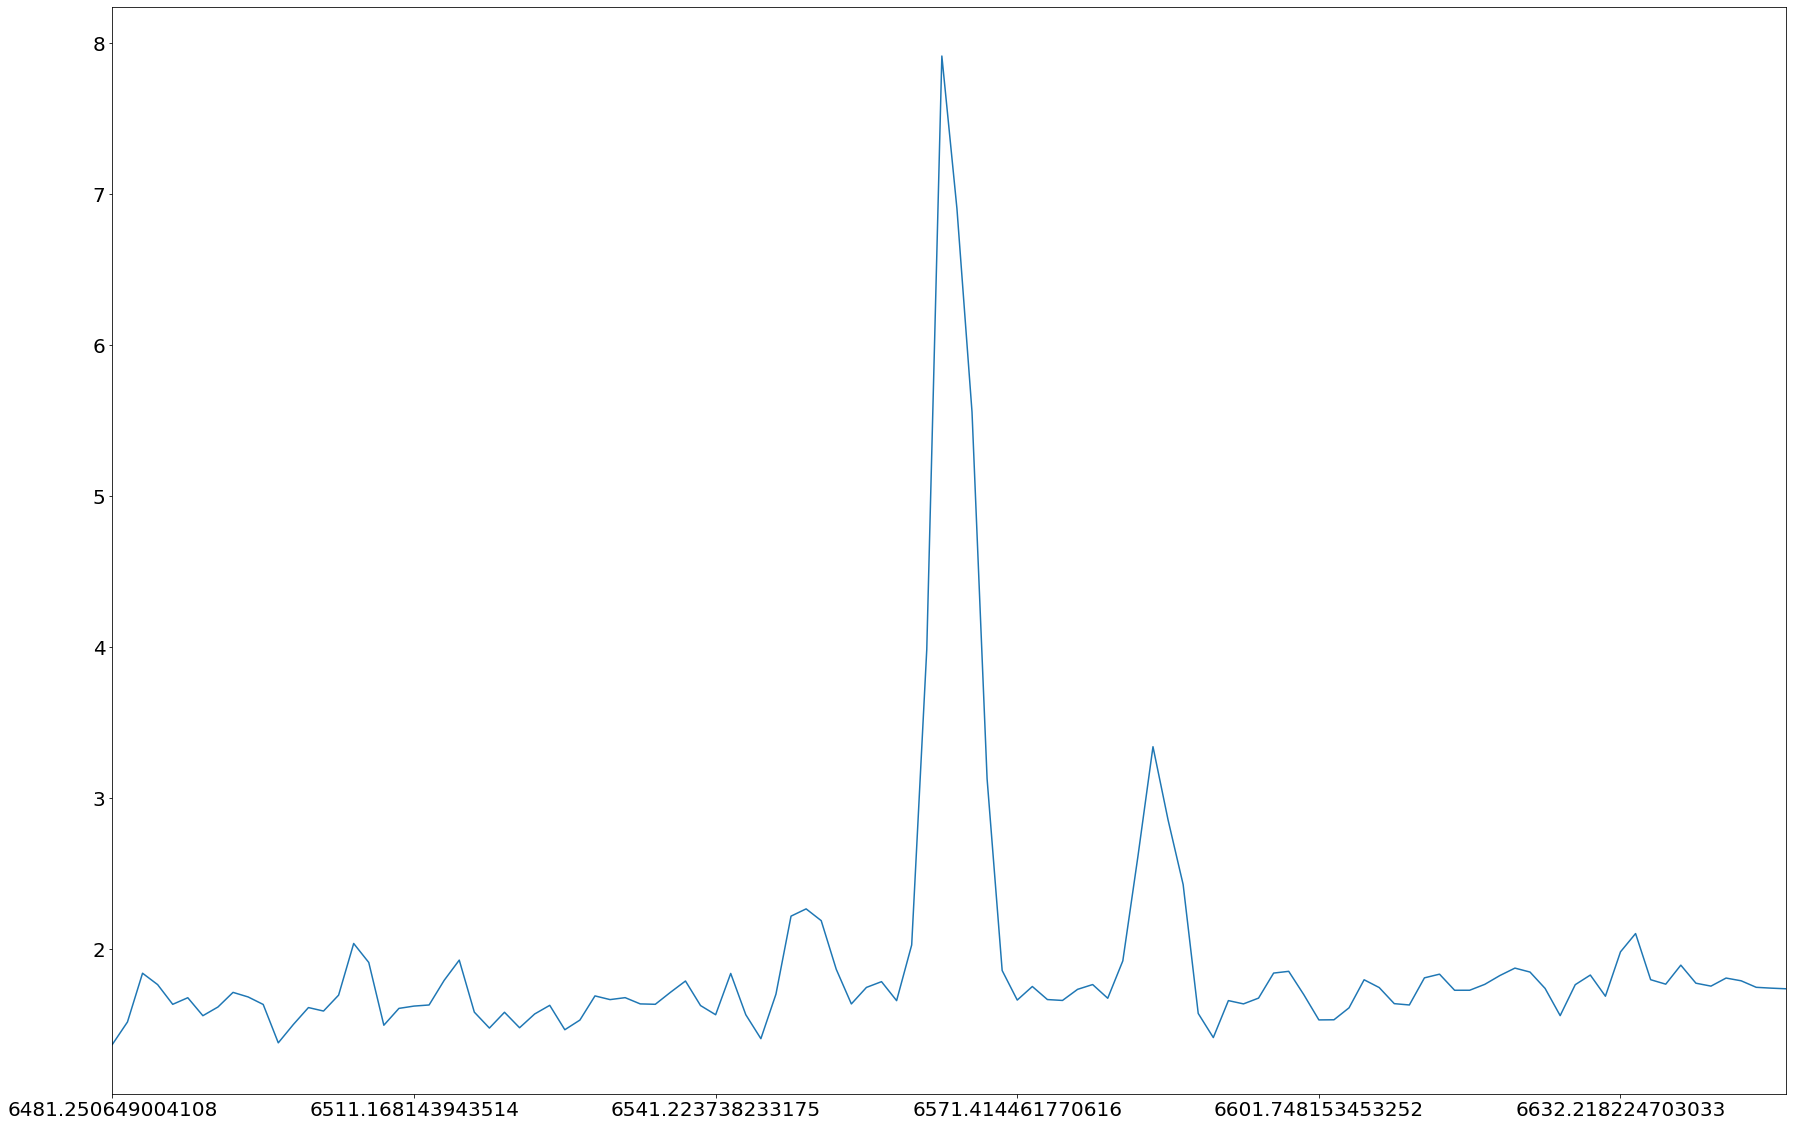

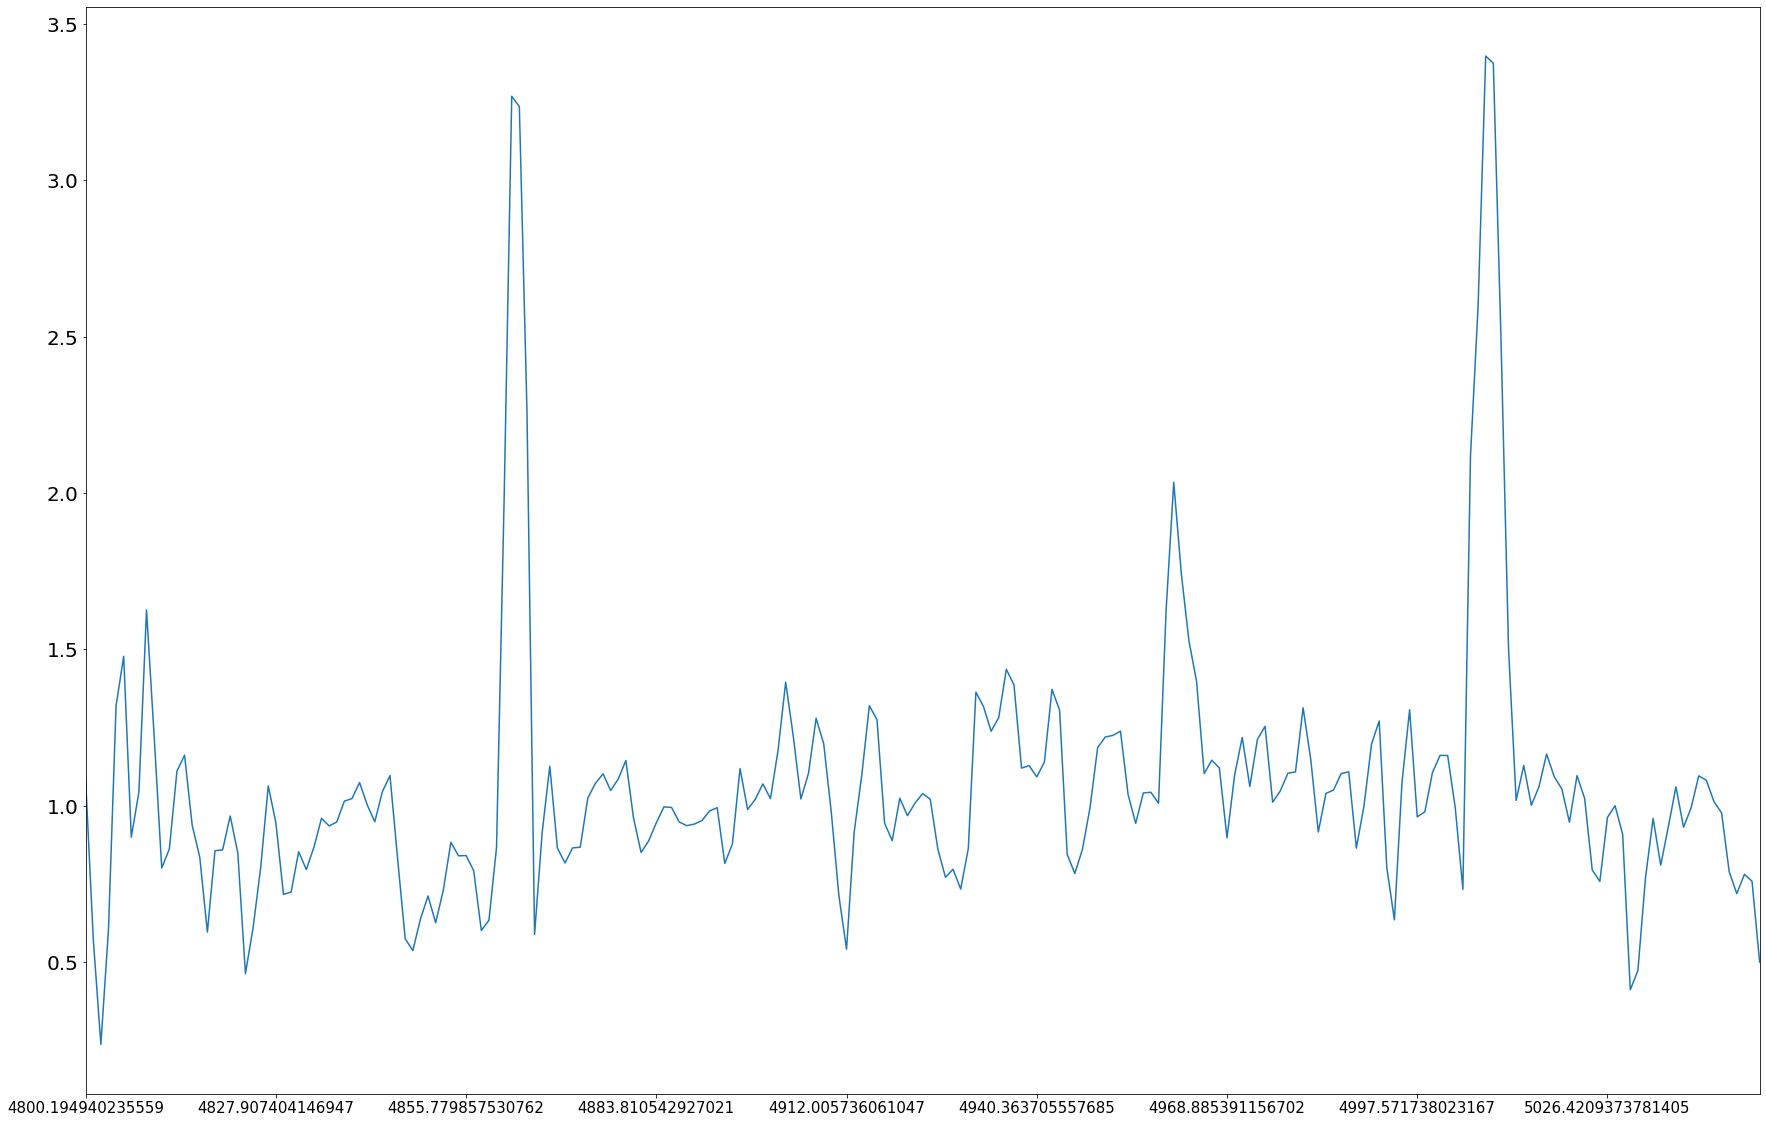

In [154]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 6)

In [40]:
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=4926941389244047360", width=800, height=640)

----------

PLATE     4376.000000
MJD      55863.000000
FIBER       12.000000
Z            0.133735
Name: 1970, dtype: float64


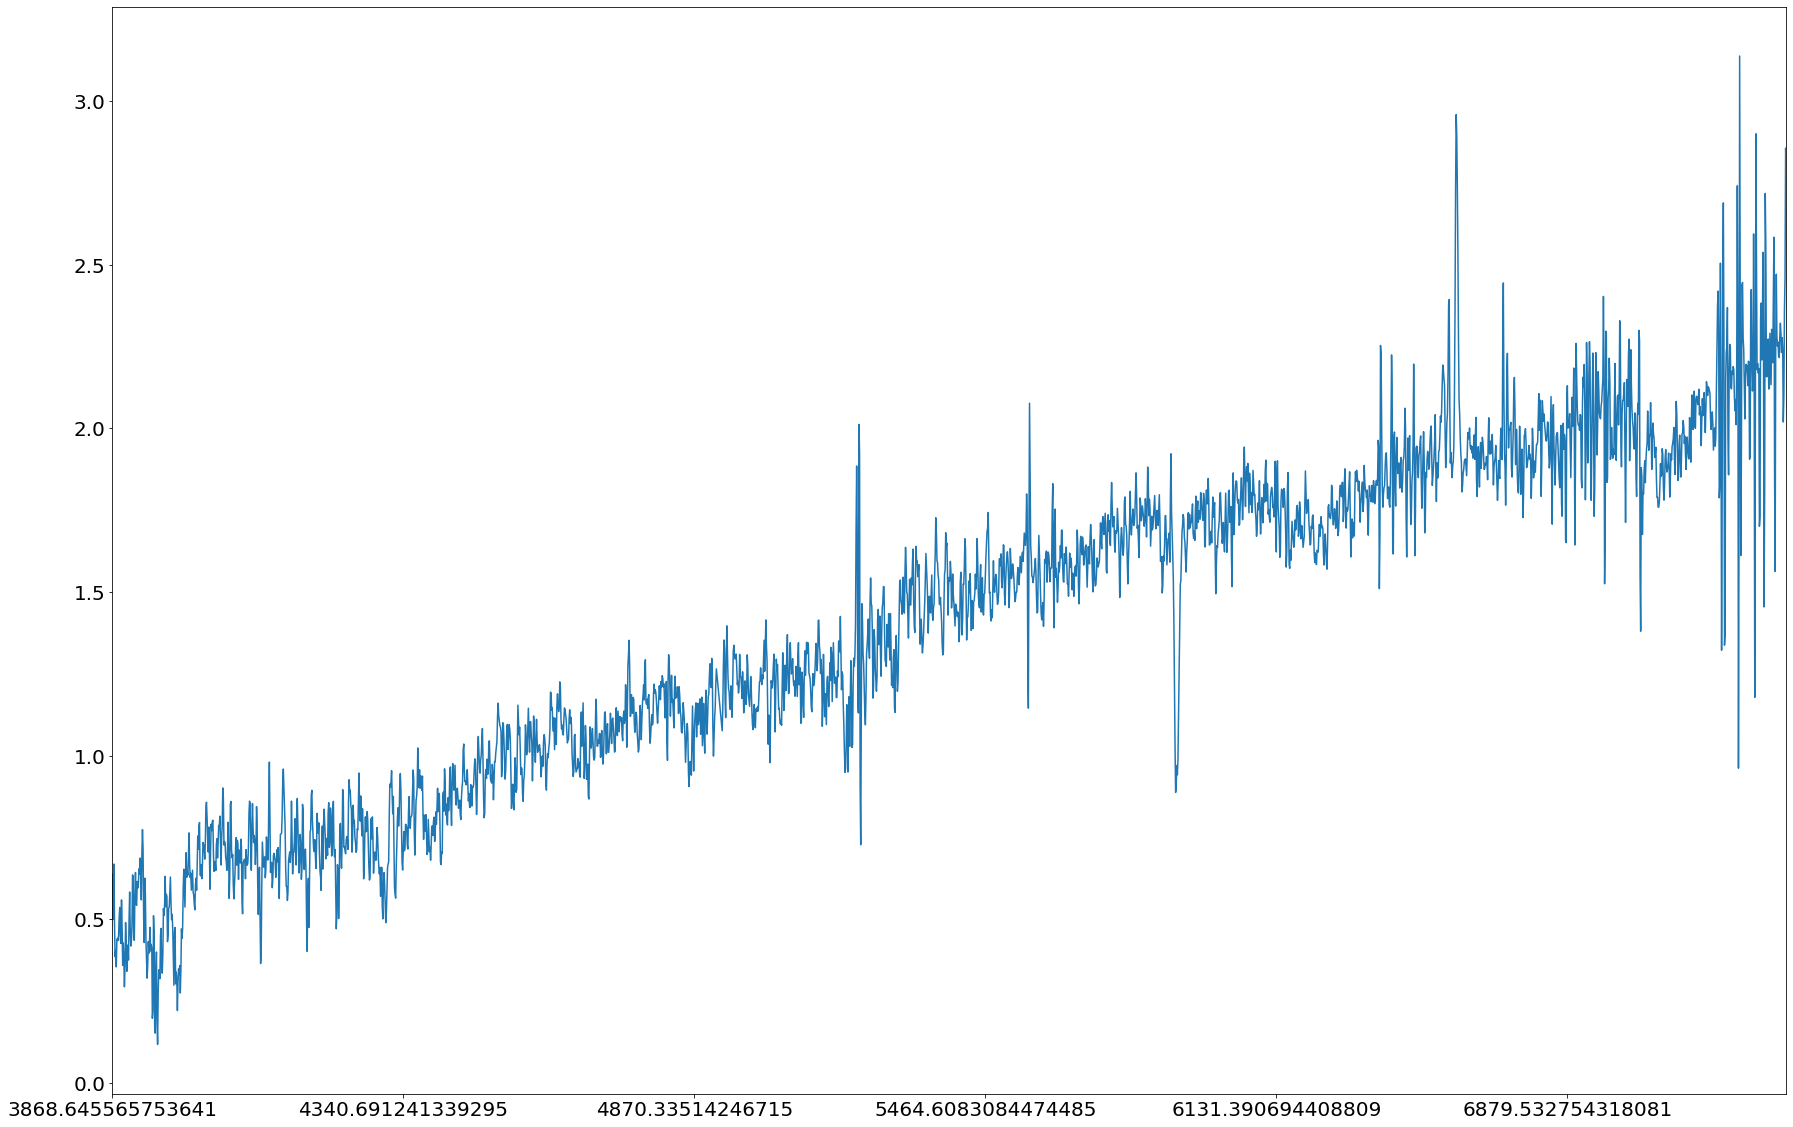

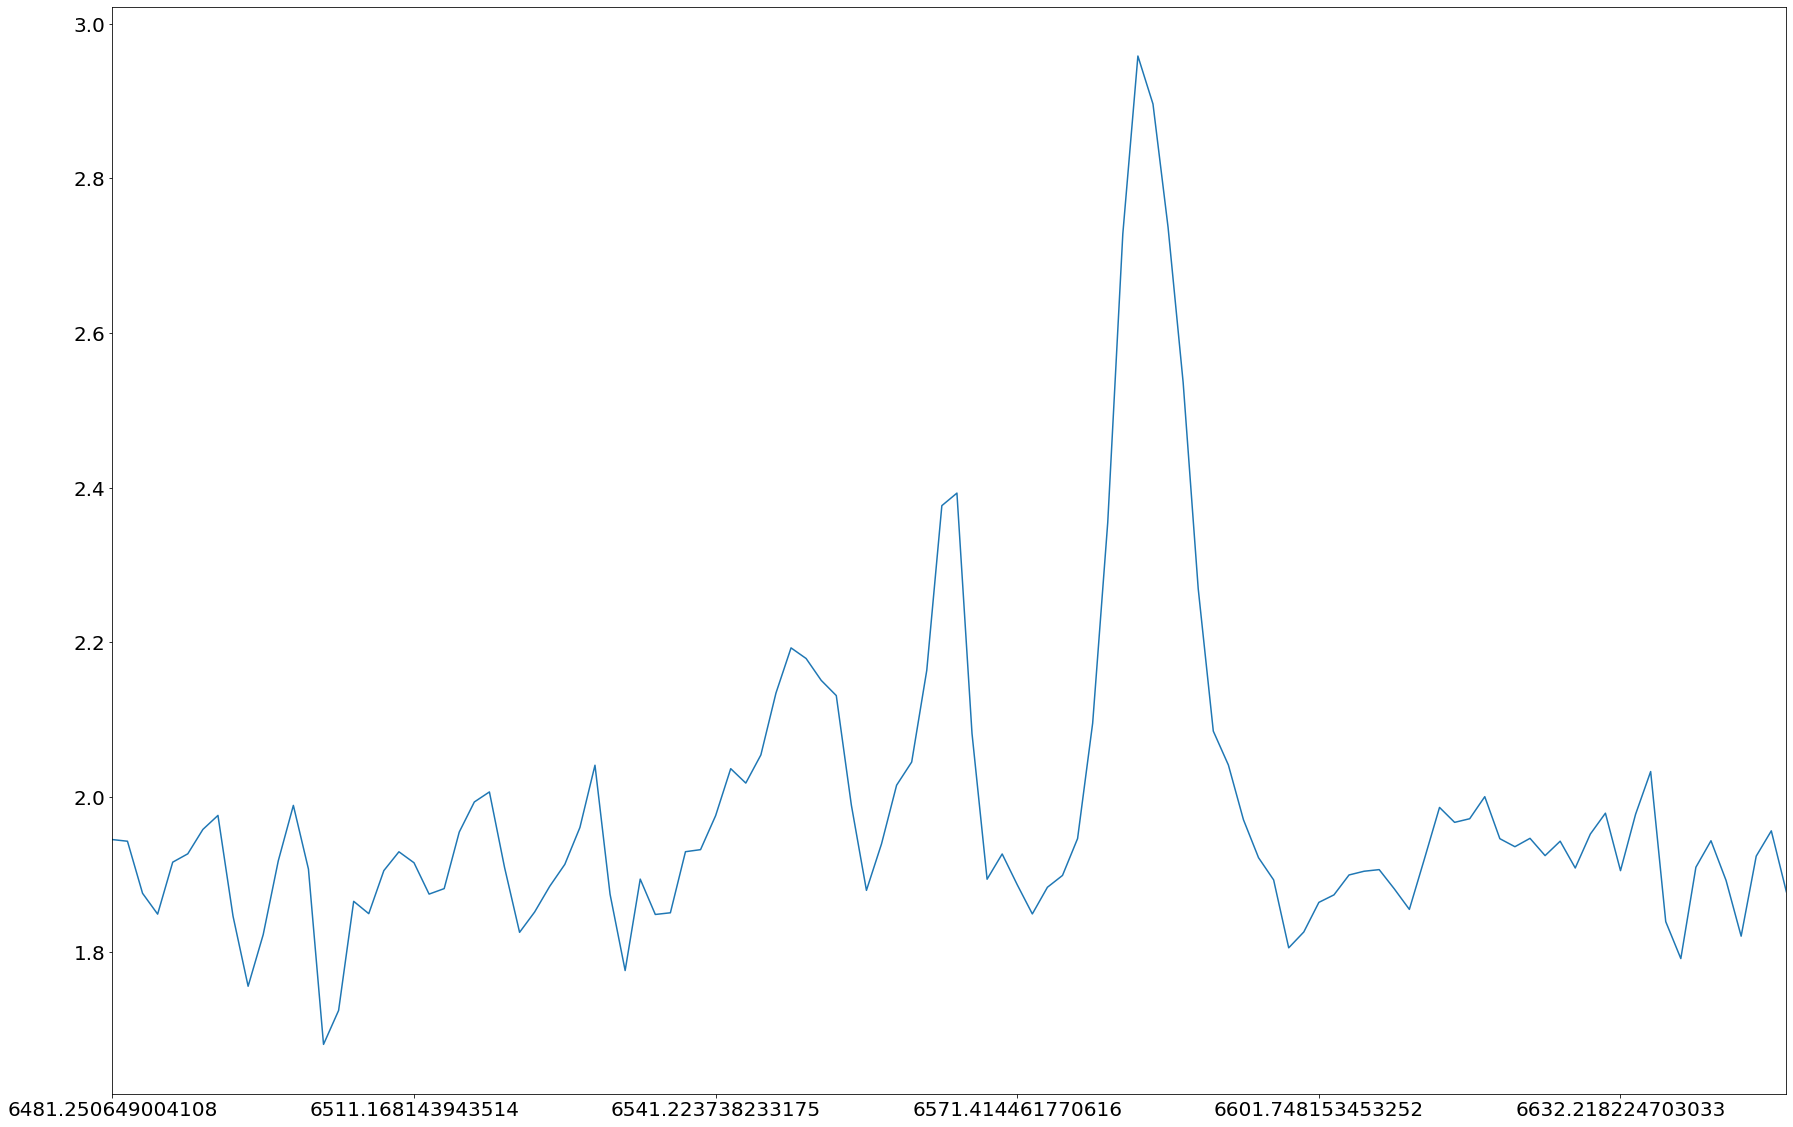

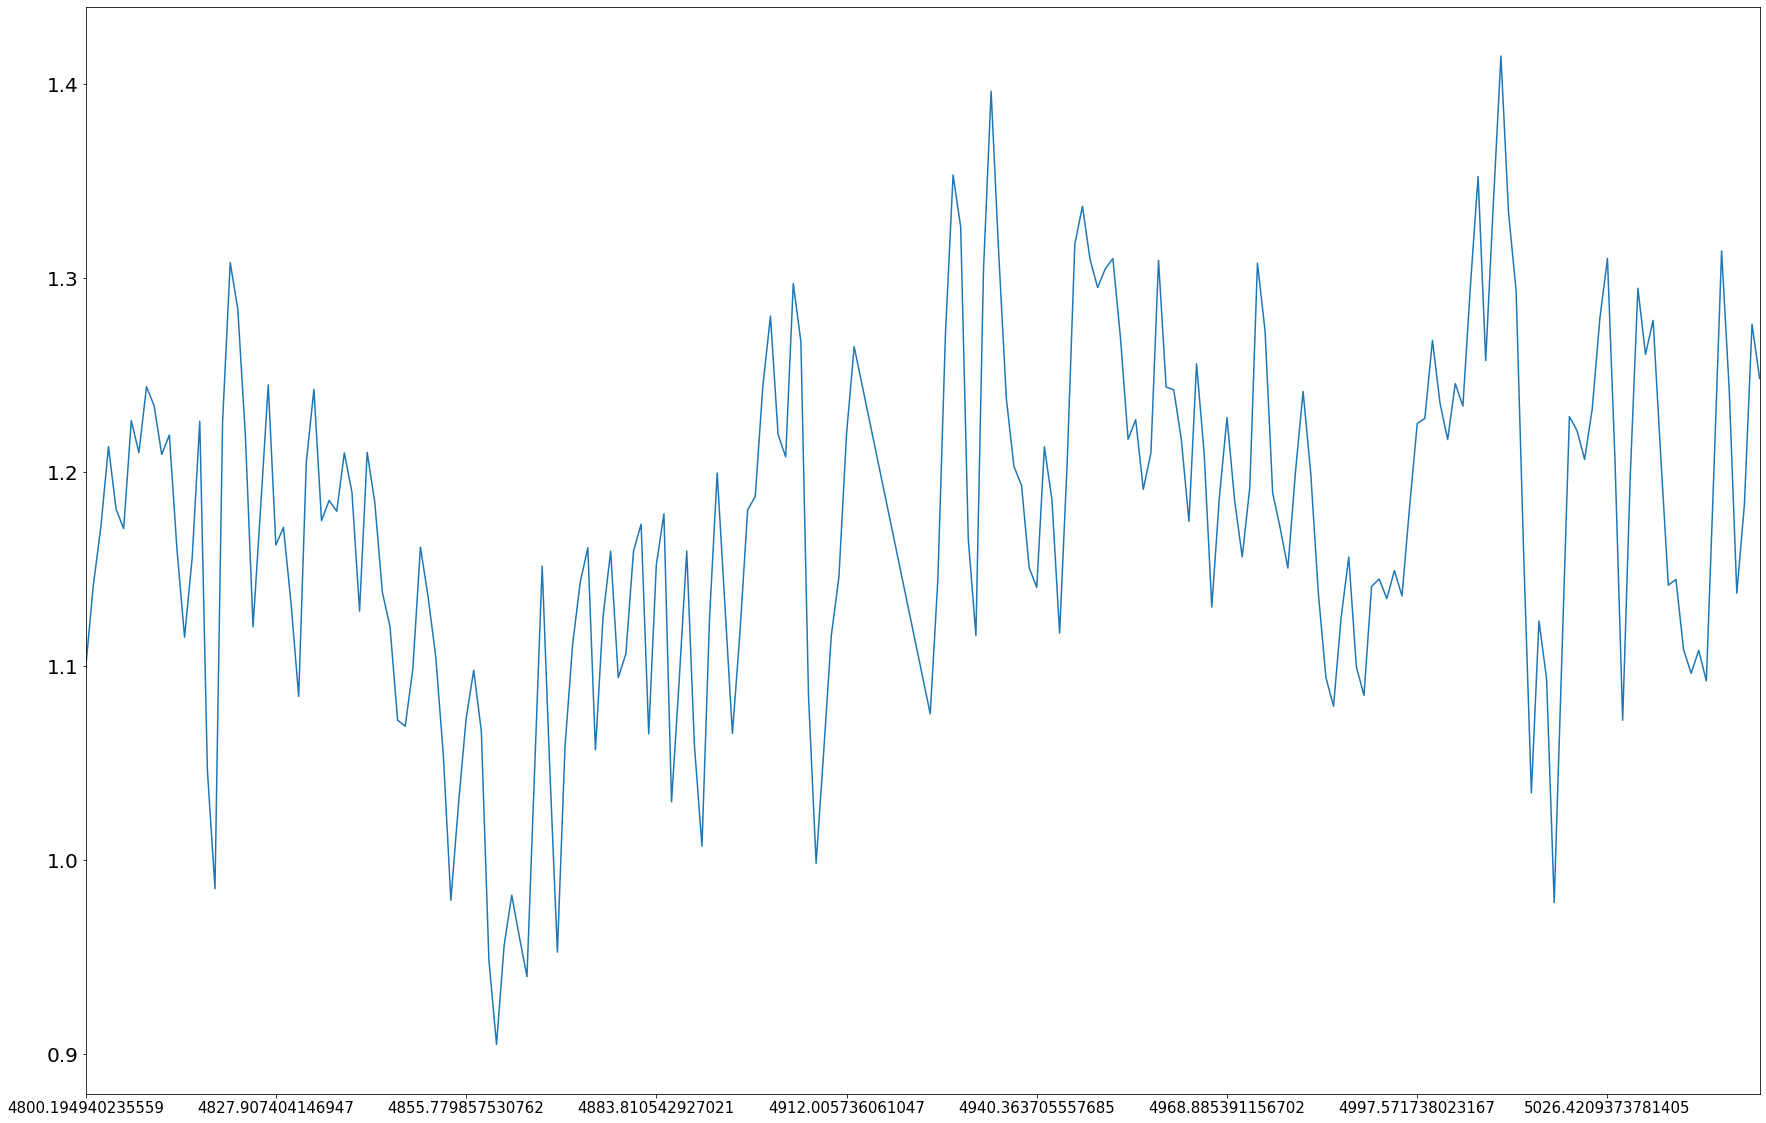

In [155]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 7)

In [41]:
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=2486046982787852288", width=800, height=640)

----------

PLATE     2208.000000
MJD      53880.000000
FIBER      218.000000
Z            0.125442
Name: 2275, dtype: float64


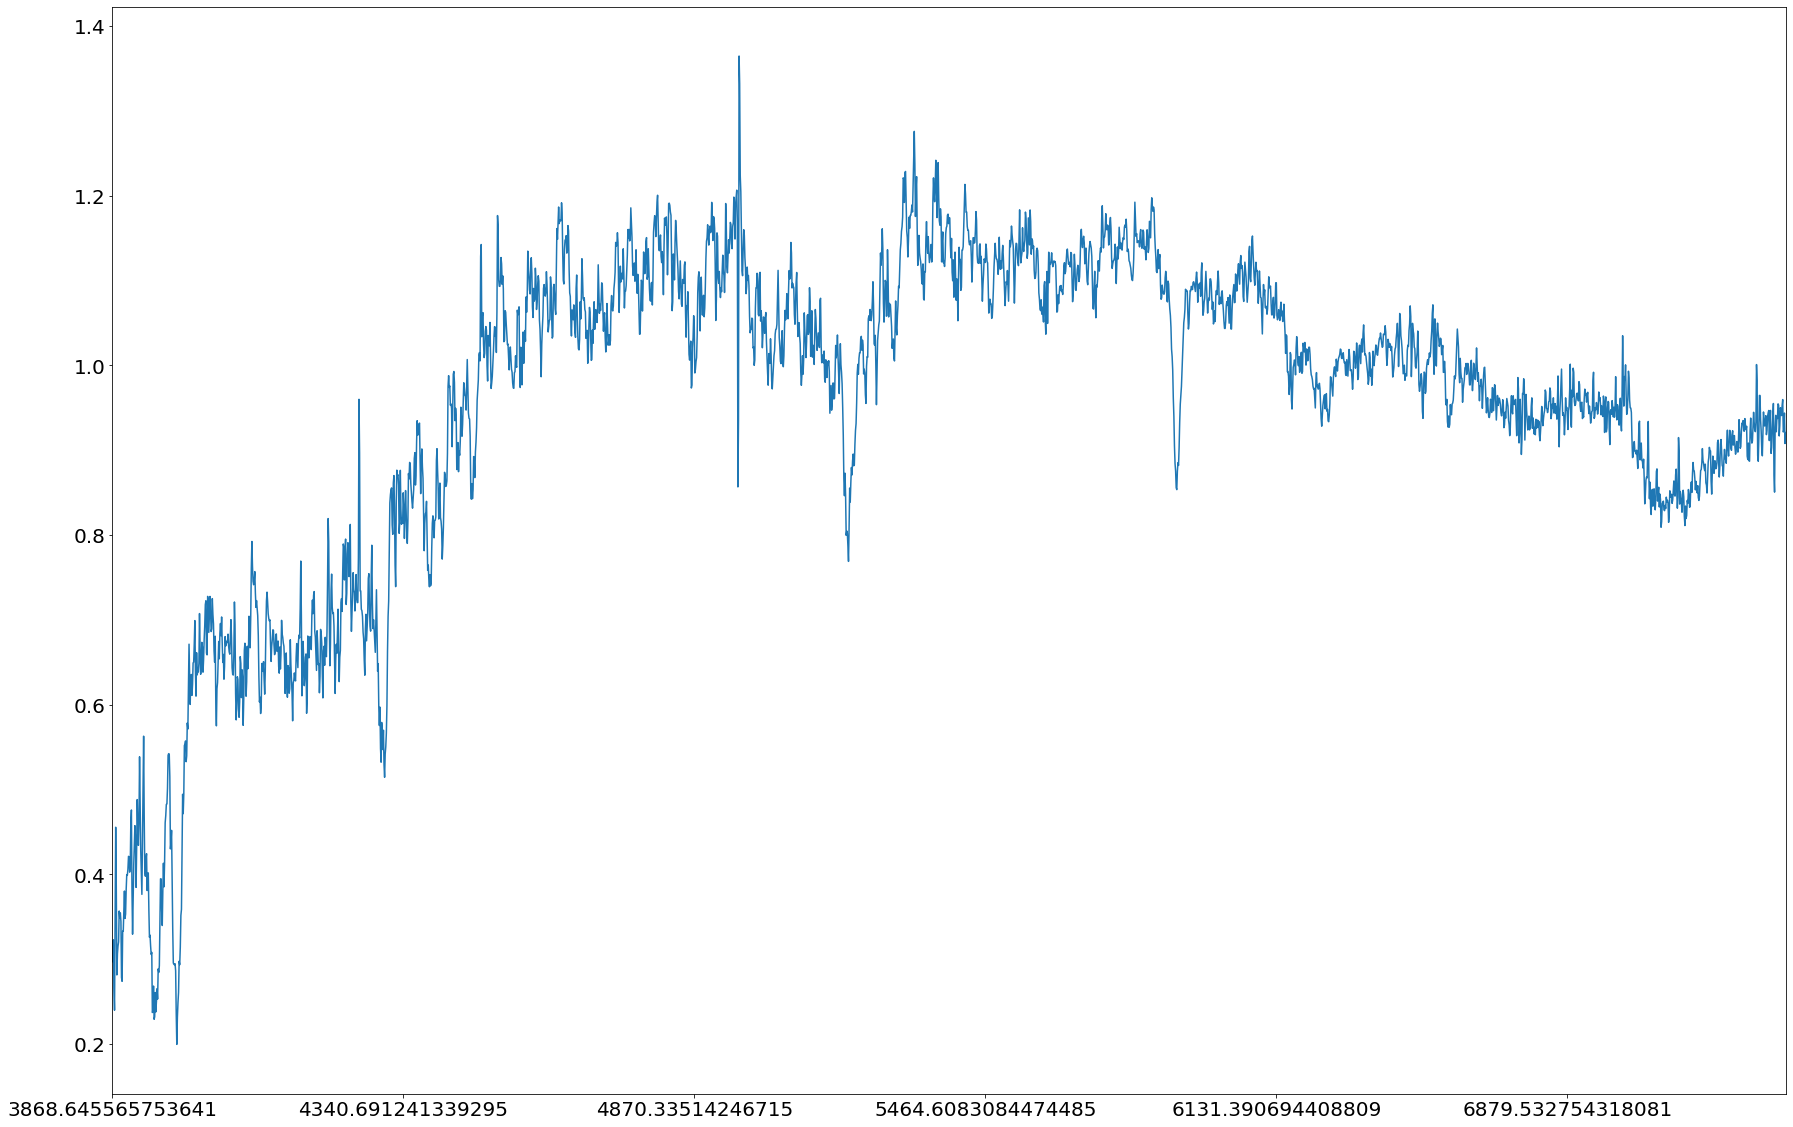

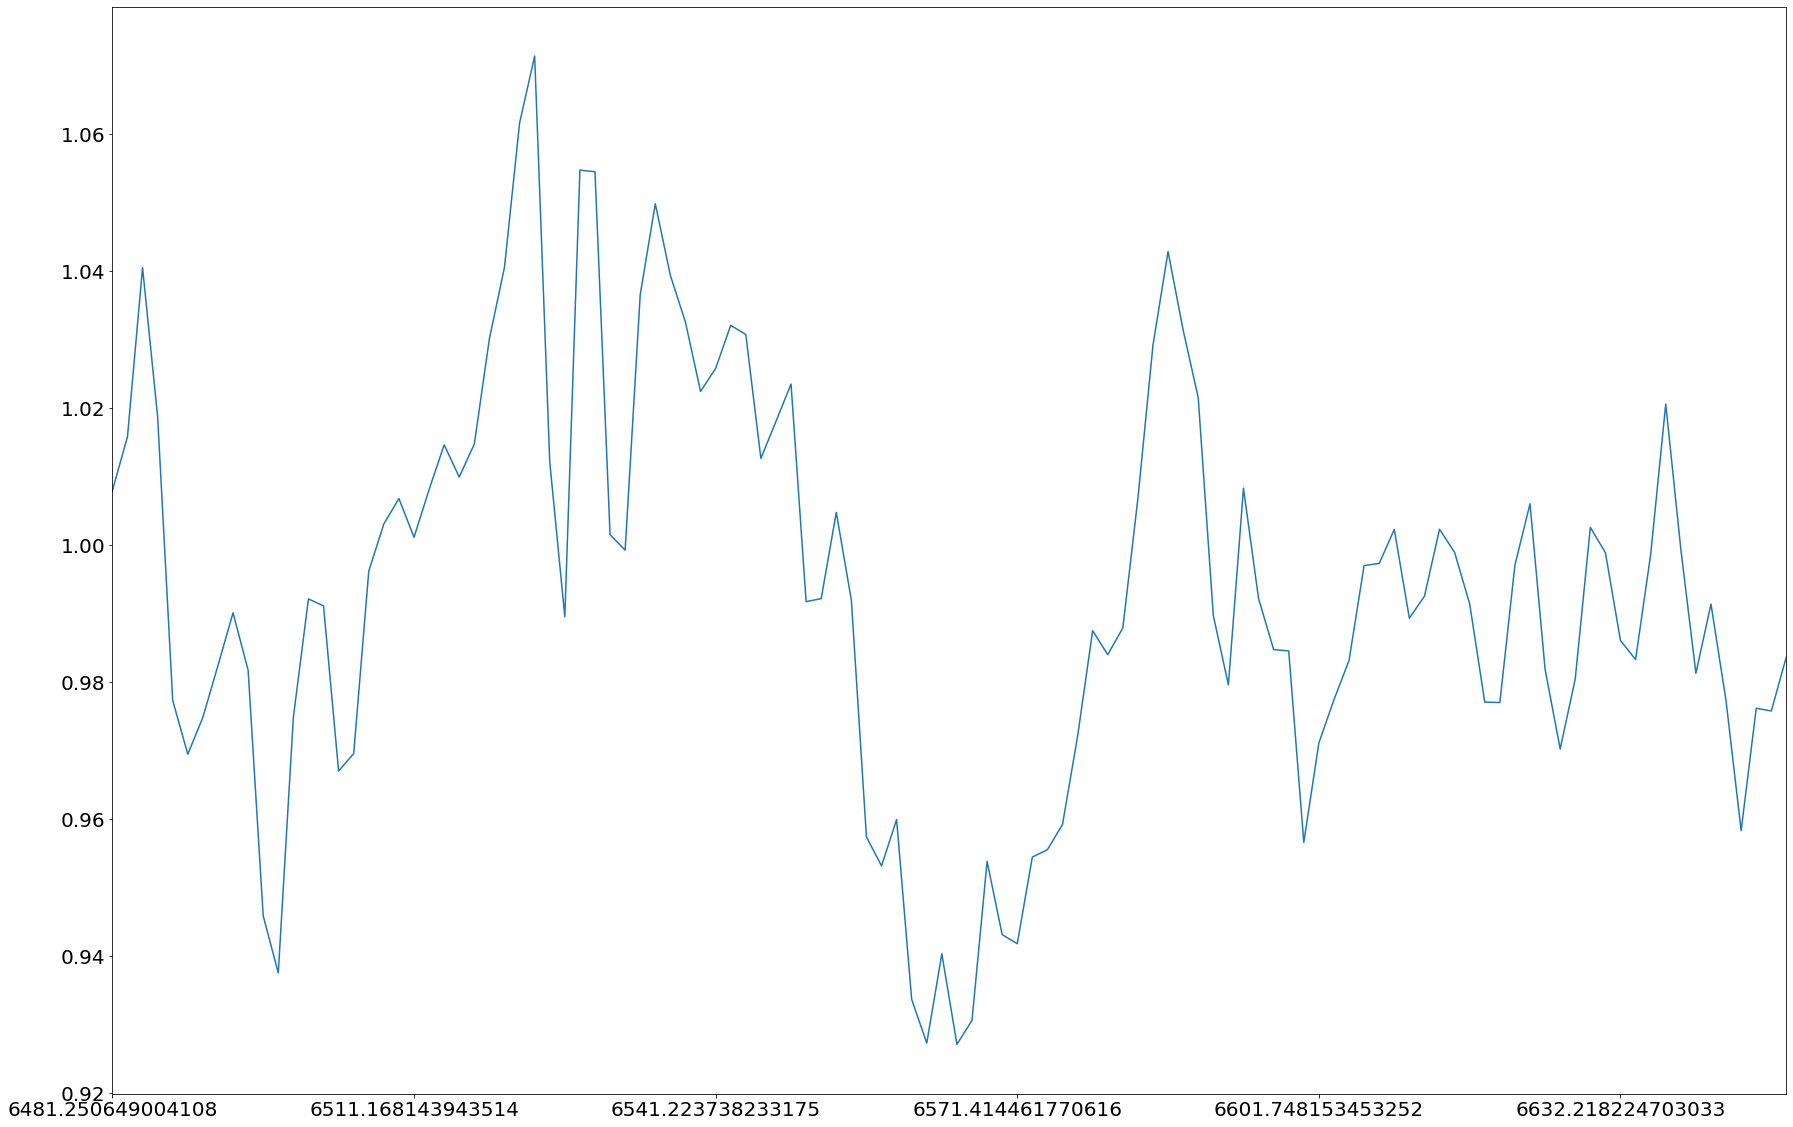

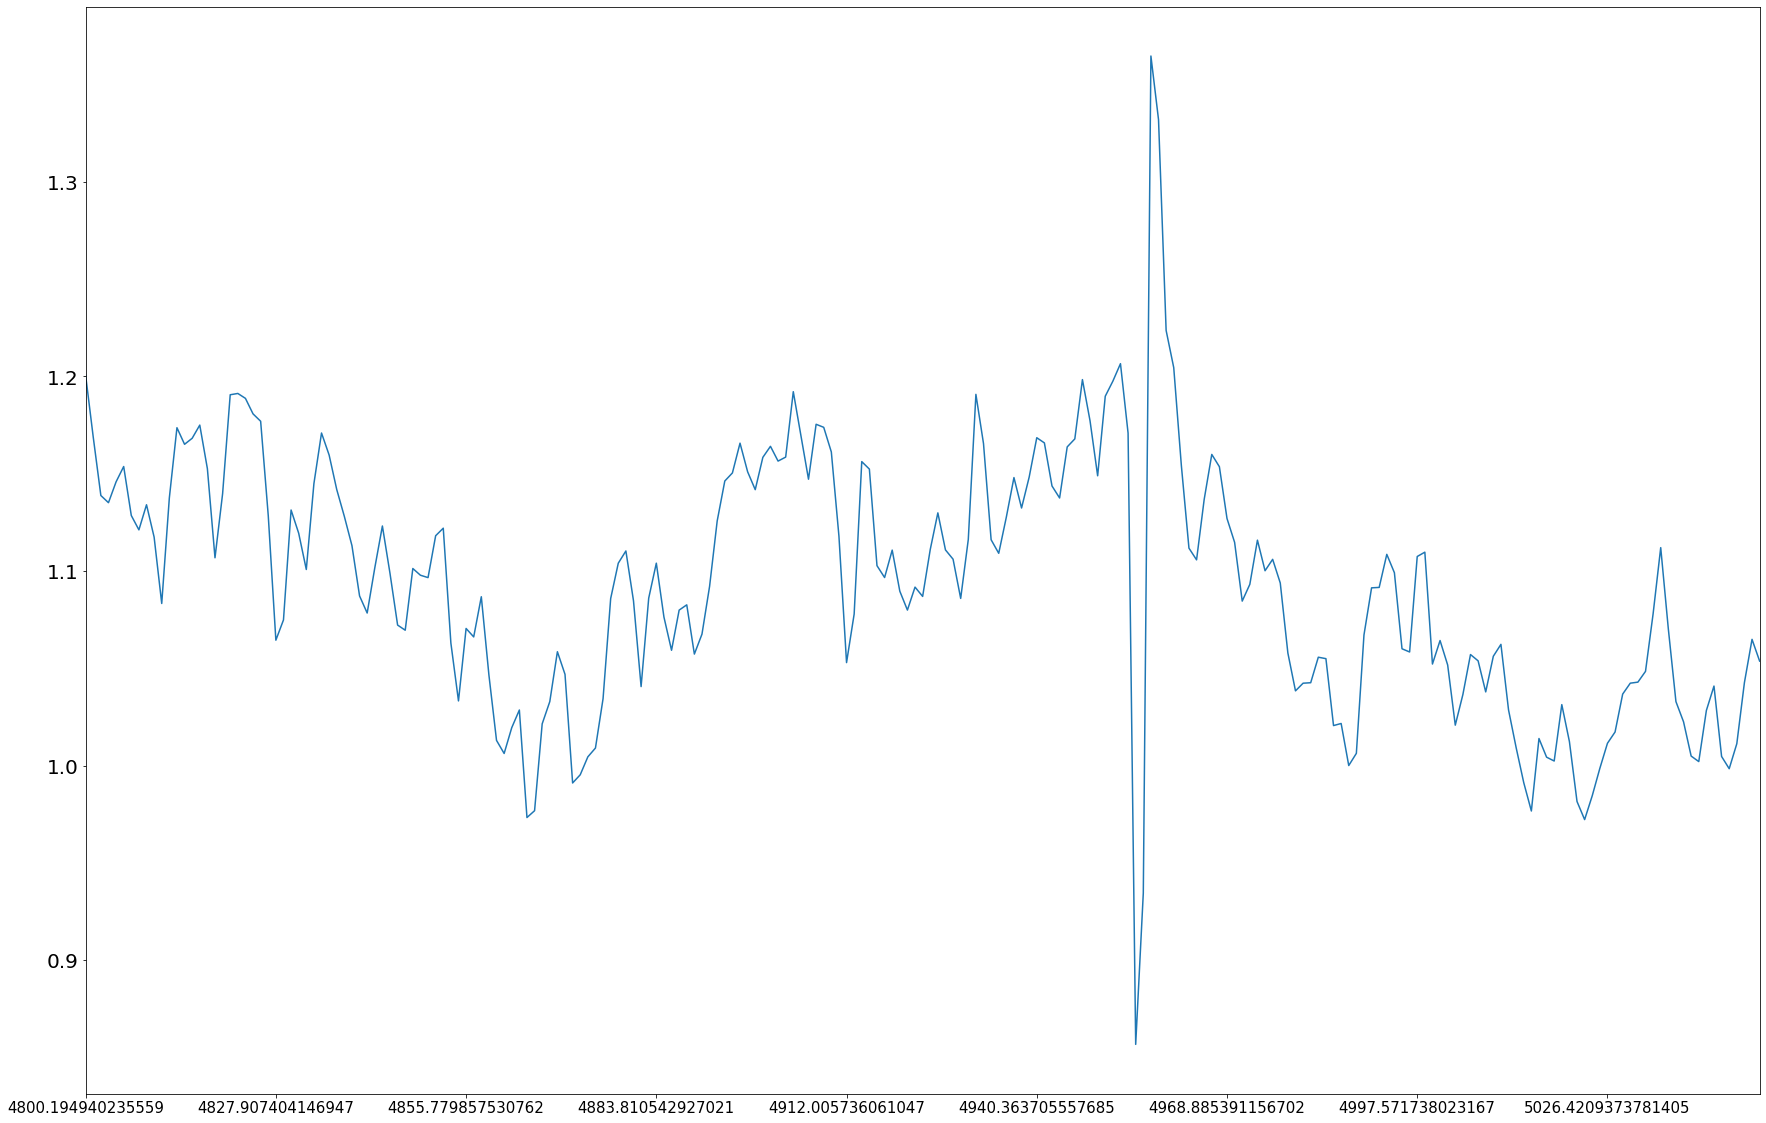

In [156]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 8)

In [42]:
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=1411928835699533824", width=800, height=640)

----------

PLATE     1254.000000
MJD      52972.000000
FIBER      183.000000
Z            0.083957
Name: 2822, dtype: float64


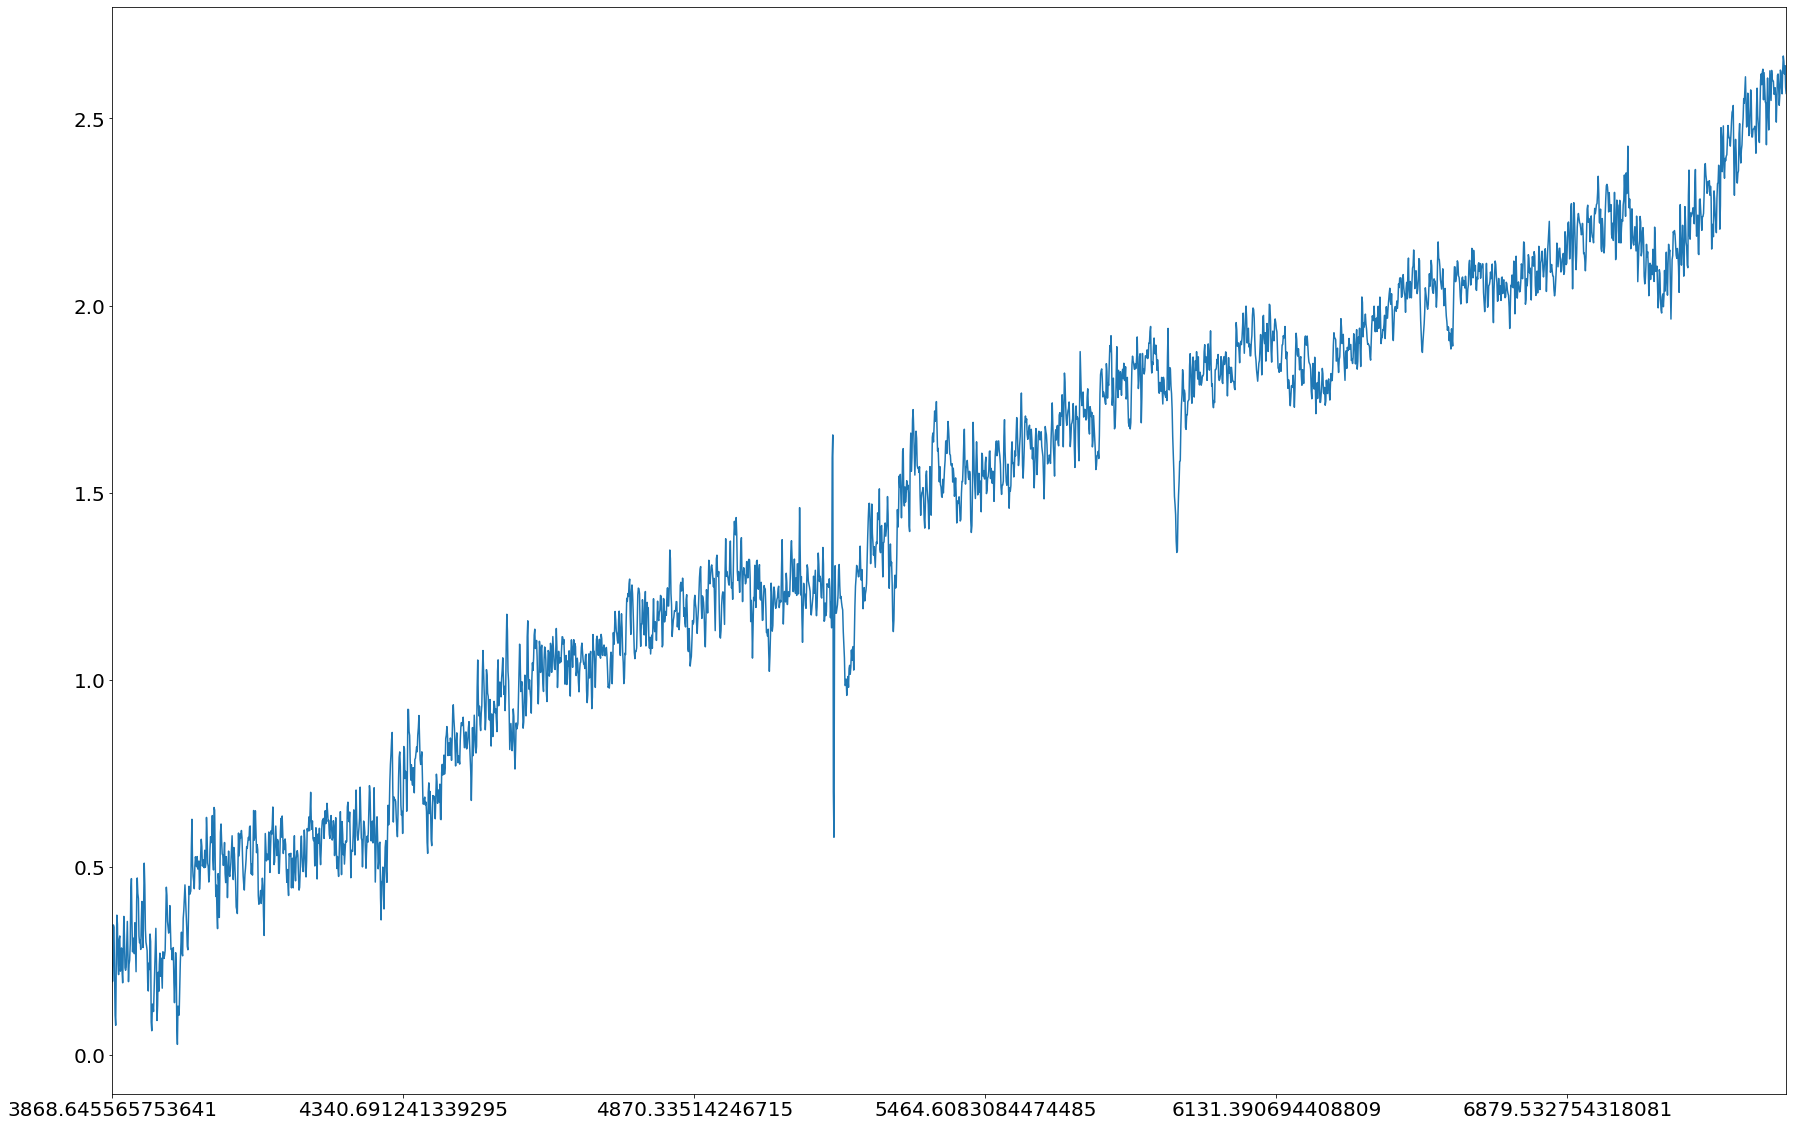

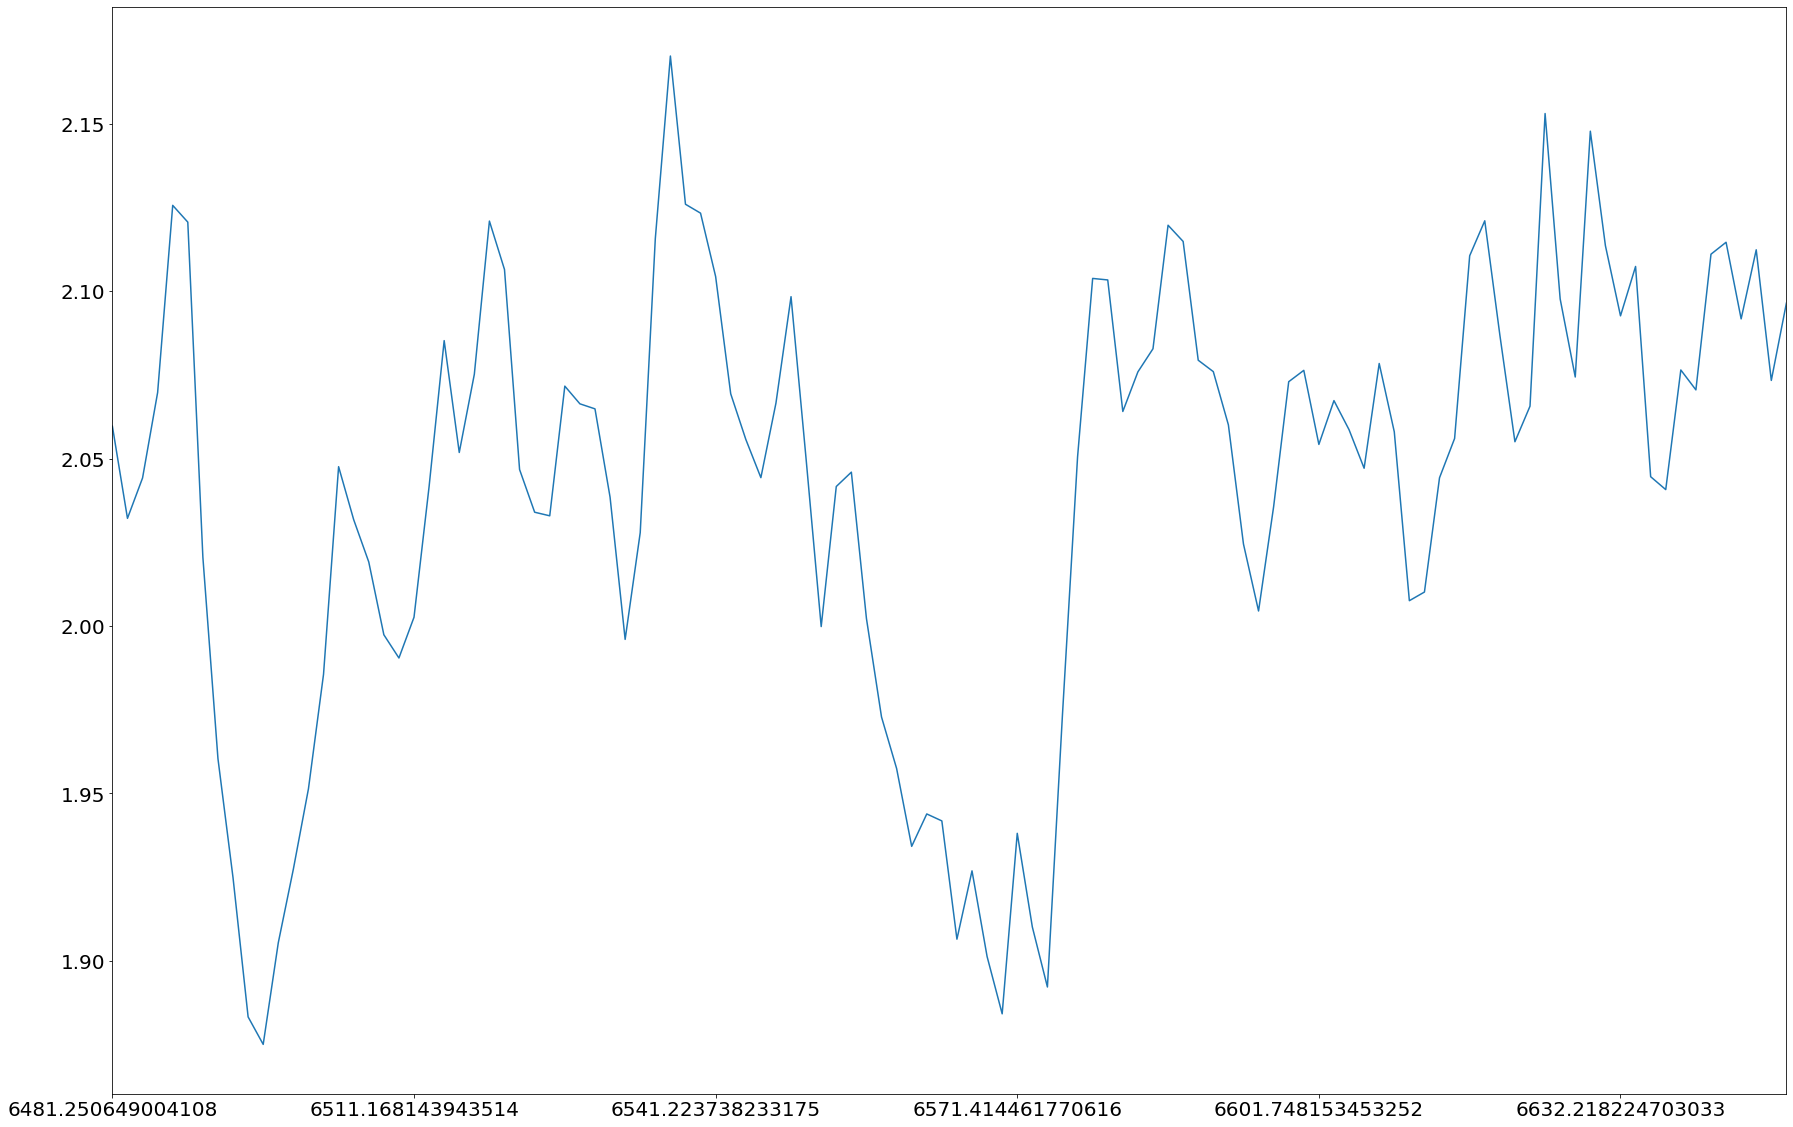

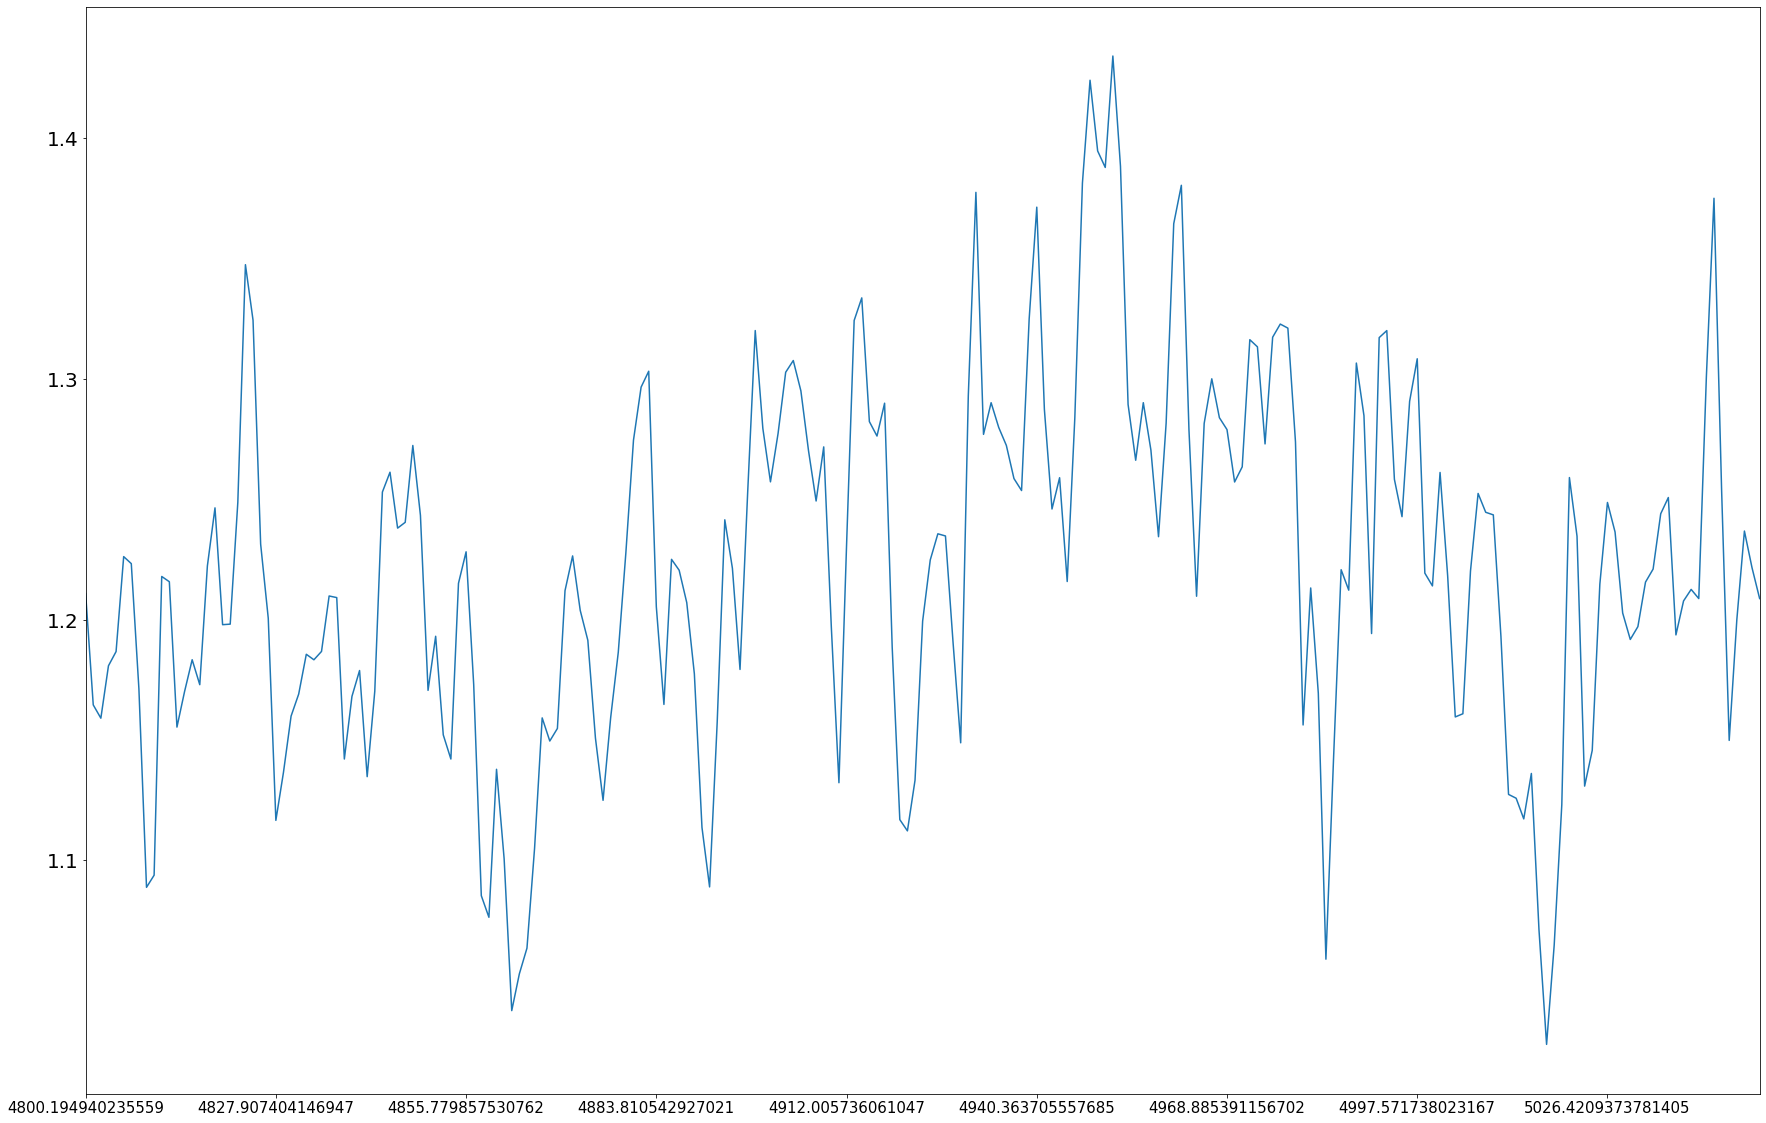

In [157]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 9)

In [43]:
Image(url= "http://skyserver.sdss.org/dr15/en/get/SpecById.ashx?id=8318282216216961024", width=800, height=640)

----------

PLATE     7388.000000
MJD      56783.000000
FIBER      486.000000
Z            0.087267
Name: 2913, dtype: float64


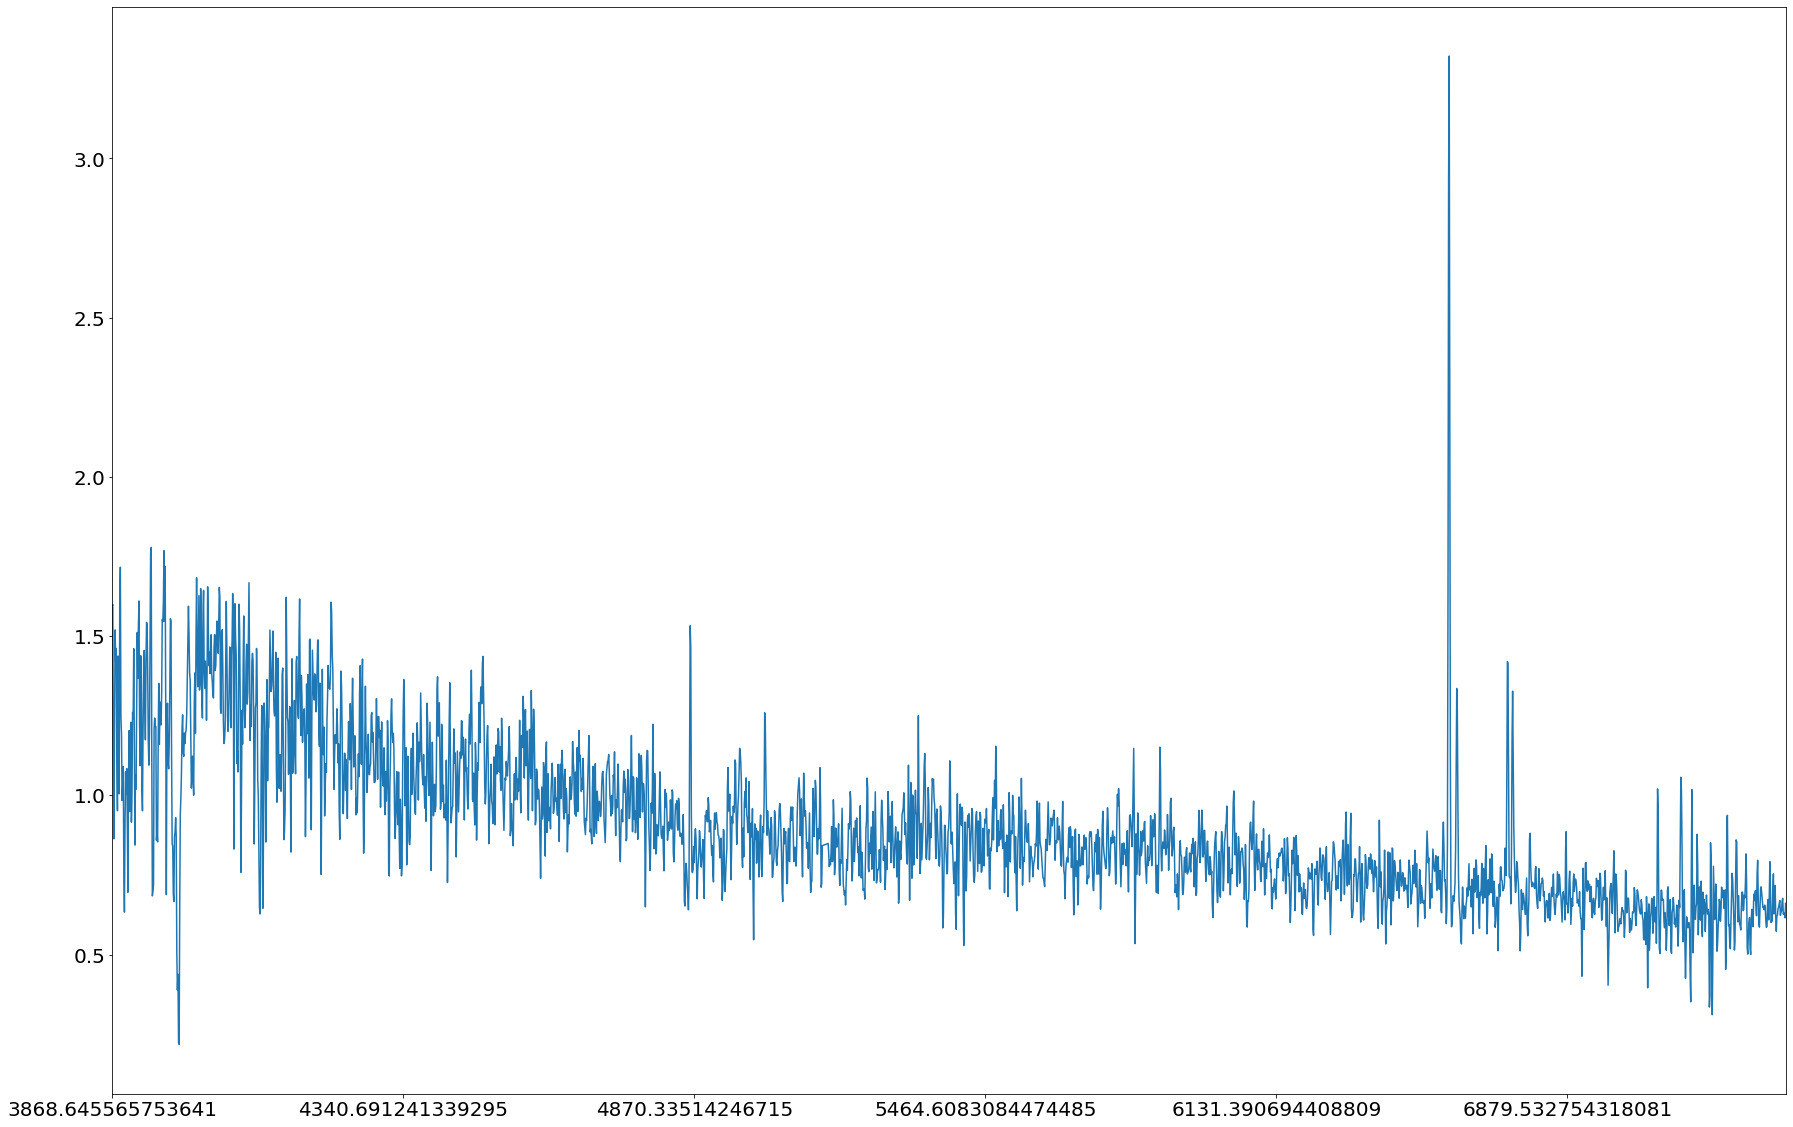

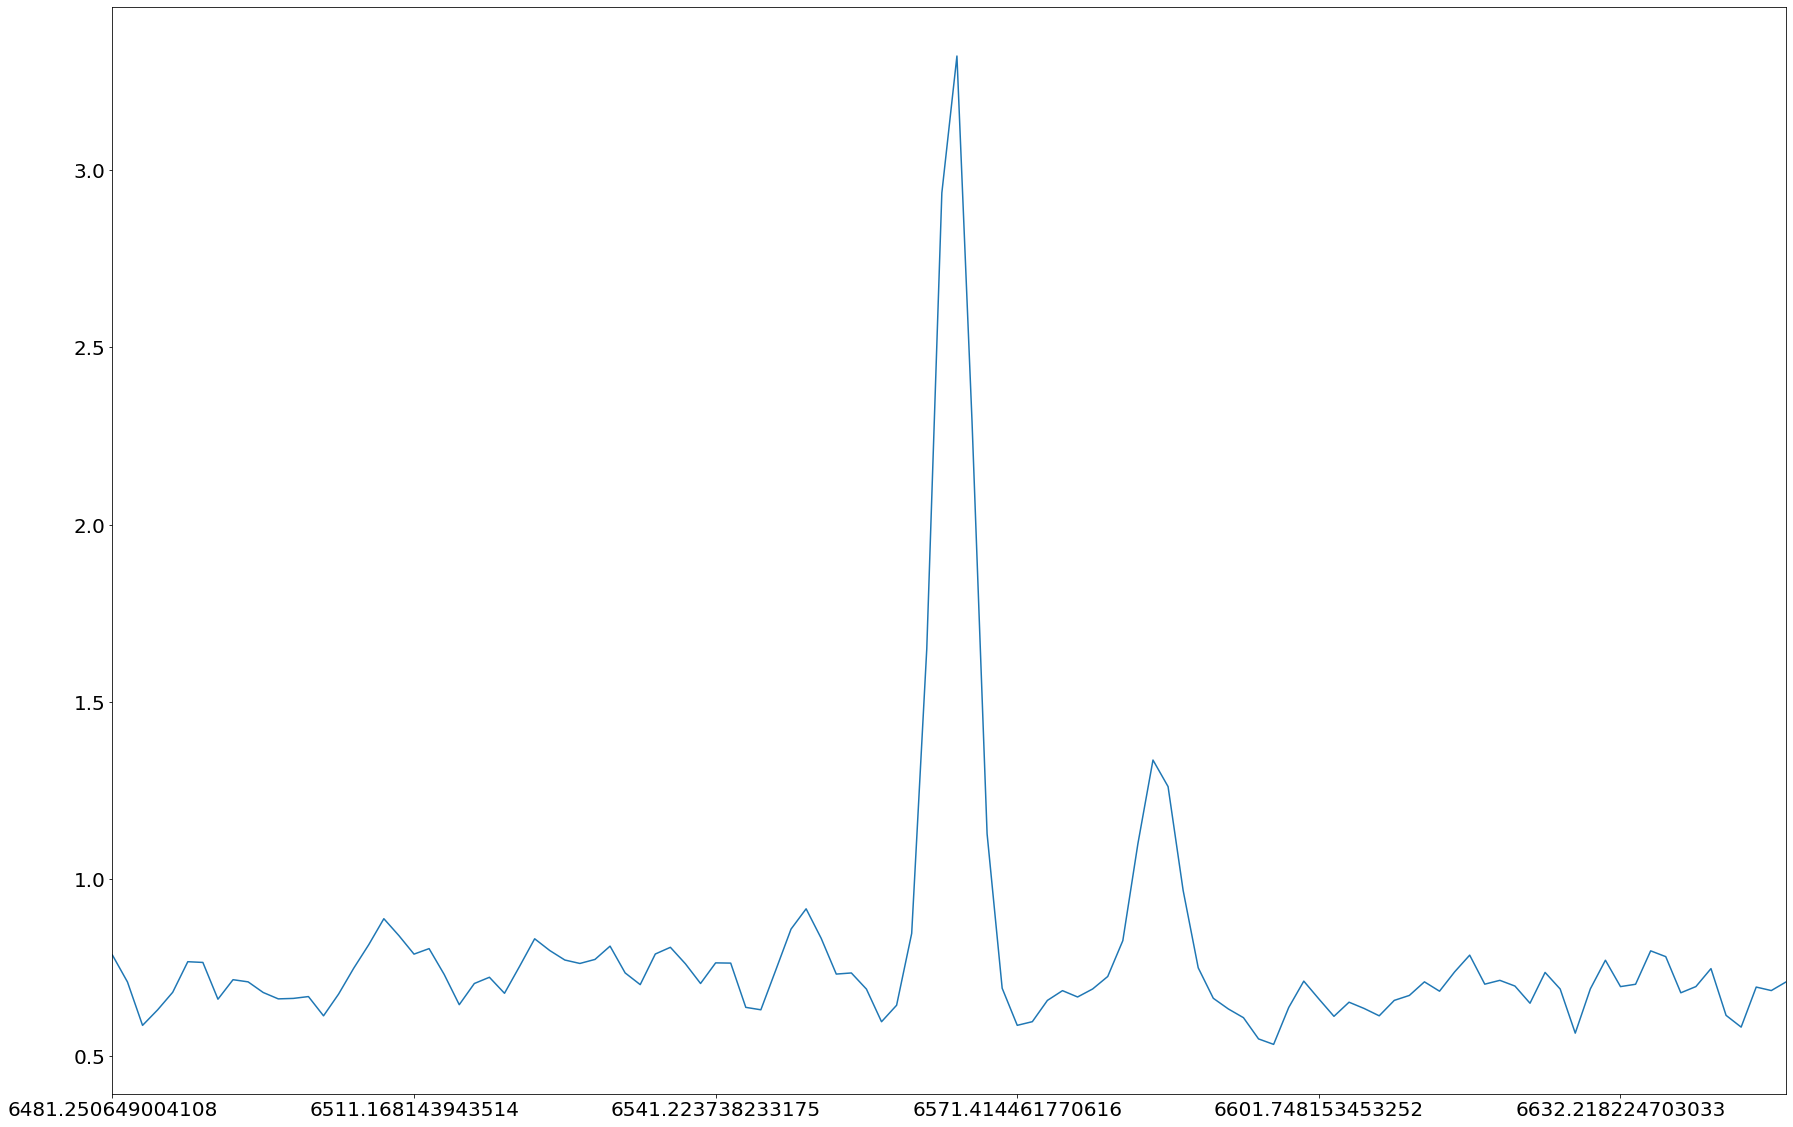

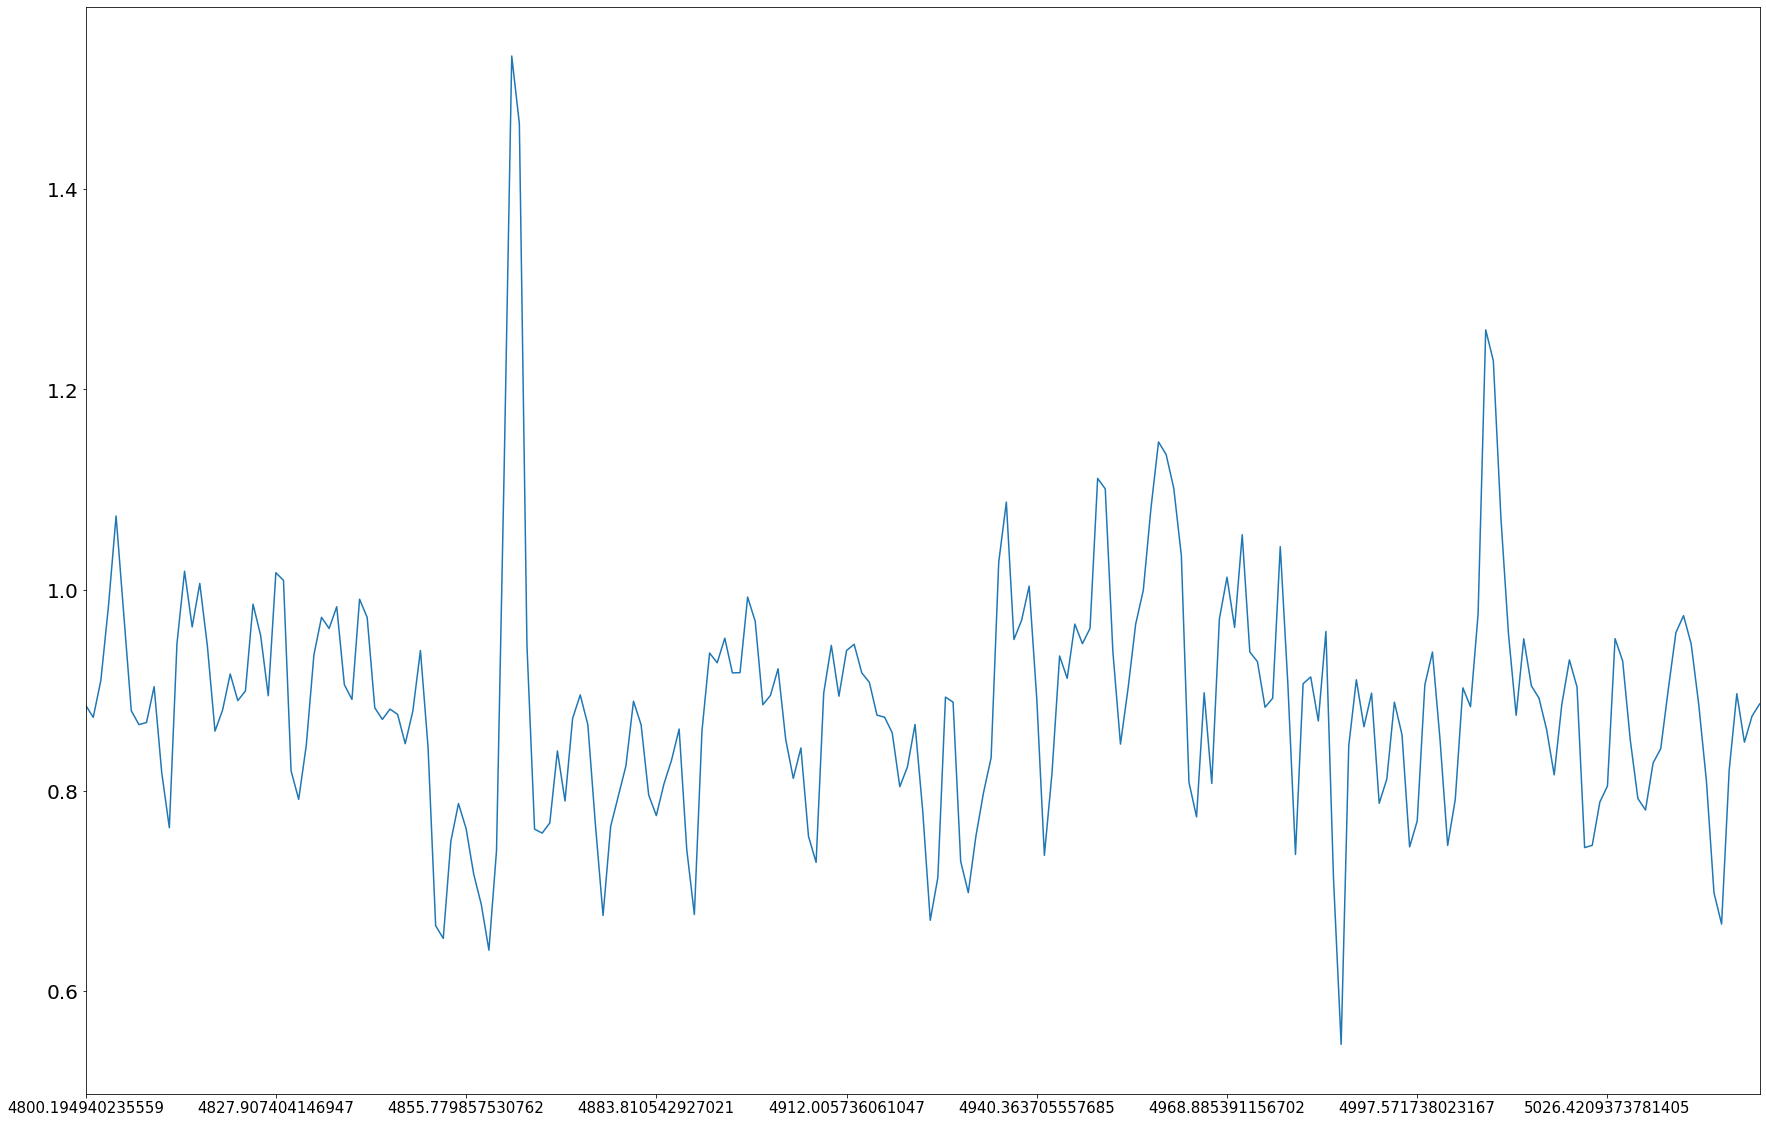

In [158]:
grafOutlier(data_origen, clusters_DBSCAN[0][0], 10)

## 2.- Gaussian Mixture Model (GMM)

GMM es una generalización de KMeans, de forma que la distribución de los clusters ya no tiene porqué ser unicamente circular, sino que es ovoide en cada uno de los clusters. Además, tenemos una salida probabilística, lo que nos da valores de probabilidad de pertenenceia de cada muestra a cada cluster.

Con esa salida probabilística, podemos sacar los outliers conforme a los parámetros que fijemos.

Los parámetros de configuración de GMM son:

* n_components, o número de clusters. Conforme hemos visto en los ejemplos anteriores y lo que salía con BIC o elbow method, tomaremos en principio 4.
* covariance_type. Hay varias posibilidades, pero usaremos "full" para que en cada cluster se calcule la matriz de covarianza.

Sin embargo, los resultados de GMM si dependen de la aleatoriedad con la que se eligen inicialmente los centroides, por lo que vamos a tener resultados diferentes cada vez que lancemos el algoritmo. Luego veremos como atacar este aspecto.

De momento, vamos a repetir el proceso de lanzar GMM 10 veces, calcular el coeficiente Silhoutte para un número variable de clusters y ver los resultados medios. Usamos como métrica "chebyshev", pero en realidad no hay apenas diferencias entre las distintas probadas.

In [161]:
# Calculamos Silhouette  
historial = []
num_max_clusters = 40
intentos_clustering = 10
historial_silhouette = np.zeros((num_max_clusters-1, intentos_clustering, 2))
for k in range(2, num_max_clusters+1, 1):
        print ("Probando GMM para " + str(k) + " clusters")
        # Repetimos el entrenamiento de clustering varias veces por la naturaleza aleatoria del proceso.
        # Luego cogemos la media de todos los intentos
        for intento in range(intentos_clustering): 
            np.random.seed(k*intento)
            clustering = GaussianMixture(n_components=k)
            cluster_labels = clustering.fit_predict(espectros_latentes)
            silhouette_avg = silhouette_score(espectros_latentes, cluster_labels, metric="chebyshev")
            historial_silhouette[k-2][intento-1] = (k, silhouette_avg)
            
print("Resultados:")
sorted(historial_silhouette.mean(axis=1), key=lambda x: x[1], reverse=True)

Probando GMM para 2 clusters
Probando GMM para 3 clusters
Probando GMM para 4 clusters
Probando GMM para 5 clusters
Probando GMM para 6 clusters
Probando GMM para 7 clusters
Probando GMM para 8 clusters
Probando GMM para 9 clusters
Probando GMM para 10 clusters
Probando GMM para 11 clusters
Probando GMM para 12 clusters
Probando GMM para 13 clusters
Probando GMM para 14 clusters
Probando GMM para 15 clusters
Probando GMM para 16 clusters
Probando GMM para 17 clusters
Probando GMM para 18 clusters
Probando GMM para 19 clusters
Probando GMM para 20 clusters
Probando GMM para 21 clusters
Probando GMM para 22 clusters
Probando GMM para 23 clusters
Probando GMM para 24 clusters
Probando GMM para 25 clusters
Probando GMM para 26 clusters
Probando GMM para 27 clusters
Probando GMM para 28 clusters
Probando GMM para 29 clusters
Probando GMM para 30 clusters
Probando GMM para 31 clusters
Probando GMM para 32 clusters
Probando GMM para 33 clusters
Probando GMM para 34 clusters
Probando GMM para 

[array([2.        , 0.64443514]),
 array([3.        , 0.48526195]),
 array([4.        , 0.46842651]),
 array([5.        , 0.44492976]),
 array([6.        , 0.41468291]),
 array([7.        , 0.41061324]),
 array([8.        , 0.38376817]),
 array([9.       , 0.3550895]),
 array([10.        ,  0.34378709]),
 array([13.        ,  0.34136239]),
 array([11.        ,  0.33763617]),
 array([14.        ,  0.33522065]),
 array([15.        ,  0.33277482]),
 array([12.        ,  0.33237097]),
 array([16.        ,  0.32924875]),
 array([17.        ,  0.32638996]),
 array([18.        ,  0.32355203]),
 array([19.        ,  0.32155292]),
 array([20.       ,  0.3173633]),
 array([21.        ,  0.31265804]),
 array([22.        ,  0.31130494]),
 array([23.        ,  0.30310013]),
 array([24.        ,  0.30297156]),
 array([25.        ,  0.29535774]),
 array([26.        ,  0.29388106]),
 array([27.        ,  0.29340485]),
 array([28.        ,  0.28834376]),
 array([29.        ,  0.28782153]),
 array([30. 

Por tanto, tenemos las mismas conclusiones que con DBSCAN: no parece que sean recomendables más de dos clusters. Sin embargo, vamos a analizar los resultados tomando 7 clusters, que aún arroja un coeficiente relativamente decente. Estudiaremos la posible aleatoriedad de los resultados y cómo afecta a la creación de los clusters.

Para ello, repetiremos el lanzamiento de GMM varias veces y guardaremos los resultados de los clusters resultantes.

In [16]:
num_clusters = 7
clusters_GMM = []
num_repeticiones = 10

for iter in range(num_repeticiones):
    clustering = GaussianMixture(n_components=num_clusters).fit(espectros_latentes)
    labels = clustering.predict(espectros_latentes)
    for i in range(num_clusters):
        clusters_GMM.append([iter, i, np.where(labels==i)])

In [50]:
clusters_GMM

[[0,
  0,
  (array([   6,    9,   14,   19,   20,   25,   32,   33,   35,   37,   39,
            41,   42,   56,   61,   69,   70,   73,   76,   84,   89,   92,
           104,  107,  109,  111,  114,  116,  118,  131,  135,  140,  141,
           146,  155,  156,  158,  159,  163,  165,  167,  169,  178,  180,
           181,  183,  184,  196,  200,  213,  214,  223,  225,  228,  231,
           232,  234,  237,  239,  245,  249,  251,  255,  260,  268,  269,
           272,  274,  278,  280,  293,  294,  315,  327,  328,  330,  331,
           335,  339,  342,  350,  355,  366,  368,  384,  388,  391,  393,
           395,  396,  399,  403,  404,  410,  411,  416,  421,  427,  434,
           435,  438,  442,  447,  449,  460,  461,  470,  477,  479,  481,
           487,  488,  489,  494,  498,  505,  529,  531,  536,  549,  556,
           557,  561,  563,  568,  569,  572,  574,  576,  577,  578,  587,
           591,  596,  597,  600,  607,  608,  615,  621,  626,  633,  635,
  

No existe ninguna uniformidad ante cada reproducción de GMM, con clusters donde no persisten todos los elementos ni son de tamaños consistentes.

Seguiremos explorando este efecto, pero antes vamos a escoger uno de los resultados y crear un dataset con todas las galaxias, pero solo los datos de identificación y clusters resultantes, eliminando los datos de espectros. Esto servirá para la implementación en Azure.

In [20]:
repres = 3  # Grabaremso también una representación en 3D del espacio latente
columns = ['PLATE', 'MJD', 'FIBER', 'Z', 'cluster']
if repres > 0:
    columns.extend(["x_lat", "y_lat"])
    if repres == 3:
        columns.append("z_lat")
data_output = pd.DataFrame(data_origen, columns=columns) # Copiamos los datos de identificación en el nuevo dataset
data_output

PLATE    MJD  FIBER         Z  cluster  x_lat  y_lat  z_lat
1      1815  53884      1  0.091045      NaN    NaN    NaN    NaN
2       699  52202     92  0.043789      NaN    NaN    NaN    NaN
3      1924  53330    267  0.212605      NaN    NaN    NaN    NaN
4      5440  55983    132  0.237888      NaN    NaN    NaN    NaN
5      6035  56076     28  0.224676      NaN    NaN    NaN    NaN
6       687  52518    140  0.090599      NaN    NaN    NaN    NaN
7      2595  54207    561  0.066672      NaN    NaN    NaN    NaN
8       861  52318    183  0.086399      NaN    NaN    NaN    NaN
9       512  51992    220  0.072583      NaN    NaN    NaN    NaN
10     2291  53714    166  0.033852      NaN    NaN    NaN    NaN
11      449  51900    390  0.041362      NaN    NaN    NaN    NaN
12     2956  54525    616  0.079879      NaN    NaN    NaN    NaN
13     1972  53466    615  0.132886      NaN    NaN    NaN    NaN
17     2238  54205     99  0.086724      NaN    NaN    NaN    NaN
19      826  52295     68  0.128945      NaN    NaN    NaN    NaN
21     1357  53034    299  0.056227      NaN    NaN    NaN    NaN
22      788  52338    209  0.093721      NaN    NaN    NaN    NaN
23     1288  52731    125  0.095887      NaN    NaN    NaN    NaN
24     4998  55722    248  0.202980      NaN    NaN    NaN    NaN
25      481  51908    114  0.098608      NaN    NaN    NaN    NaN
26     2421  54153    382  0.200322      NaN    NaN    NaN    NaN
27      508  52366    356  0.066512      NaN    NaN    NaN    NaN
29      779  52342     63  0.055380      NaN    NaN    NaN    NaN
30     1270  52991     51  0.070957      NaN    NaN    NaN    NaN
32     2245  54208    176  0.073834      NaN    NaN    NaN    NaN
33     2221  53792      6  0.155564      NaN    NaN    NaN    NaN
34      942  52703    179  0.222280      NaN    NaN    NaN    NaN
35     2604  54484    456  0.097399      NaN    NaN    NaN    NaN
36     2509  54180     84  0.125556      NaN    NaN    NaN    NaN
37     1959  53440    602  0.081640      NaN    NaN    NaN    NaN
38     4741  55704     16  0.075019      NaN    NaN    NaN    NaN
39     1365  53062    335  0.086515      NaN    NaN    NaN    NaN
41     2238  54205    555  0.021993      NaN    NaN    NaN    NaN
42     1367  53083    490  0.129369      NaN    NaN    NaN    NaN
43     1559  53271    292  0.072869      NaN    NaN    NaN    NaN
45      940  52670     66  0.119162      NaN    NaN    NaN    NaN
47     2507  53876    102  0.109826      NaN    NaN    NaN    NaN
48     1030  52914    606  0.122876      NaN    NaN    NaN    NaN
49     1165  52703    113  0.053747      NaN    NaN    NaN    NaN
50      713  52178     81  0.139458      NaN    NaN    NaN    NaN
51      450  51908    349  0.105671      NaN    NaN    NaN    NaN
52     1982  53436     44  0.202005      NaN    NaN    NaN    NaN
53     1948  53388    474  0.095610      NaN    NaN    NaN    NaN
55     2093  53818    315  0.067273      NaN    NaN    NaN    NaN
56     1404  52825    506  0.054683      NaN    NaN    NaN    NaN
57     1811  53533    583  0.082758      NaN    NaN    NaN    NaN
59     2218  53816    170  0.100800      NaN    NaN    NaN    NaN
60     8168  56992    286  0.163115      NaN    NaN    NaN    NaN
61      419  51879    550  0.077710      NaN    NaN    NaN    NaN
62      730  52466    104  0.076278      NaN    NaN    NaN    NaN
...     ...    ...    ...       ...      ...    ...    ...    ...
2855    796  52401     58  0.032469      NaN    NaN    NaN    NaN
2856    483  51924    277  0.045427      NaN    NaN    NaN    NaN
2857   1359  53002    233  0.094227      NaN    NaN    NaN    NaN
2858   1371  52821    259  0.075164      NaN    NaN    NaN    NaN
2859   4381  55824    914  0.058183      NaN    NaN    NaN    NaN
2860    883  52430    430  0.082477      NaN    NaN    NaN    NaN
2861   6663  56338    659  0.025319      NaN    NaN    NaN    NaN
2863    749  52226    593  0.168703      NaN    NaN    NaN    NaN
2864   1933  53381    329  0.061582      NaN  

In [21]:
#Cogemos únicamente el intento 0
GMM_intento_0 = [clusters_GMM[i] for i in range(len(clusters_GMM)) if clusters_GMM[i][0]==0]
GMM_intento_0[0][1] # (n, m) - n=cluster; m=2

0

In [22]:
## Recorremos todo el dataset 
for item in range(len(data_origen)):
    # En cada espectro, vemos cual es el cluster que se le ha asignado. Primero vemos si es un outlier o no
    if item in np.array(clusters_DBSCAN[0]):
        data_output["cluster"].iloc[item] = -1
    else: # Si no lo es, buscamos el cluster asignado en el intento 0
        for k in range(num_clusters):
            if item in np.array(GMM_intento_0[k][2]):
                data_output["cluster"].iloc[item] = k


/home/joselquin/anaconda3/envs/gpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [62]:
# Número de elementos por cluster
[data_output["cluster"][data_output["cluster"]==i].count() for i in range(num_clusters)]

[528, 301, 387, 81, 861, 160, 200]

In [63]:
data_output.iloc[37]

PLATE       1030.000000
MJD        52914.000000
FIBER        606.000000
Z              0.122876
cluster       -1.000000
Name: 48, dtype: float64

In [64]:
data_output.to_csv("./espectros_3k_clustering.csv", columns=data_output.columns, index=False, header=True)